**Import HMM module and all other dependencies**

In [1]:
import os
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import autograd.numpy as np
import sys
import autograd.numpy.random as npr
npr.seed(0)

sys.path.insert(1,'/Users/cecelia/Desktop/Shuler Lab/ssm')
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

os.chdir('/Users/cecelia/Desktop/Shuler Lab/kyoani')
import utils
from behavior import BehaviorAnalysis
import sys
sys.path.insert(1,'../hmmlearn')
from hmmlearn import hmm

import matplotlib.colors as mcolors
color_two_states = ["#C2EFEB","#4392F1","#FF9FB2", "#FFE787","#A5907E"]
cmap_custom = mcolors.ListedColormap(color_two_states)

In [2]:
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306","#7209b7", "#f72585"]
cmap = gradient_cmap(colors)

**Load the pre-processed behavioral data**

In [3]:
global task_type, has_block, task_params
task_type = "regular"
has_block = False
# task_params = "old_params"
task_params = "param_v2"
global m1, p1, m2, p2, bg1, bg2
# old params
# m1 = 1
# m2 = 3

# version 2 params
m1 = 1.2
m2 = 3.3

p1 = p2 = 0.9
bg1 = bg2 = 2

optimal_wait_short = utils.get_optimal_time(m1, p1, bg1)
print(f'optimal wait time for short timescape is {optimal_wait_short}')
optimal_wait_long = utils.get_optimal_time(m2, p2, bg2)
print(f'optimal wait time for long timescape is {optimal_wait_long}')
optimal_wait = [optimal_wait_short, optimal_wait_long]

params_dict = {"m1": m1, "p1": p1, "bg1": bg1, "m2": m2, "p2": p2, "bg2": bg2}
need_checkpoint = False

path = os.path.normpath('/Users/cecelia/Desktop/Shuler Lab/kyoani')
os.chdir(path)
beh = BehaviorAnalysis("exp1", optimal_wait, params_dict, task_type=task_type,
                           has_block=has_block, task_params=task_params)
utils.set_analysis_path(has_block, task_params)
with open('mice_data_mar2024.pkl', 'rb') as file:
            mice = pickle.load(file)
            beh.mice = mice


optimal wait time for short timescape is 1.6810506566604126
optimal wait time for long timescape is 3.0644152595372107
running on a mac
running on a mac


<b>Select animal IDs</b>

In [4]:
'''
Some data structures notes: 
beh.animal_assignment: a dictionary 
    KEYS: animal IDS
    VALUES: 
        timescape': {'default': ['short', 's'], 'change': ['long', 'l']}, 
        'sex': ['F'], 
        'single_housed': ['T']
    ^ Can access these attributes by: cohort_assignment[animal ID][0][value]
beh.mice: a list of object 'mice'
    mouse = beh.mice[index of list] # each individual mice
    mouse.name # mouse ID
    mouse.default # long/short assignment 
    mouse.all_holding_l / mouse.all_holding_s 
        -> trial by trial lick time concatenated all sessions
    mouse.all_holding_l_list / mouse.all_holding_s_list 
        -> list of list, each sublist has one session's trial by trial lick time
        -> sublist is in form of pandas series
            mouse.all_holding_l/s_list[session index].values
            mouse.all_holding_l/s_list[session index].index
    mouse.all_holding_l_index/ mouse.all_holding_s_index
        -> index of the session cutoff in the all_holding_l_list / all_holding_s_list 
    # REWARD HISTORY
    mouse.self.all_rewarded_s_list / mouse.self.all_rewarded_l_list
        -> list of list, each sublist has one session's trial by reward history (binary)
    mouse.self.all_rewarded_s_index / mouse.self.all_rewarded_l_index
        -> index of the session cutoff in the all_holding_l_list/ all_holding_s_list
    mouse.self.all_rewarded_s / mouse.self.all_rewarded_l
        -> all trials reward history

'''


"\nSome data structures notes: \nbeh.animal_assignment: a dictionary \n    KEYS: animal IDS\n    VALUES: \n        timescape': {'default': ['short', 's'], 'change': ['long', 'l']}, \n        'sex': ['F'], \n        'single_housed': ['T']\n    ^ Can access these attributes by: cohort_assignment[animal ID][0][value]\nbeh.mice: a list of object 'mice'\n    mouse = beh.mice[index of list] # each individual mice\n    mouse.name # mouse ID\n    mouse.default # long/short assignment \n    mouse.all_holding_l / mouse.all_holding_s \n        -> trial by trial lick time concatenated all sessions\n    mouse.all_holding_l_list / mouse.all_holding_s_list \n        -> list of list, each sublist has one session's trial by trial lick time\n        -> sublist is in form of pandas series\n            mouse.all_holding_l/s_list[session index].values\n            mouse.all_holding_l/s_list[session index].index\n    mouse.all_holding_l_index/ mouse.all_holding_s_index\n        -> index of the session cutof

***Organize data in a data frame***

In [5]:
# can be later be organized in a function 
# mouse_list = ['ZG020',
#             'ZG021',
#             'ZG022',
#             'ZG023',
#             'ZG024',
#             'ZG025',
#             'ZG026',
#             'ZG027',
#             'ZG028',
#             'ZG029']

mouse_list = ["ZG030", "ZG031", "ZG034","ZG035", "ZG033", "ZG032", "ZG036", 'ZG037']
num_mice = len(mouse_list)

temp_list = []
master_list = []

for id in range(0,num_mice): # hard code ten for now
    curr_mice = mice[id]
    curr_mice_id = curr_mice.name
    cohort = curr_mice.default
    total_sess= len(curr_mice.default_sessions)
    trial_number = []
    if cohort == 'short':
        all_licks = curr_mice.all_holding_s
        # print(len(all_licks))
        non_reflexive_licks = curr_mice.non_reflexive_s
        # print(len(non_reflexive_licks))
        all_reward = curr_mice.all_rewarded_s
        non_reflexive_reward = curr_mice.non_reflexive_rewarded_s
    else:
        all_licks = curr_mice.all_holding_l
        non_reflexive_licks = curr_mice.non_reflexive_l
        all_reward = curr_mice.all_rewarded_l
        non_reflexive_reward = curr_mice.non_reflexive_rewarded_l
    prev_session_len = 0
    for session_id in range(0,total_sess):
        # get every trial's holding time
        if cohort == 'short':
            lick_list = list(curr_mice.all_holding_s_list[session_id].values)
            session_index= curr_mice.all_holding_s_index[session_id]
            reward_list = curr_mice.all_rewarded_s_list[session_id]

            non_reflexive_lick_list = list(curr_mice.non_reflexive_s_list[session_id])
            non_reflexive_session_index = curr_mice.non_reflexive_s_index[session_id]
            non_reflexive_reward_list = curr_mice.non_reflexive_rewarded_s_list[session_id]
        else:
            lick_list = list(curr_mice.all_holding_l_list[session_id].values)
            session_index = curr_mice.all_holding_l_index[session_id] 
            reward_list = curr_mice.all_rewarded_l_list[session_id]

            non_reflexive_lick_list = list(curr_mice.non_reflexive_l_list[session_id])
            non_reflexive_session_index = curr_mice.non_reflexive_l_index[session_id]
            non_reflexive_reward_list = curr_mice.non_reflexive_rewarded_l_list[session_id]
        
        disengage_threshold = np.mean(lick_list) + 2*np.std(lick_list)

        optimal_wait = curr_mice.session_adjusted_optimal[session_id]
        prev_licks = [0] + lick_list[:-1]
        # print(f'prev licks len {len(prev_licks)}')
        # print(f'licks len {len(lick_list)}')
        prev_rewards = [0] + reward_list[:-1]
        # print(f'prev reward len {len(prev_rewards)}')
        # print(f'reward len {len(reward_list)}')
        new_row_temp = {'mouse': curr_mice_id,'cohort': cohort, 'session':session_id, 'optimal':optimal_wait,\
            'licktime': lick_list, 'previous lick': prev_licks, 'reward history':reward_list, \
                'previous reward': prev_rewards, 'session length':session_index - prev_session_len}
        trial_number = trial_number + [session_index]
        prev_session_len = session_index
        temp_list.append(new_row_temp)
    new_row_master = {'mouse': curr_mice_id,'cohort': cohort,'all_licks': all_licks, 'optimal':curr_mice.session_adjusted_optimal,'session_num':total_sess, 'trial_num':trial_number,'all_reward':all_reward}
    master_list.append(new_row_master)
df_individual_session = pd.DataFrame(temp_list)
df_by_mouse = pd.DataFrame(master_list)

In [6]:
df_by_mouse

mouse cohort                                          all_licks  \
0  ZG030   long  [2.362659215927124, 4.6559998989105225, 2.7112...   
1  ZG031   long  [2.020260810852051, 2.3011393547058105, 0.2174...   
2  ZG034   long  [0.4811866283416748, 0.2269294261932373, 0.211...   
3  ZG035   long  [2.234435558319092, 1.9346795082092283, 0.8654...   
4  ZG033  short  [0.2955605983734131, 0.2514457702636719, 2.430...   
5  ZG032  short  [0.3282477855682373, 3.720938682556152, 11.885...   
6  ZG036  short  [1.0517349243164062, 2.346174478530884, 0.8571...   
7  ZG037  short  [16.85045027732849, 24.3181369304657, 0.124286...   

                                             optimal  session_num  \
0  [3.9120842497662944, 3.7753104441239773, 3.342...           58   
1  [3.400657942872012, 3.7507004280660725, 3.8137...           59   
2  [3.415017470040375, 3.8973337856405523, 3.6483...           59   
3  [3.620444539691104, 3.925001892127372, 3.44583...           58   
4  [2.4809654379840698, 2.3905769360550515, 2.083...           57   
5  [3.098456468699271, 2.2037542115572837, 2.1581...           59   
6  [2.155274760477091, 1.9713871240550063, 1.9836...           49   
7  [1.933657615563324, 2.307980418280681, 2.62678...           51   

                                           trial_num  \
0  [354, 795, 954, 1252, 1672, 1854, 2079, 2252, ...   
1  [359, 821, 1201, 1512, 1963, 2262, 2585, 2921,...   
2  [455, 707, 812, 1061, 1505, 1907, 2334, 2456, ...   
3  [140, 276, 423, 518, 859, 1157, 1325, 1453, 15...   
4  [236, 686, 888, 1340, 1790, 2239, 2687, 2891, ...   
5  [445, 901, 1351, 1587, 2035, 2319, 2765, 3212,...   
6  [261, 492, 683, 917, 1362, 1623, 2019, 2113, 2...   
7  [288, 730, 1147, 1518, 1753, 2118, 2400, 2646,...   

                                          all_reward  
0  [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...  
1  [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...  
4  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...  
5  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...  
6  [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, ...  
7  [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...

**Plot the distribution of all animals' licks to find lower cutoff (for impulsive licks)**

In [7]:
stacked_short = []
stacked_long = []
stacked_all = []
df_short = df_by_mouse.loc[df_by_mouse["cohort"] == "short"]
df_long = df_by_mouse.loc[df_by_mouse["cohort"] == "long"]
for temp_list in df_short["all_licks"]:
    stacked_short.extend(temp_list)
    stacked_all.extend(temp_list)
for temp_list in df_long["all_licks"]:
    stacked_long.extend(temp_list)
    stacked_all.extend(temp_list)

stacked_long = np.array(stacked_long)
stacked_short = np.array(stacked_short)
stacked_all = np.array(stacked_all)

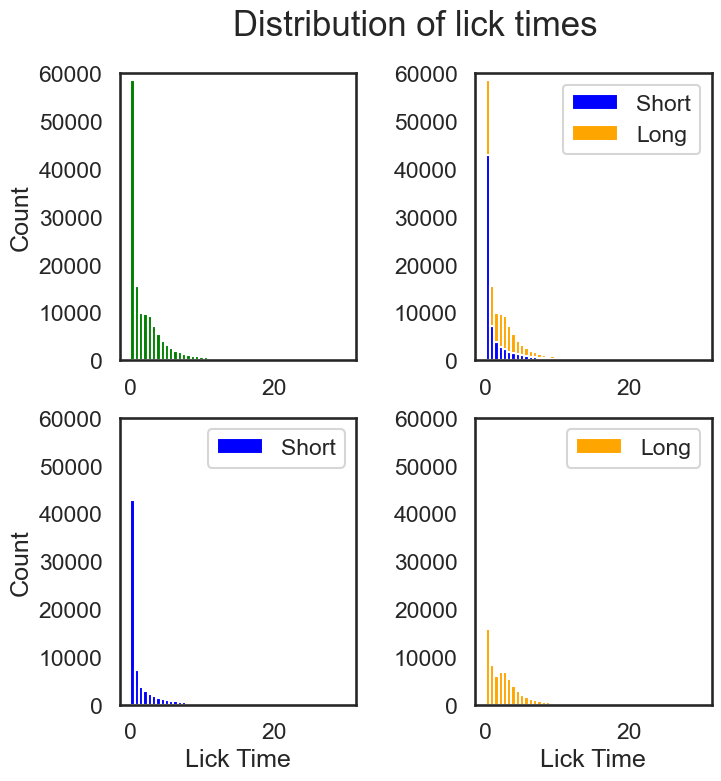

In [8]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0.13, right=0.87,
                    bottom=0.11, top=0.9, wspace=0.5)
fig.suptitle('Distribution of lick times', fontsize=25)
ax = fig.add_subplot(221)

ax.hist(stacked_all, stacked=True, bins = 50, color='green')
ax.set_ylabel('Count')
ax.set_ylim([0,60000])
# ax.set_xlabel('Lick Time')

ax = fig.add_subplot(222)
ax.hist([stacked_short, stacked_long], bins = 50, stacked=True, color=['blue', 'orange'], label=['Short', 'Long'])
ax.set_ylim([0,60000])
# ax.set_ylabel('Count')
# ax.set_xlabel('Lick Time')
ax.legend()  # This adds the legend to differentiate the cohorts

ax = fig.add_subplot(223)
ax.hist(stacked_short, bins = 50, color='blue')
ax.set_ylim([0,60000])
ax.set_ylabel('Count')
ax.set_xlabel('Lick Time')
ax.legend(["Short"])

ax = fig.add_subplot(224)
ax.hist(stacked_long, bins = 50, color='orange')
ax.set_ylim([0,60000])
# ax.set_ylabel('Count')
ax.set_xlabel('Lick Time')
ax.legend(["Long"])



Text(0, 0.5, 'Frequency')

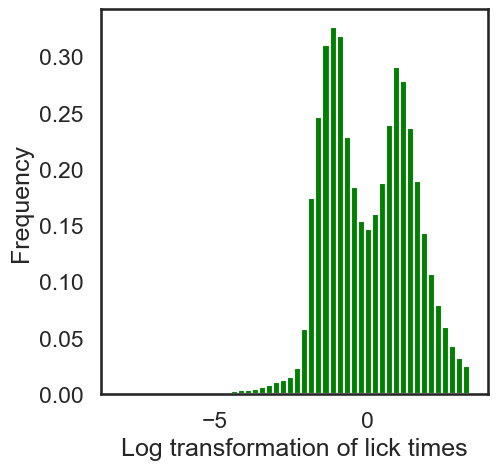

In [8]:
log_all = np.log(stacked_all)
fig = plt.figure(figsize=(5, 5))
plt.hist(log_all, bins=50, color='green',density = True)
plt.xlabel('Log transformation of lick times')
plt.ylabel('Frequency')


Text(0.5, 0.98, 'Log Distribution')

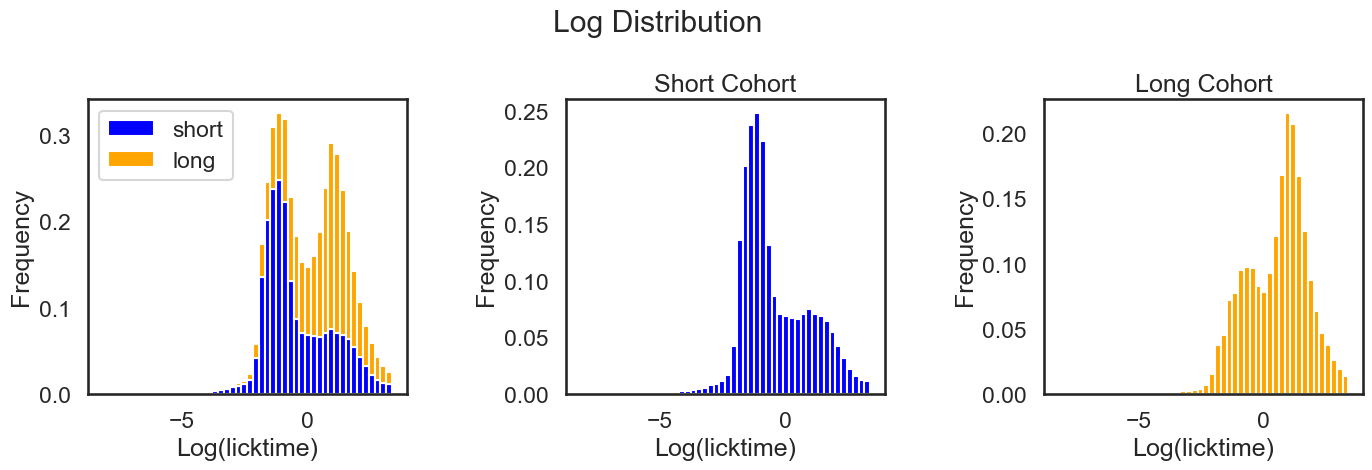

In [312]:
# apply log transformation to see if the data is log-normally distributed
log_short = np.log(stacked_short)  # the small constant ensures no log(0)
log_long = np.log(stacked_long)
log_all = np.log(stacked_all)

total_size = len(log_all)

# Calculate the proportions of each group
short_proportion = len(log_short) / total_size
long_proportion = len(log_long) / total_size

fig2 = plt.figure(figsize=(15, 5))
fig2.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.8, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig2.add_subplot(131)
_,bins,_ = ax.hist([log_short, log_long], stacked=True, bins=50, color=['blue', 'orange'], label=['Short', 'Long'],density = True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')

ax.legend(['short','long'])

ax = fig2.add_subplot(132)
short_density,_ = np.histogram(log_short, bins=bins,density=True)
ax.bar(bin_centers, short_density * short_proportion, align='center', width=np.diff(bins), color='blue')
ax.set_title('Short Cohort')
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')


ax = fig2.add_subplot(133)
long_density,_ = np.histogram(log_long, bins=bins,density=True)
ax.bar(bin_centers, long_density * long_proportion, align='center', width=np.diff(bins), color='orange')
ax.set_title('Long Cohort')
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')

plt.suptitle('Log Distribution')


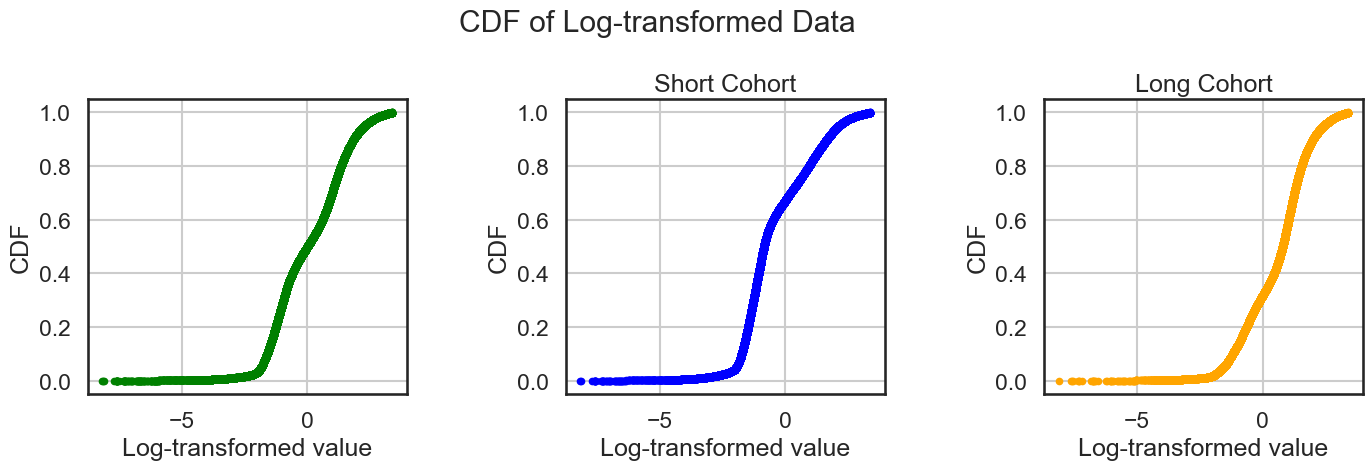

In [10]:
sorted_all = np.sort(log_all)
sorted_short = np.sort(log_short)
sorted_long = np.sort(log_long)
# Calculate the CDF values
cdf_all = np.arange(1, len(sorted_all)+1) / len(sorted_all)
cdf_short = np.arange(1, len(sorted_short)+1) / len(sorted_short)
cdf_long = np.arange(1, len(sorted_long)+1) / len(sorted_long)

# Plot the CDF
fig = plt.figure(figsize=(15, 5))
fig.suptitle('CDF of Log-transformed Data')
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.8, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
ax.plot(sorted_all, cdf_all, marker='.', linestyle='none',color='green')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(sorted_short, cdf_short, marker='.', linestyle='none',color='blue')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.set_title('Short Cohort')
plt.grid(True)

ax = fig.add_subplot(133)
ax.plot(sorted_long, cdf_long, marker='.', linestyle='none',color='orange')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.set_title('Long Cohort')
ax.grid(True)


**GMM for all data (both cohorts)**

In [39]:
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import FormatStrFormatter

In [238]:
X = log_all.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,5)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

[2.77280807e-04 1.13006946e-01 9.22907795e-01 5.38370708e+00
 2.99811757e+01]


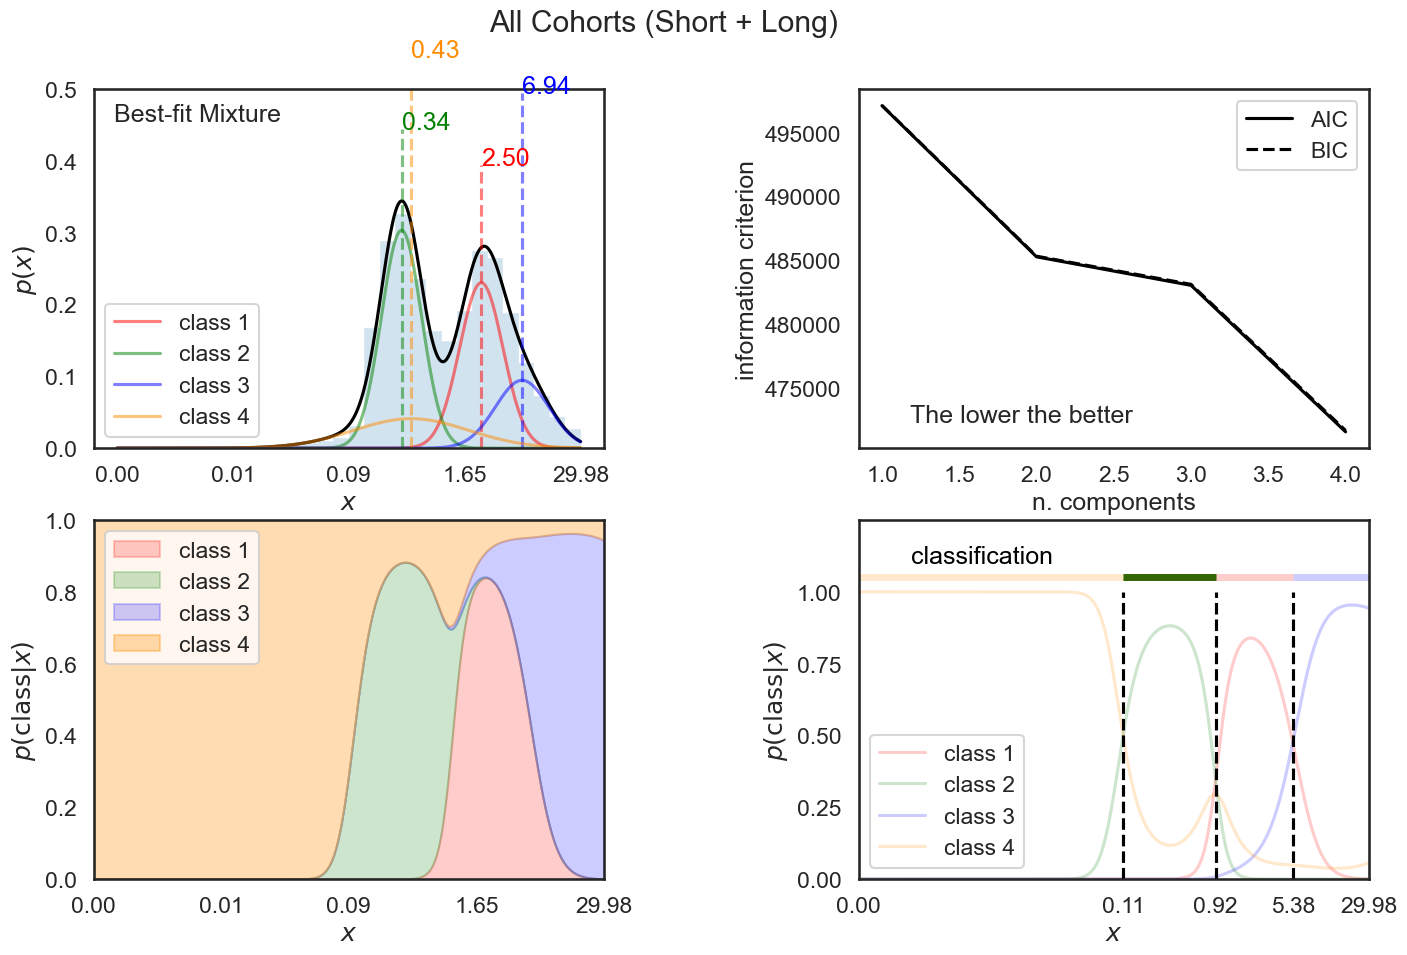

In [250]:
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[3]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
ax.set_ylim(0, 0.5)
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.1,0.06,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.fill_between(x, p[1], p[2], color=colors[2], alpha=0.2,label=f'class {3}')
ax.fill_between(x, p[2], 1, color=colors[3], alpha=0.3,label=f'class {4}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
# ax.text(-1.5, 0.3, 'class 1', rotation='vertical',color='k')
# ax.text(0.5, 0.3, 'class 2', rotation='vertical',color='k')
# ax.text(-4,0.3,'class 4',rotation='vertical',color='k')
# ax.text(2.2, 0.3, 'class 3', rotation='vertical',color='k')
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary1 = x[np.where(classification == 0)][0]
boundary2 = x[np.where(classification == 1)][0]
boundary3 = x[np.where(classification == 2)][0]
ax.vlines(boundary1,0,1,linestyles='dashed',color='k')
ax.vlines(boundary2,0,1,linestyles='dashed',color='k')
ax.vlines(boundary3,0,1,linestyles='dashed',color='k')
ax.hlines(1.05,x_min,boundary1,colors[3],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary1,boundary2,colors[1],linewidths = 5)
ax.hlines(1.05,boundary2,boundary3,colors[0],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary3,x_max,colors[2],alpha=0.2,linewidths = 5)
raw_decision_boundary = np.sort([x_min,boundary1, boundary2, boundary3,x_max])
decision_boundary= np.sort(np.exp(raw_decision_boundary))
ax.text(-7, 1.1, f'classification',color='k')
print(decision_boundary)
ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('All Cohorts (Short + Long)')
plt.show()




**GMM for Short Cohort**

In [260]:
X = log_short.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,5)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

[2.77280807e-04 1.07880068e-01 7.40299177e-01 2.99800947e+01]


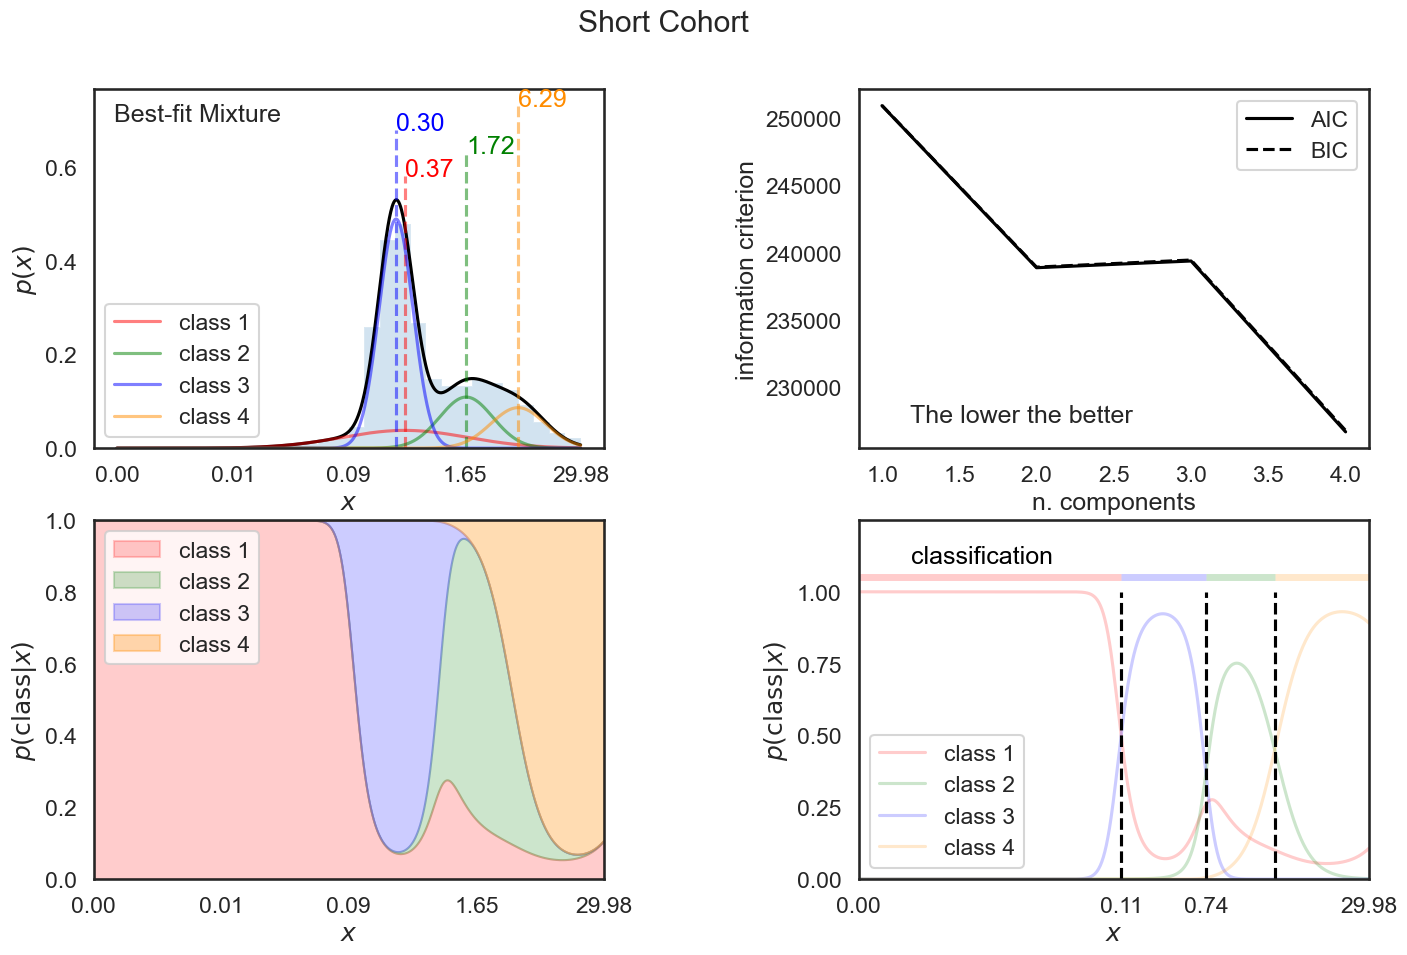

In [275]:
np.exp(M_best.means_)# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[3]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
# ax.set_ylim(0, 0.5)
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.1,0.06,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (2, 1, 3,1)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.fill_between(x, p[1], p[2], color=colors[2], alpha=0.2,label=f'class {3}')
ax.fill_between(x, p[2], 1, color=colors[3], alpha=0.3,label=f'class {4}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary1 = x[np.where(classification == 2)][0]
boundary2 = x[np.where(classification == 1)][0]
boundary3 = x[np.where(classification == 3)][0]
ax.vlines(boundary1,0,1,linestyles='dashed',color='k')
ax.vlines(boundary2,0,1,linestyles='dashed',color='k')
ax.vlines(boundary3,0,1,linestyles='dashed',color='k')

ax.hlines(1.05,x_min,boundary1,colors[0],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary2,boundary1,colors[2],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary2,boundary3,colors[1],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary3,x_max,colors[3],alpha=0.2,linewidths = 5)
raw_decision_boundary = [x_min,boundary1, boundary2,x_max]
decision_boundary= np.sort(np.exp(raw_decision_boundary))
ax.text(-7, 1.1, f'classification',color='k')
print(decision_boundary)
ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('Short Cohort')
plt.show()




**GMM for Long Cohort**

In [276]:
X = log_long.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,6)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

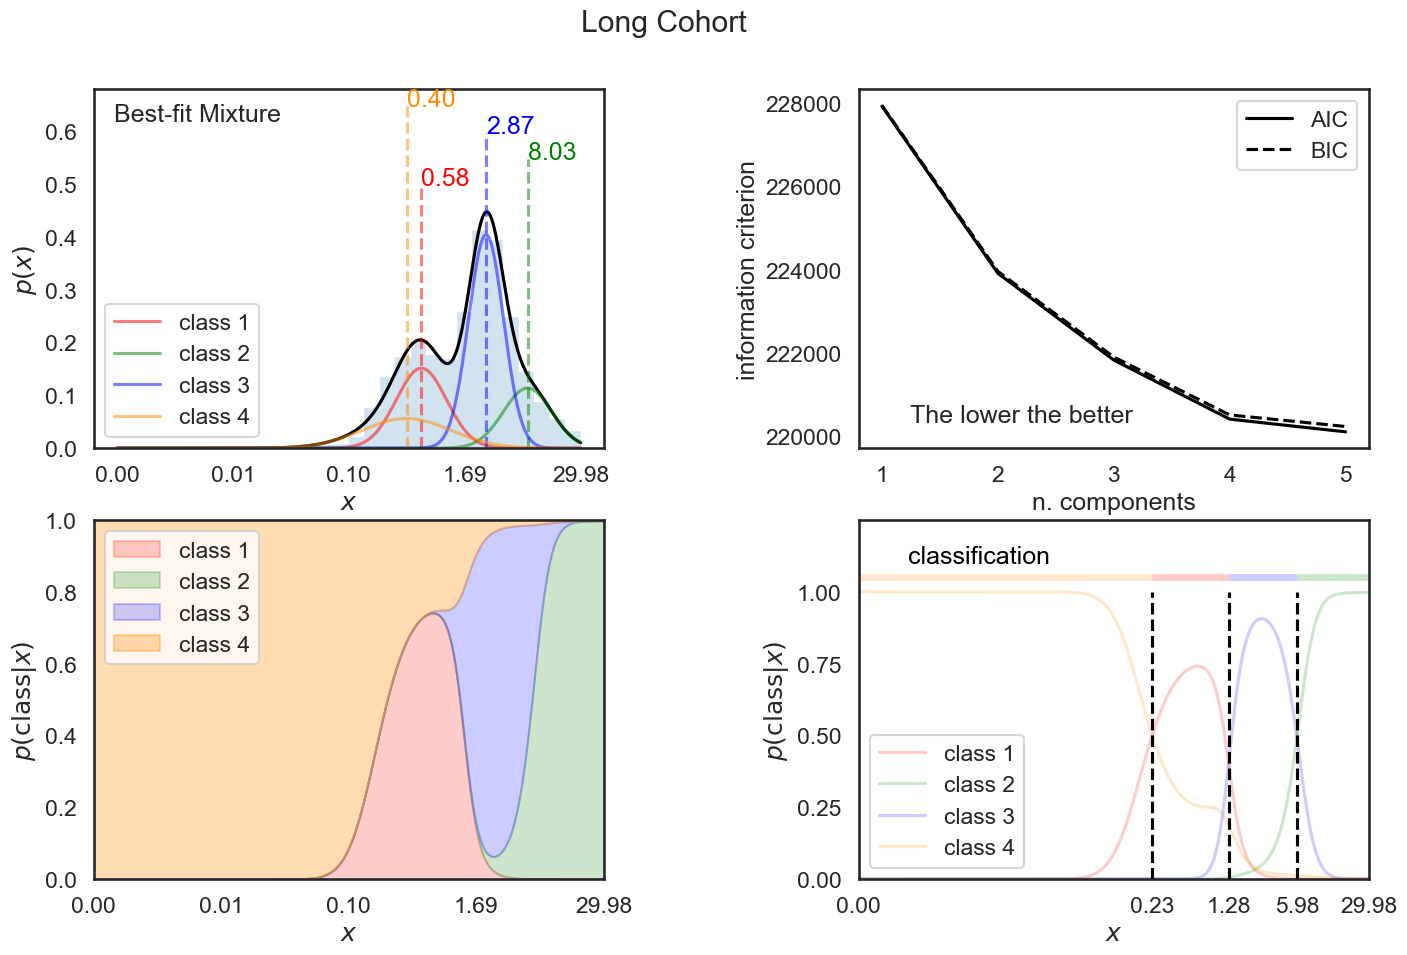

[3.02076340e-04 2.27045855e-01 1.27753742e+00 5.97868873e+00
 2.99811757e+01]


In [286]:
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[3]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
# ax.set_ylim(0, 0.5)
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.1,0.06,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.fill_between(x, p[1], p[2], color=colors[2], alpha=0.2,label=f'class {3}')
ax.fill_between(x, p[2], 1, color=colors[3], alpha=0.3,label=f'class {4}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
# ax.text(-1.5, 0.3, 'class 1', rotation='vertical',color='k')
# ax.text(0.5, 0.3, 'class 2', rotation='vertical',color='k')
# ax.text(-4,0.3,'class 4',rotation='vertical',color='k')
# ax.text(2.2, 0.3, 'class 3', rotation='vertical',color='k')
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary1 = x[np.where(classification == 0)][0]
boundary2 = x[np.where(classification == 2)][0]
boundary3 = x[np.where(classification == 1)][0]
ax.vlines(boundary1,0,1,linestyles='dashed',color='k')
ax.vlines(boundary2,0,1,linestyles='dashed',color='k')
ax.vlines(boundary3,0,1,linestyles='dashed',color='k')

ax.hlines(1.05,x_min,boundary1,colors[3],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary1,boundary2,colors[0],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary2,boundary3,colors[2],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary3,x_max,colors[1],alpha=0.2,linewidths = 5)
raw_decision_boundary = [x_min,boundary1, boundary2, boundary3,x_max]
decision_boundary= np.sort(np.exp(raw_decision_boundary))
ax.text(-7, 1.1, f'classification',color='k')

ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('Long Cohort')
plt.show()
print(decision_boundary)



**If we remove the data that belongs to the class that counts for the long left tail, the threshold for long is 0.23 seconds and 0.11 for short cohort**

**Visualize the distribution after filtering**

In [307]:
len(filtered_long)/len(stacked_long)

0.9410089328097355

In [303]:
filtered_short = stacked_short[stacked_short>0.11]
filtered_long = stacked_long[stacked_long>0.23]
filtered_all = np.concatenate([filtered_short,filtered_long],axis=0)

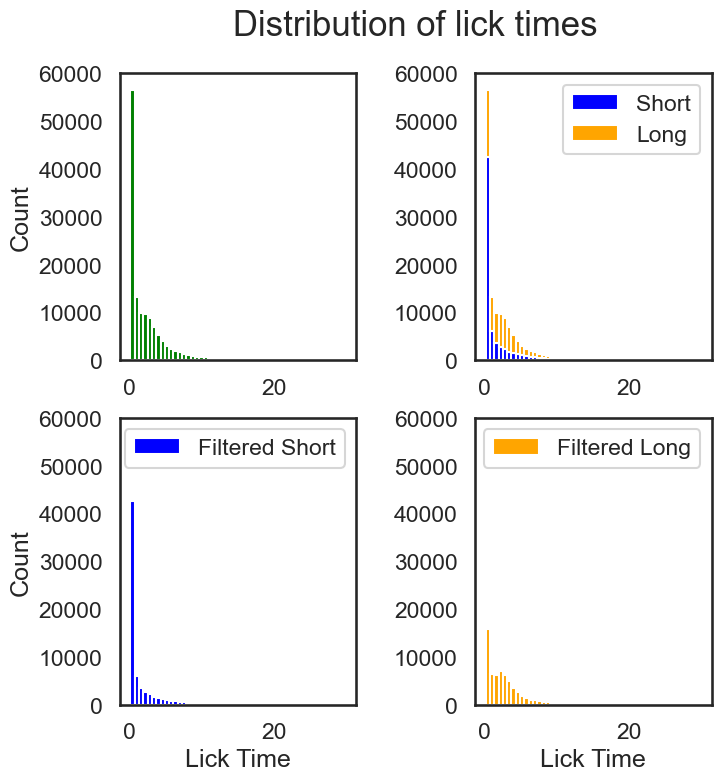

In [308]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0.13, right=0.87,
                    bottom=0.11, top=0.9, wspace=0.5)
fig.suptitle('Distribution of lick times', fontsize=25)
ax = fig.add_subplot(221)

ax.hist(filtered_all, stacked=True, bins = 50, color='green')
ax.set_ylabel('Count')
ax.set_ylim([0,60000])
# ax.set_xlabel('Lick Time')

ax = fig.add_subplot(222)
ax.hist([filtered_short, filtered_long], bins = 50, stacked=True, color=['blue', 'orange'], label=['Short', 'Long'])
ax.set_ylim([0,60000])
# ax.set_ylabel('Count')
# ax.set_xlabel('Lick Time')
ax.legend()  # This adds the legend to differentiate the cohorts

ax = fig.add_subplot(223)
ax.hist(filtered_short, bins = 50, color='blue')
ax.set_ylim([0,60000])
ax.set_ylabel('Count')
ax.set_xlabel('Lick Time')
ax.legend(["Filtered Short"])

ax = fig.add_subplot(224)
ax.hist(filtered_long, bins = 50, color='orange')
ax.set_ylim([0,60000])
# ax.set_ylabel('Count')
ax.set_xlabel('Lick Time')
ax.legend(["Filtered Long"])

Text(0.5, 0.98, 'Filtered Log Distribution')

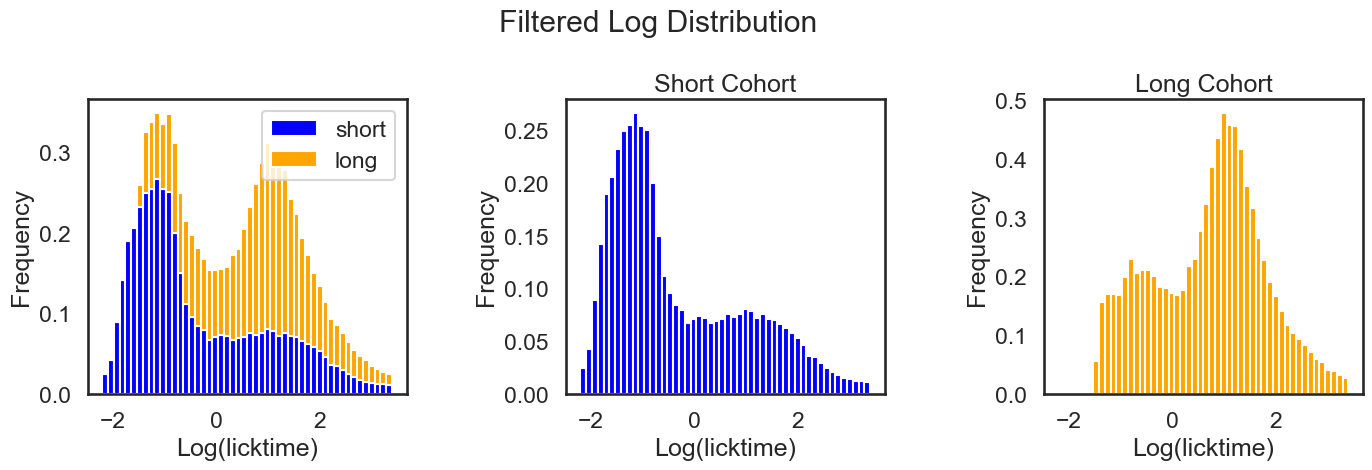

In [311]:
log_filtered_short = np.log(filtered_short)  # the small constant ensures no log(0)
log_filtered_long = np.log(filtered_long)
log_filtered_all = np.log(filtered_all)

total_size = len(log_filtered_all)

# Calculate the proportions of each group
short_proportion = len(log_filtered_short) / total_size
long_proportion = len(log_filtered_all) / total_size

fig2 = plt.figure(figsize=(15, 5))
fig2.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.8, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig2.add_subplot(131)
_,bins,_ = ax.hist([log_filtered_short, log_filtered_long], stacked=True, bins=50, color=['blue', 'orange'], label=['Short', 'Long'],density = True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')

ax.legend(['short','long'])

ax = fig2.add_subplot(132)
short_density,_ = np.histogram(log_filtered_short, bins=bins,density=True)
ax.bar(bin_centers, short_density * short_proportion, align='center', width=np.diff(bins), color='blue')
ax.set_title('Short Cohort')
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')


ax = fig2.add_subplot(133)
long_density,_ = np.histogram(log_filtered_long, bins=bins,density=True)
ax.bar(bin_centers, long_density * long_proportion, align='center', width=np.diff(bins), color='orange')
ax.set_title('Long Cohort')
ax.set_xlabel('Log(licktime)')
ax.set_ylabel('Frequency')
plt.suptitle('Filtered Log Distribution')


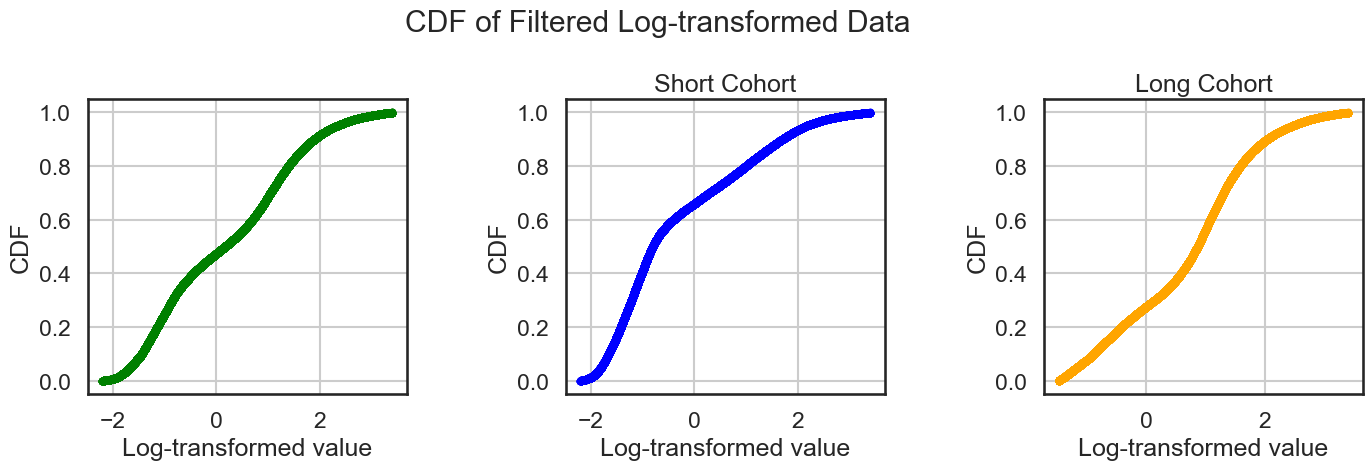

In [314]:
sorted_all = np.sort(log_filtered_all)
sorted_short = np.sort(log_filtered_short)
sorted_long = np.sort(log_filtered_long)
# Calculate the CDF values
cdf_all = np.arange(1, len(sorted_all)+1) / len(sorted_all)
cdf_short = np.arange(1, len(sorted_short)+1) / len(sorted_short)
cdf_long = np.arange(1, len(sorted_long)+1) / len(sorted_long)

# Plot the CDF
fig = plt.figure(figsize=(15, 5))
fig.suptitle('CDF of Filtered Log-transformed Data')
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.8, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
ax.plot(sorted_all, cdf_all, marker='.', linestyle='none',color='green')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(sorted_short, cdf_short, marker='.', linestyle='none',color='blue')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.set_title('Short Cohort')
plt.grid(True)

ax = fig.add_subplot(133)
ax.plot(sorted_long, cdf_long, marker='.', linestyle='none',color='orange')
ax.set_xlabel('Log-transformed value')
ax.set_ylabel('CDF')
ax.set_title('Long Cohort')
ax.grid(True)


**GLM for filtered All

In [ ]:
# Now run GLM again
X = log_filtered_all.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,5)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

[ 0.11001825  0.80703331 29.98117566]


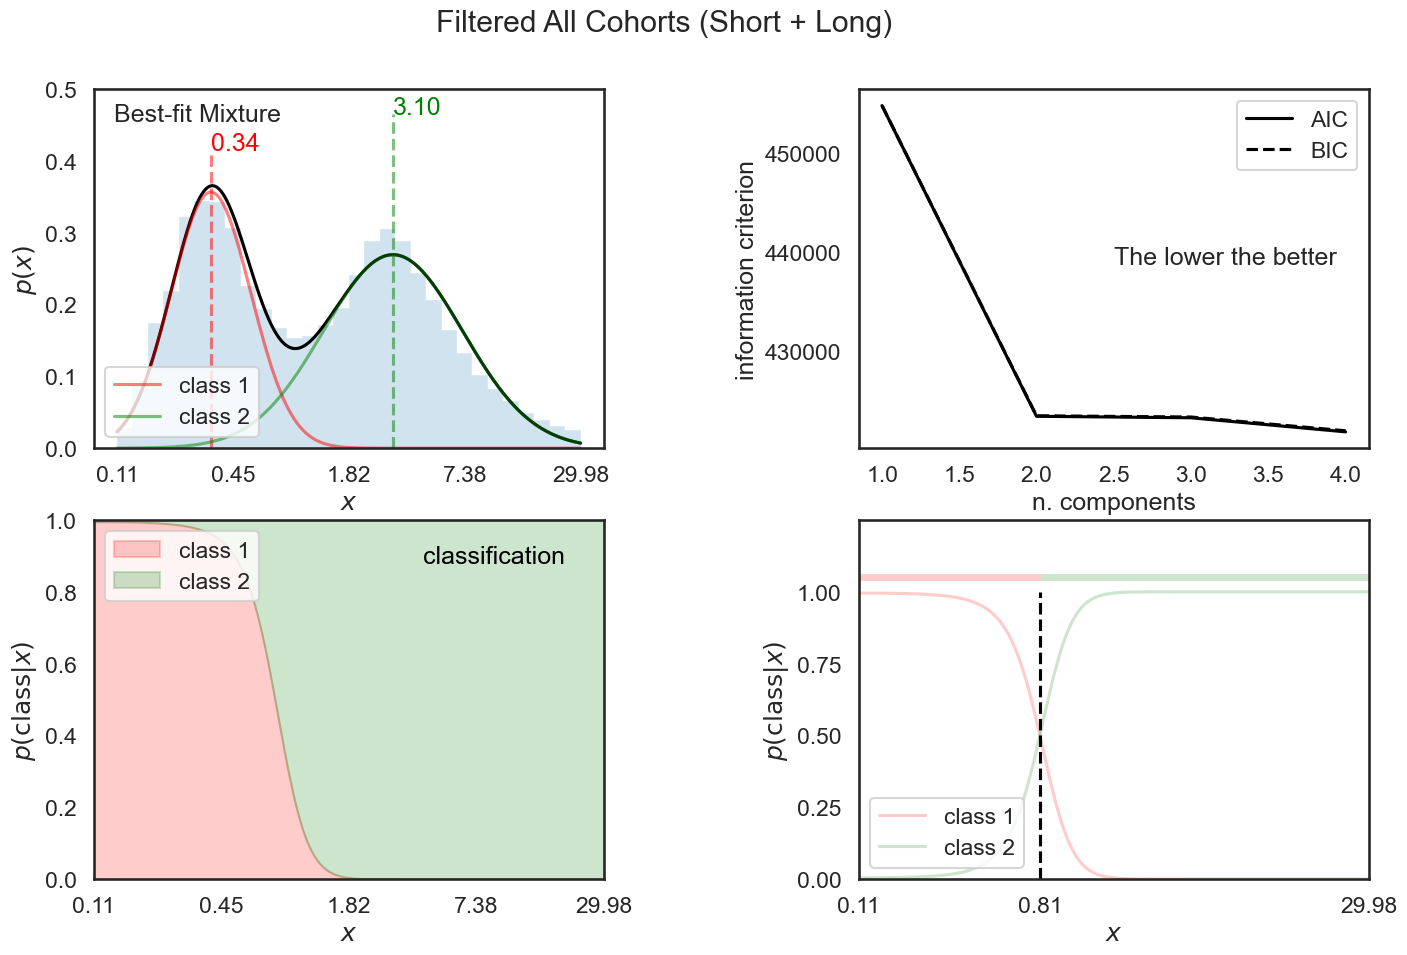

In [324]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[1]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
ax.set_ylim(0, 0.5)
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.5,0.5,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary = x[np.where(classification == 1)][0]
ax.vlines(boundary,0,1,linestyles='dashed',color='k')
ax.hlines(1.05,x_min,boundary,colors[0],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary,x_max,colors[1],alpha=0.2,linewidths = 5)
raw_decision_boundary = np.sort([x_min,boundary,x_max])
decision_boundary= np.sort(np.exp(raw_decision_boundary))
ax.text(-7, 1.1, f'classification',color='k')
print(decision_boundary)
ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('Filtered All Cohorts (Short + Long)')
plt.show()


**GLM for filtered Short**

In [325]:
X = log_filtered_short.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,5)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

[ 0.11001825  0.76297066 29.98009467]


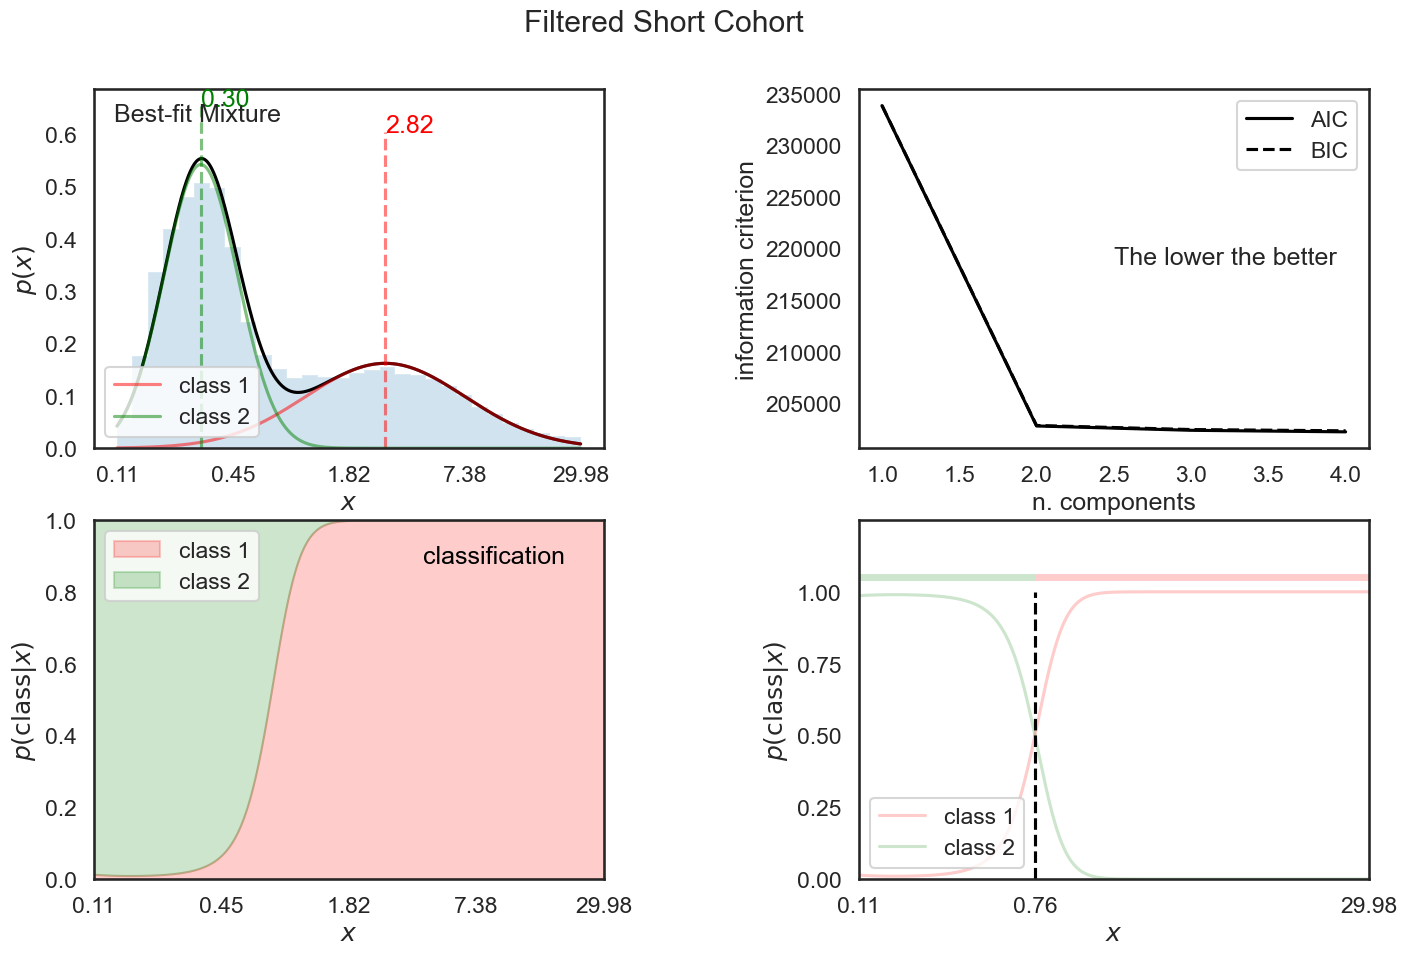

In [330]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[1]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.5,0.5,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary = x[np.where(classification == 0)][0]
ax.vlines(boundary,0,1,linestyles='dashed',color='k')
ax.hlines(1.05,x_min,boundary,colors[1],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary,x_max,colors[0],alpha=0.2,linewidths = 5)
raw_decision_boundary = np.sort([x_min,boundary,x_max])
decision_boundary= np.sort(np.exp(raw_decision_boundary))
ax.text(-7, 1.1, f'classification',color='k')
print(decision_boundary)
ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('Filtered Short Cohort')
plt.show()


**GLM for filtered Long**

In [331]:
X = log_filtered_long.reshape(-1, 1)
colors = ["cornflowerblue", "darkorange"]
r = np.random.RandomState(seed=1234)
N=np.arange(1,6)
models = [None for i in range(0,len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

[ 0.23005056  1.14383448 29.98117566]


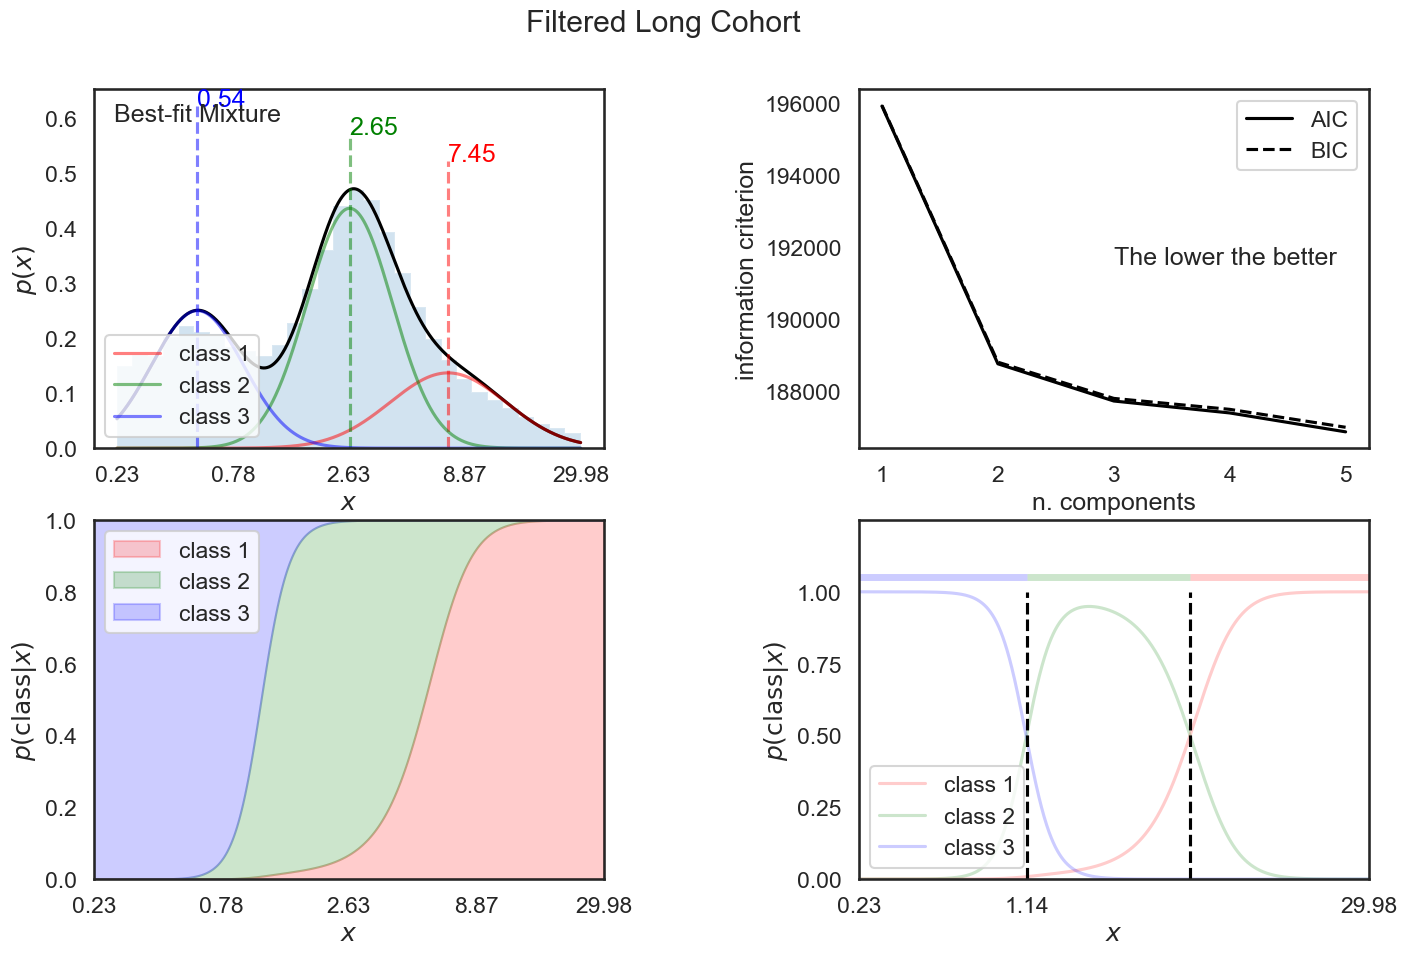

In [350]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.11, top=0.9, wspace=0.5)
colors = ["red", "green", "blue", "darkorange"]

# plot 1: data + best-fit mixture
ax = fig.add_subplot(221)
# M_best = models[np.argmin(AIC)]
M_best = models[2]

# plotting params
x_min = np.min(X)
x_max = np.max(X)
x = np.linspace(x_min, x_max, 1000)
ticks= np.linspace(x_min,x_max,5)
tick_labels = [f'{val:.2f}' for val in np.exp(ticks)]
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, pdf, '-k')
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x, pdf_individual[:,i],color=colors[i],alpha=0.5,label = f'class {i+1}')
    ax.vlines(M_best.means_[i],0,np.max(pdf)+(i+1)*0.05,color = colors[i],linestyles='dashed',alpha=0.5)
    ax.text(M_best.means_[i], np.max(pdf)+(i+1)*0.05, f"{np.exp(M_best.means_[i])[0]:.2f}",color = colors[i])
ax.legend(loc="lower left")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 2: AIC and BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.text(0.5,0.5,"The lower the better",ha='left', va='bottom', transform=ax.transAxes)
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc="upper right")


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(223)

p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T
ax.fill_between(x, 0, p[0], color=colors[0], alpha=0.2,label=f'class {1}') 
ax.fill_between(x, p[0], p[1], color=colors[1], alpha=0.2,label=f'class {2}')
ax.fill_between(x, p[1], p[2], color=colors[2], alpha=0.2,label=f'class {3}')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
ax.set_xticks(ticks)
ax.legend(loc=2)
ax.set_xlim(x_min, x_max)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# plot 4: posterior probabilities for each component
ax = fig.add_subplot(224)
posterior = responsibilities
for i in range(0,pdf_individual.shape[1]):
    ax.plot(x,posterior[:,i], color=colors[i],alpha=0.2,label=f"class {i+1}")
ax.legend(loc="lower left")
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.25)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')
# ax.text(-7, 1.1, f'classification',color='k')
ax.set_yticks(np.linspace(0,1,5))
ax.set_xticks(ticks)
ax.set_xlim(x_min, x_max)

classification =np.argmax(responsibilities,axis=1)
boundary1 = x[np.where(classification == 1)][0]
boundary2 = x[np.where(classification == 0)][0]
ax.vlines(boundary1,0,1,linestyles='dashed',color='k')
ax.vlines(boundary2,0,1,linestyles='dashed',color='k')
ax.hlines(1.05,x_min,boundary1,colors[2],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary1,boundary2,colors[1],alpha=0.2,linewidths = 5)
ax.hlines(1.05,boundary2,x_max,colors[0],alpha=0.2,linewidths = 5)
raw_decision_boundary = np.sort([x_min,boundary,x_max])
decision_boundary= np.sort(np.exp(raw_decision_boundary))

print(decision_boundary)
ax.set_xticks(raw_decision_boundary)
ax.set_xticklabels([f'{val:.2f}' for val in decision_boundary])
plt.suptitle('Filtered Long Cohort')
plt.show()

**Inividual mice & individual session visualization (ALL trials)**

In [348]:
print(len(mouse_list))
print(mouse_list)

8
['ZG030', 'ZG031', 'ZG034', 'ZG035', 'ZG033', 'ZG032', 'ZG036', 'ZG037']


/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Impulsive sessions to remove: [19 27 45 50 53]


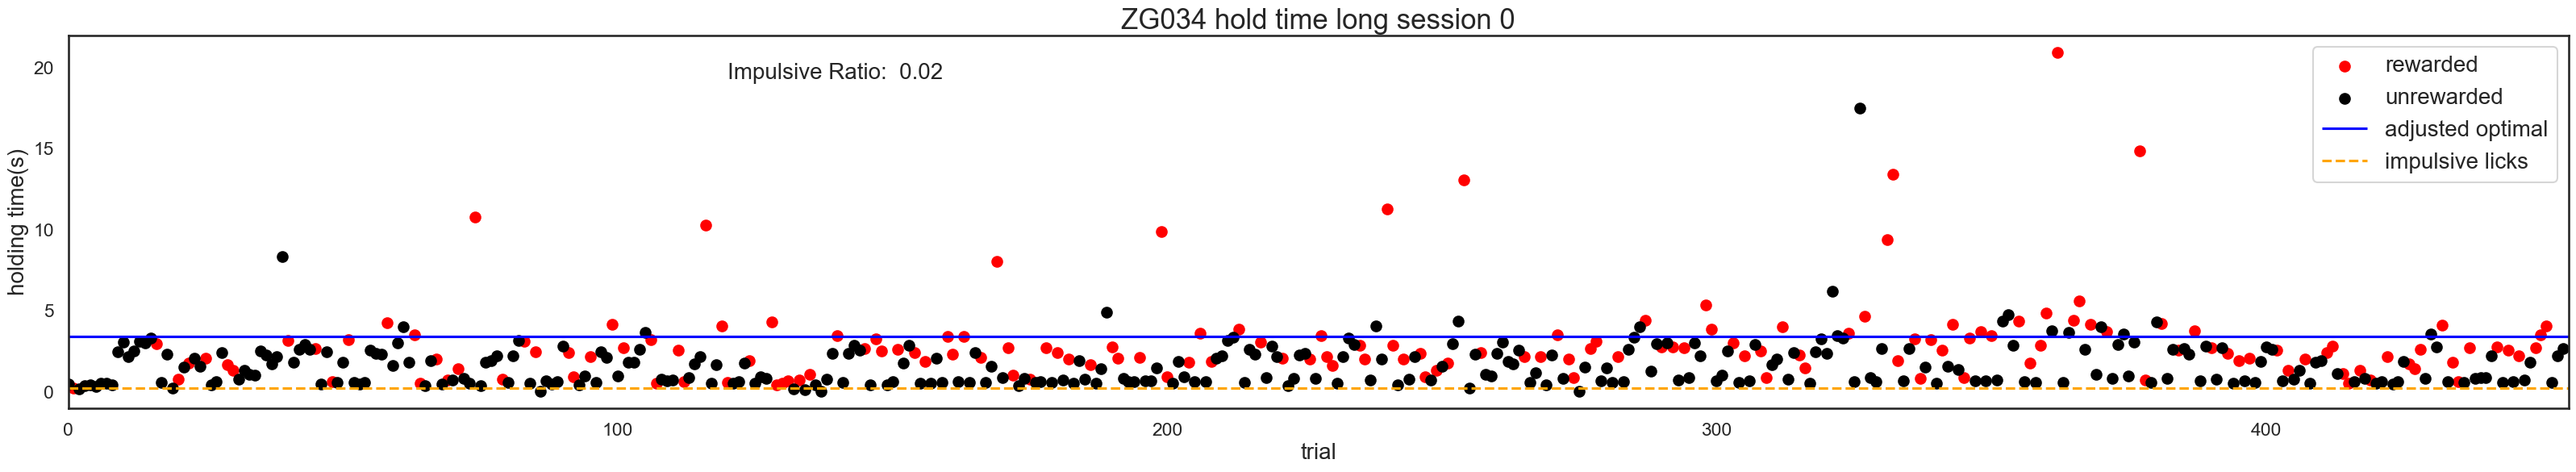

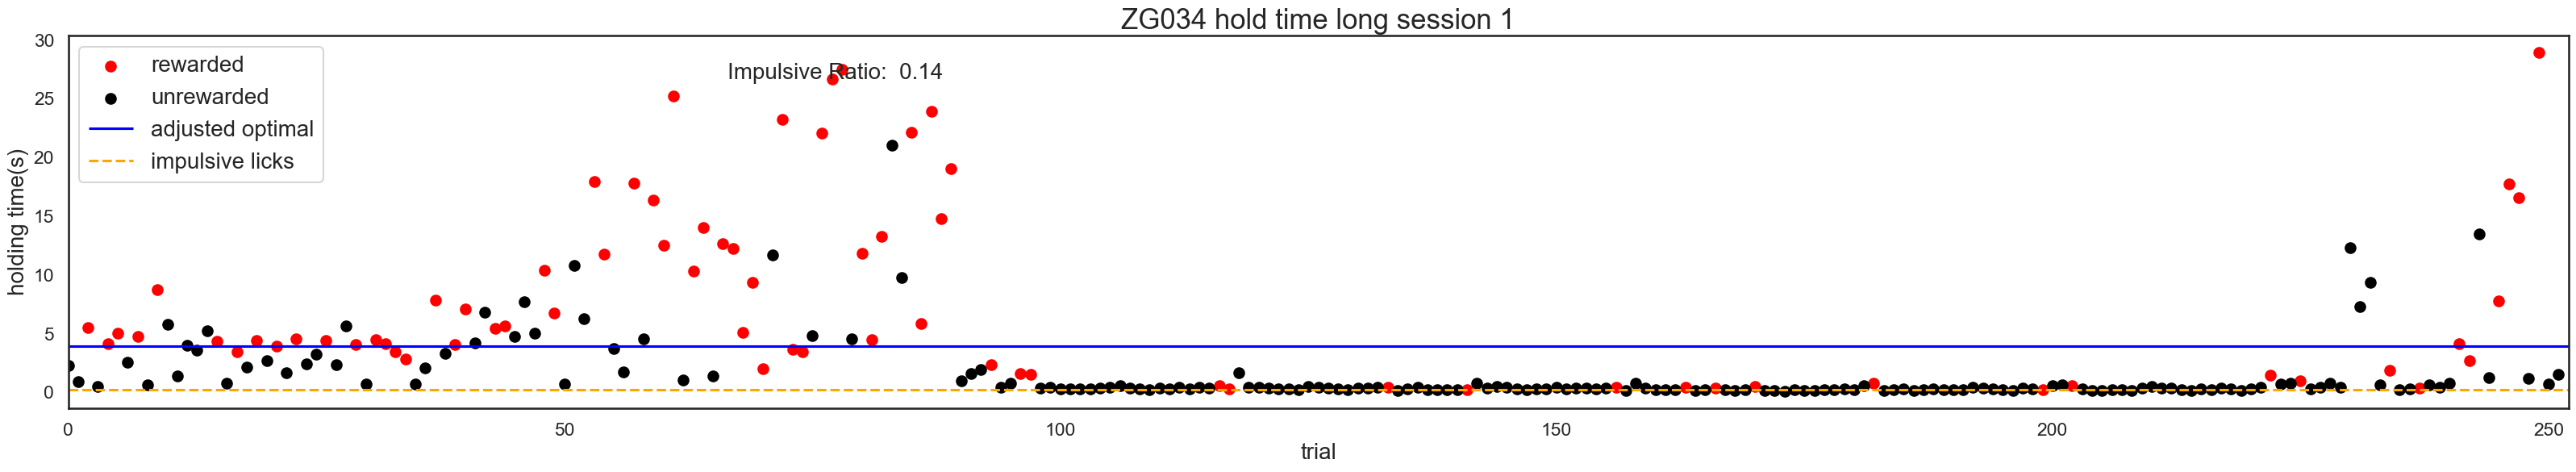

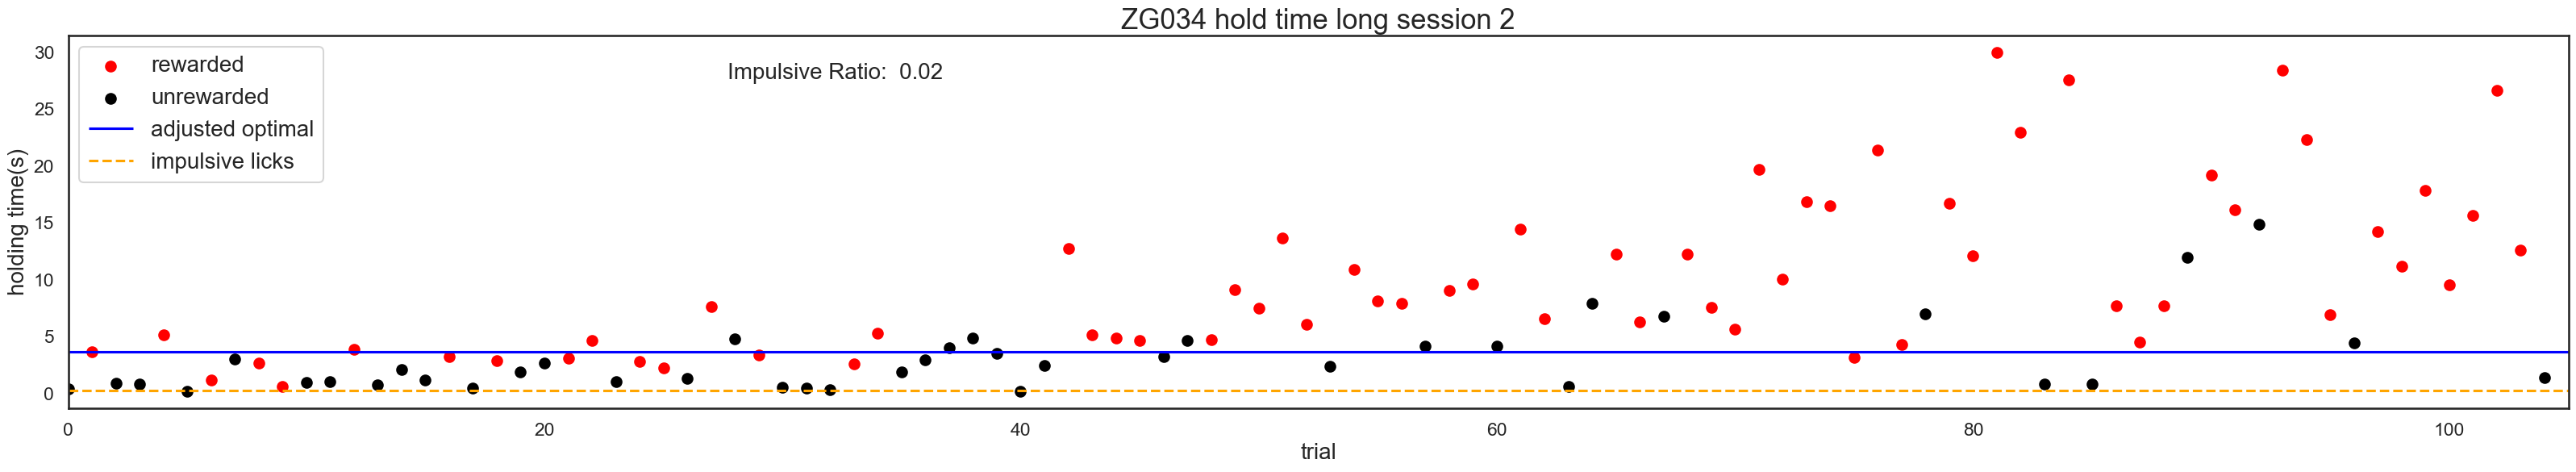

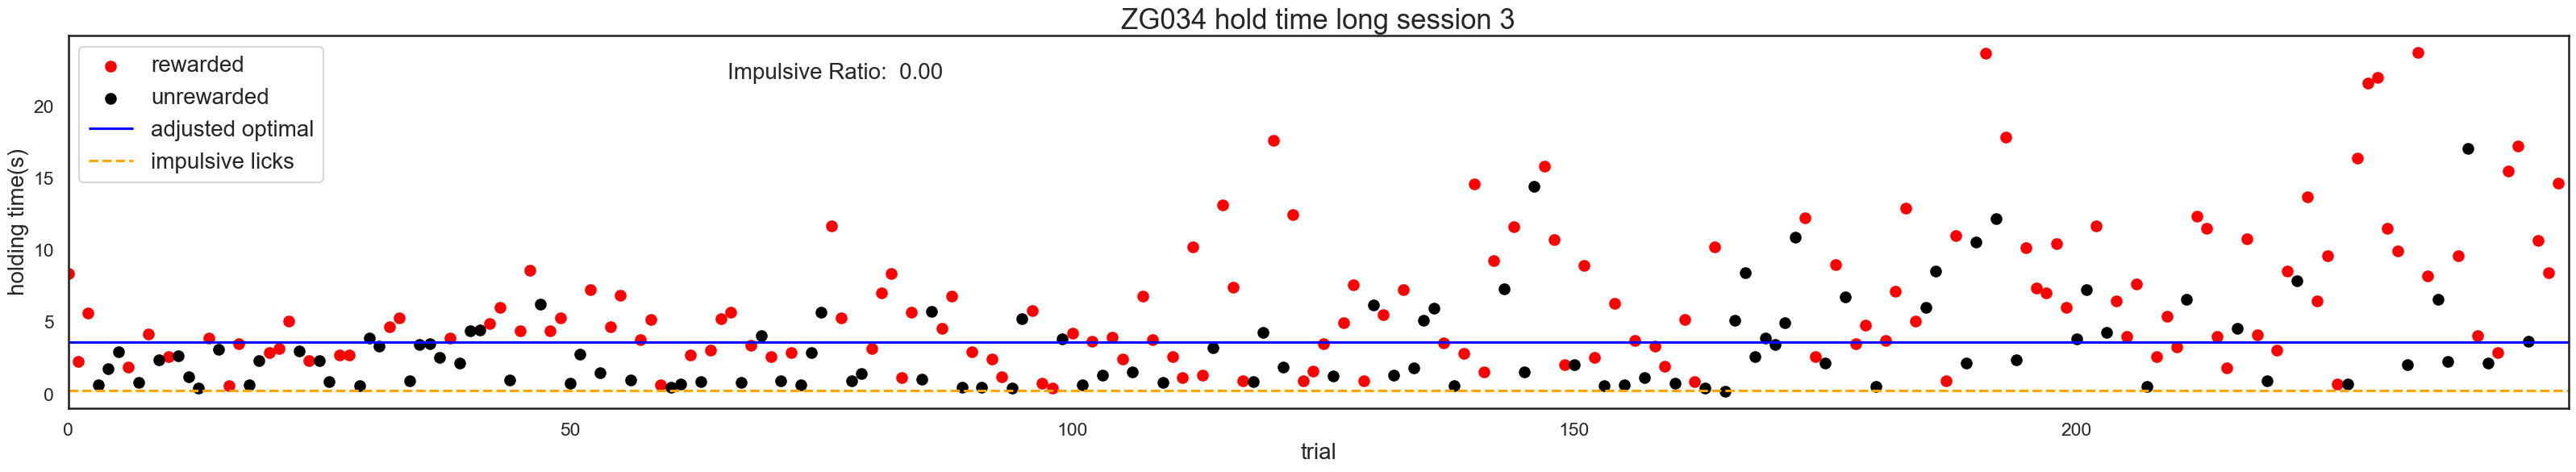

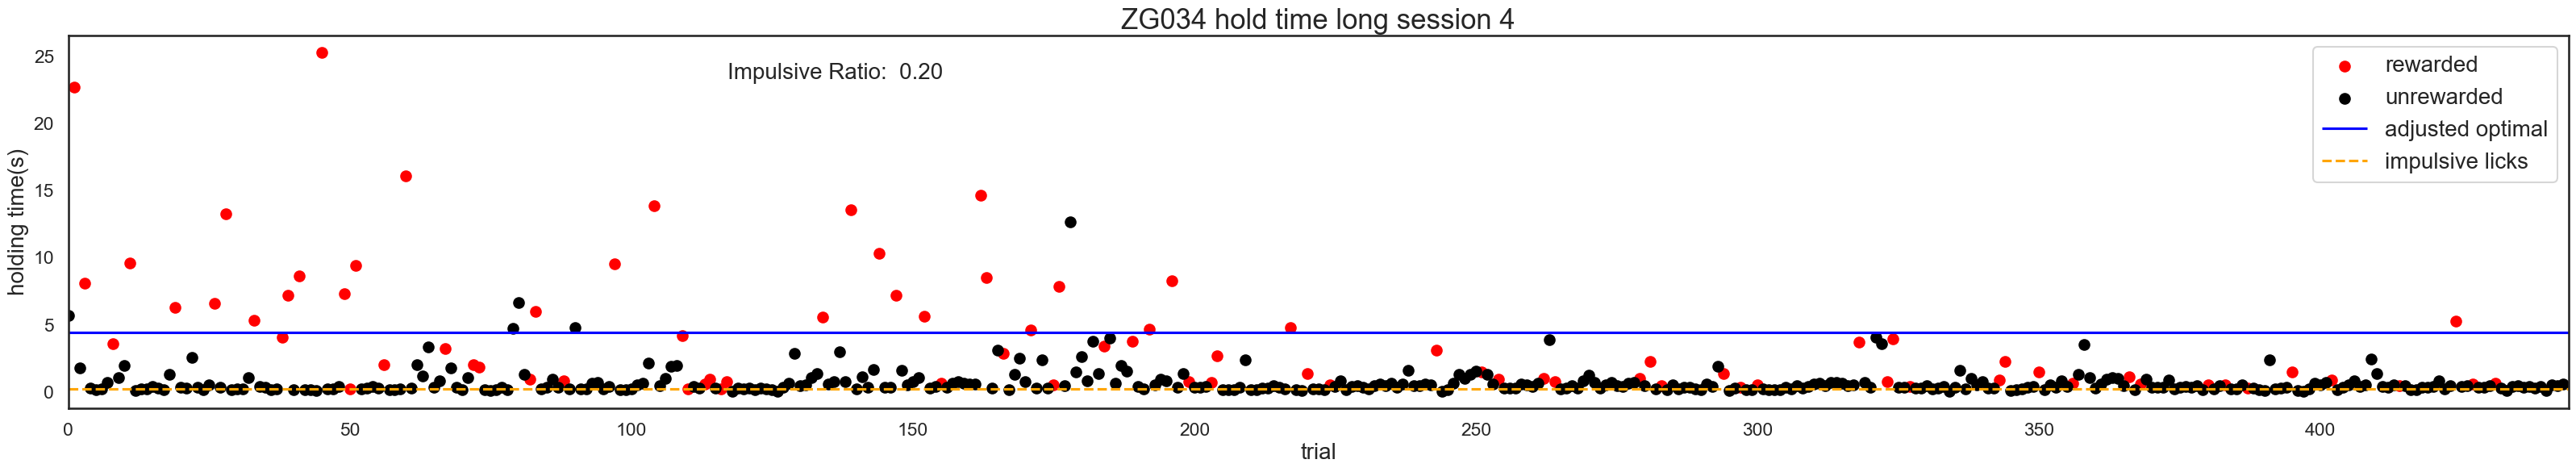

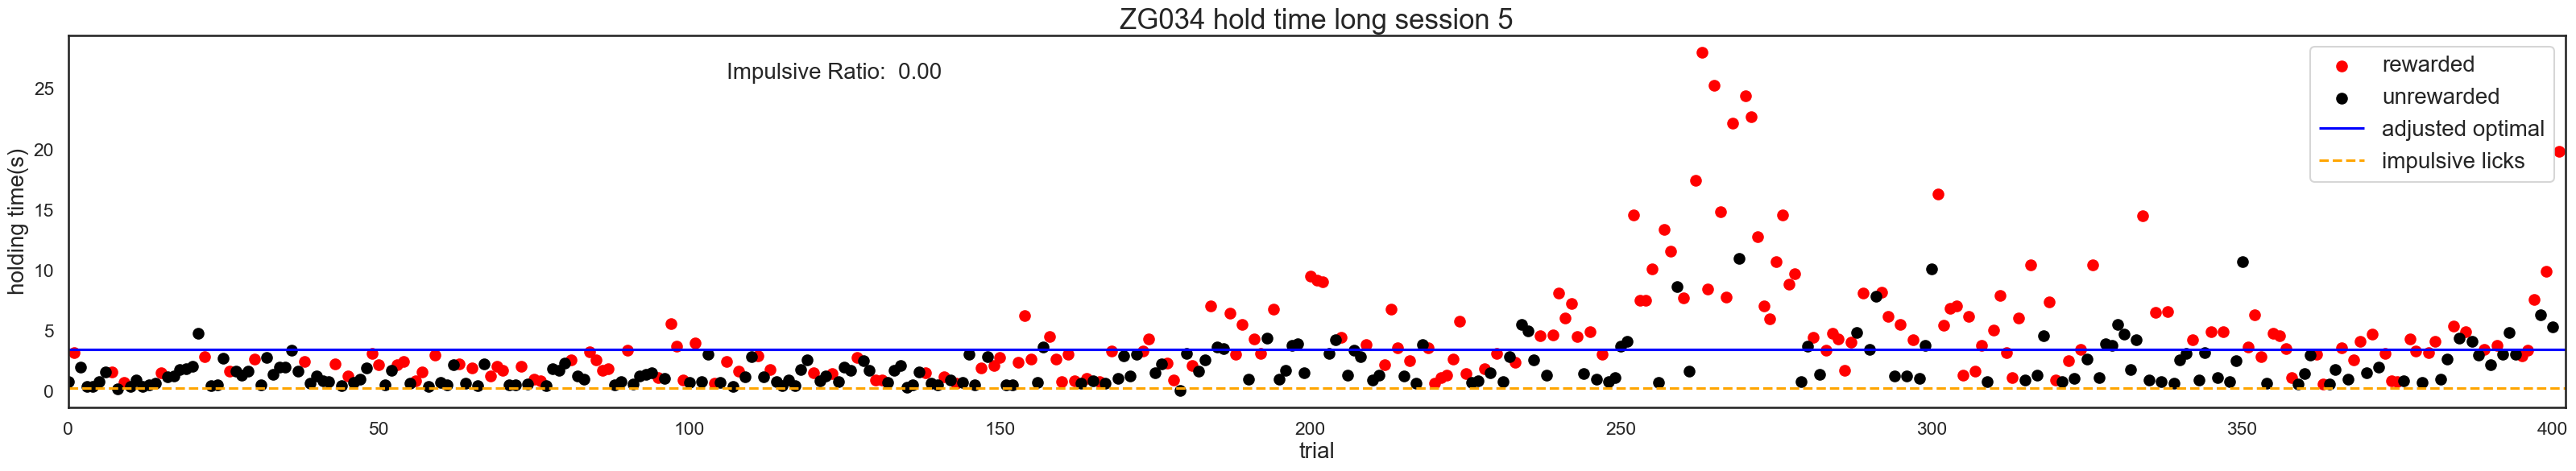

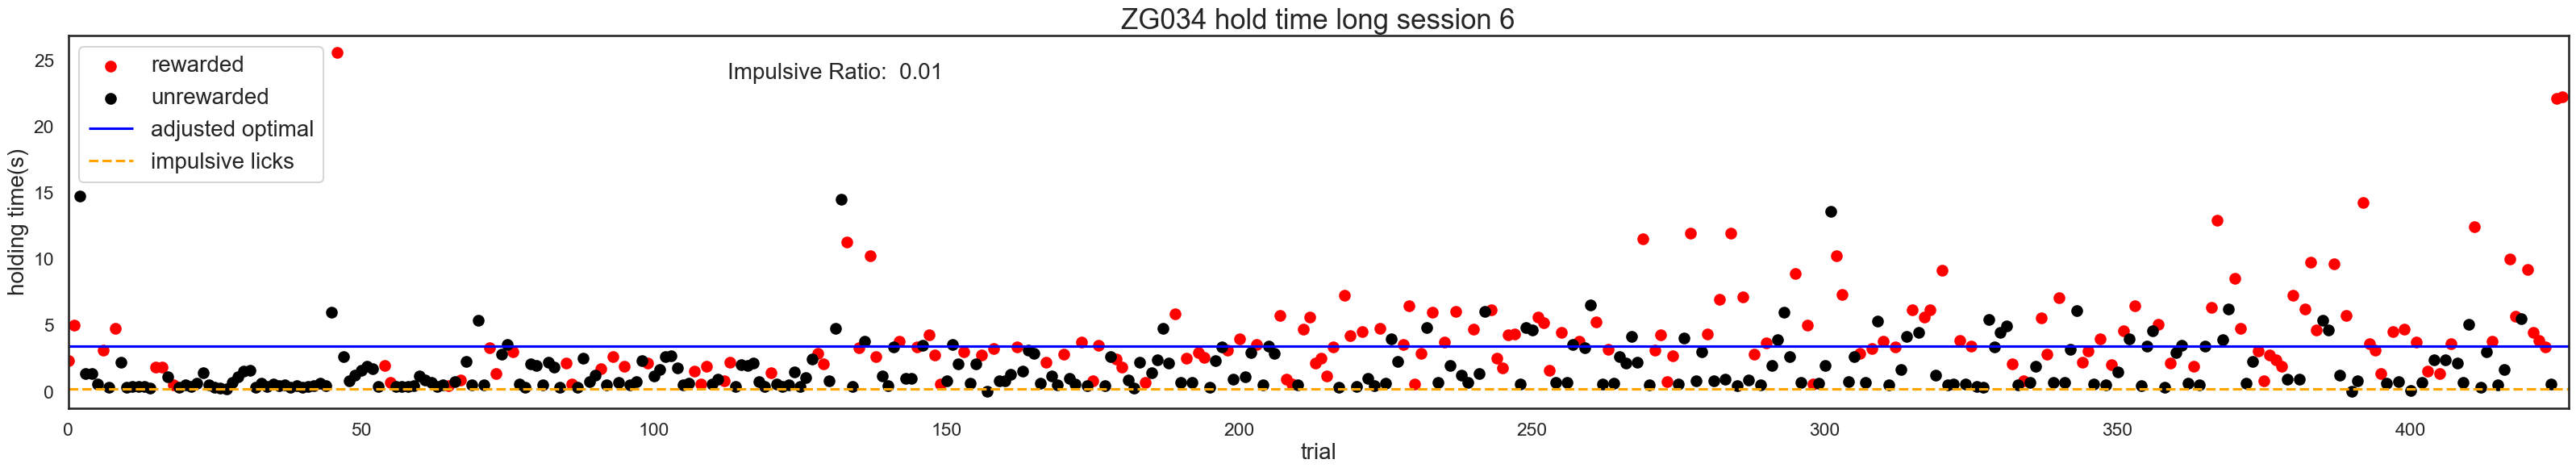

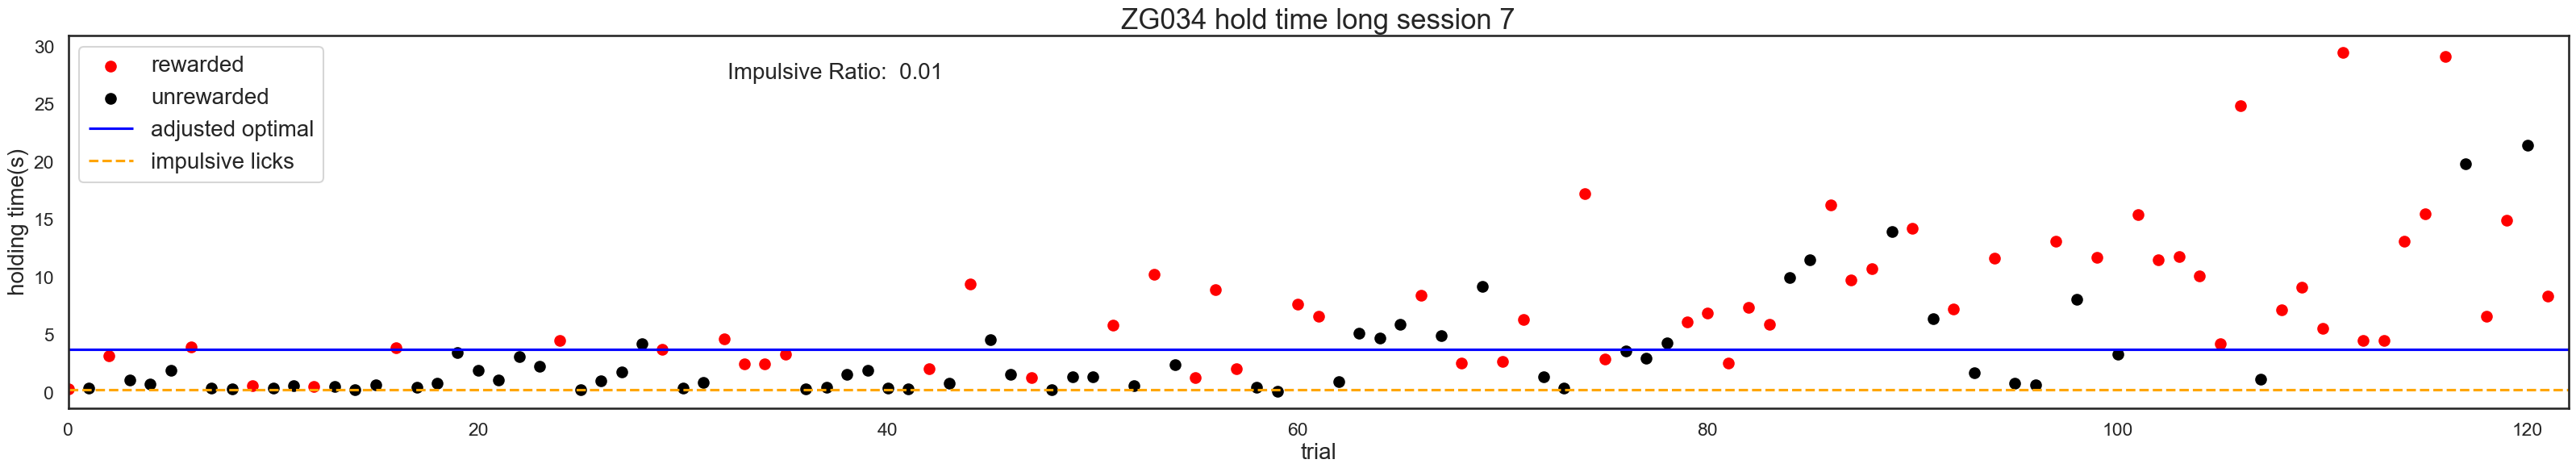

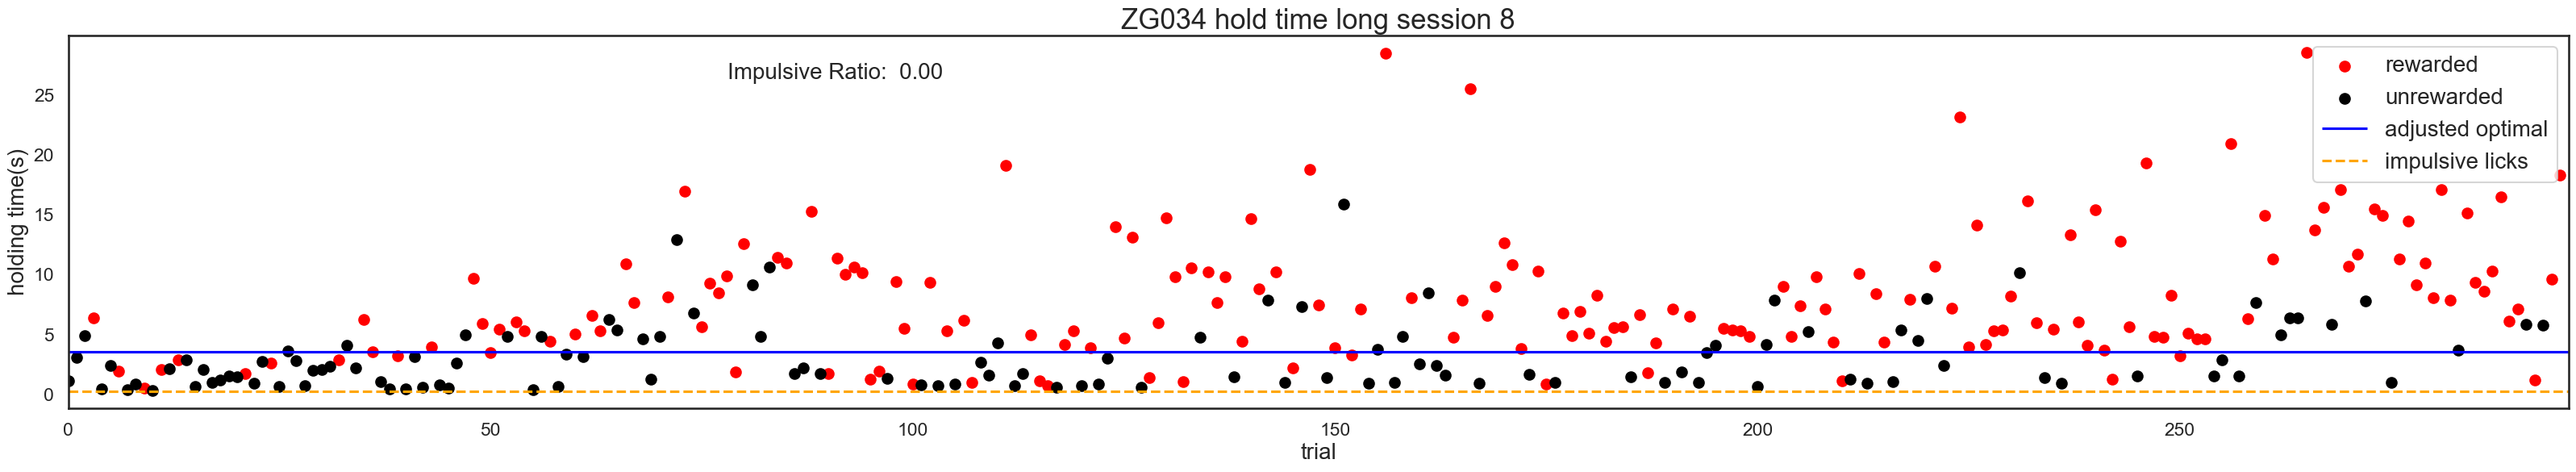

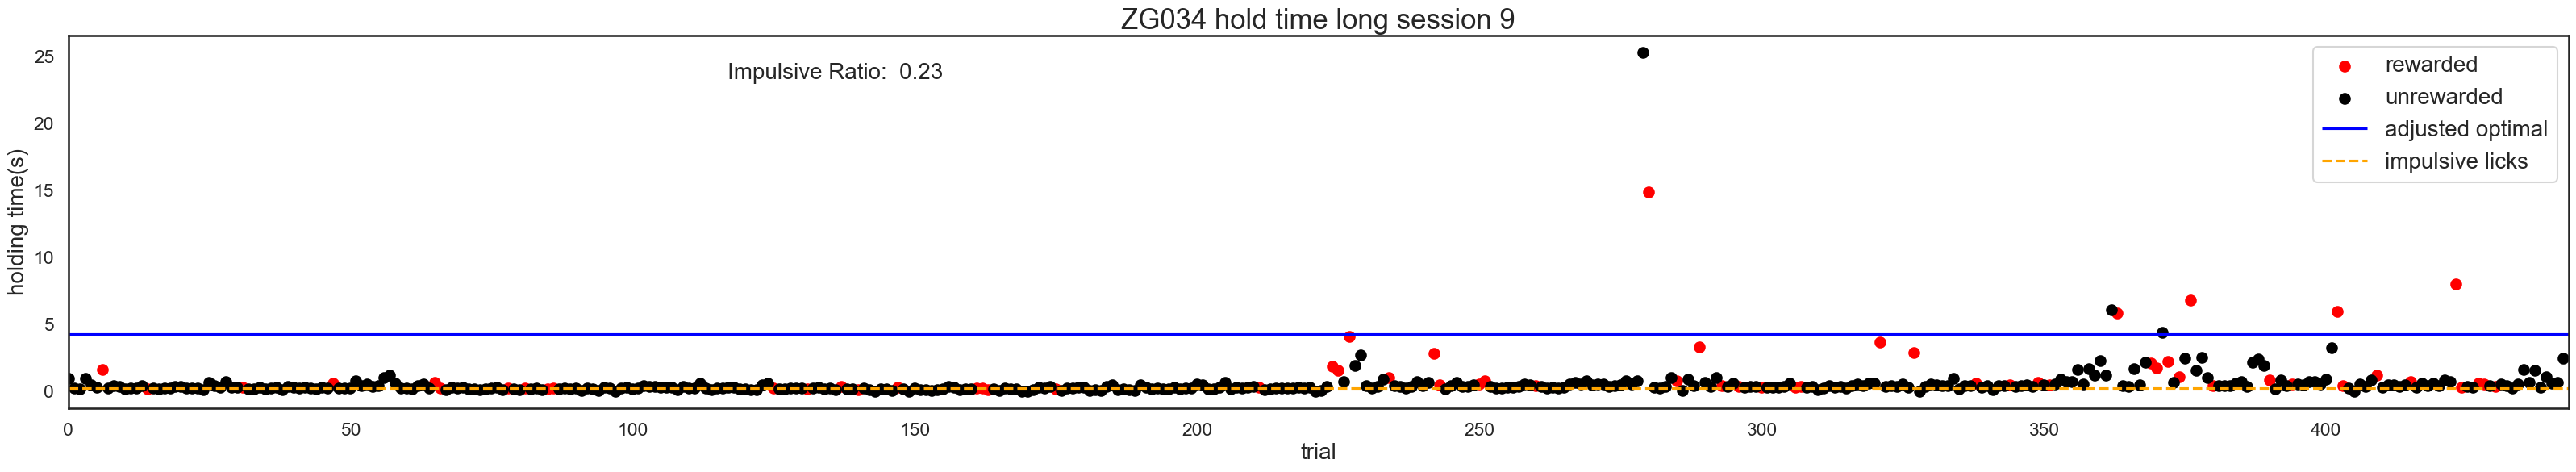

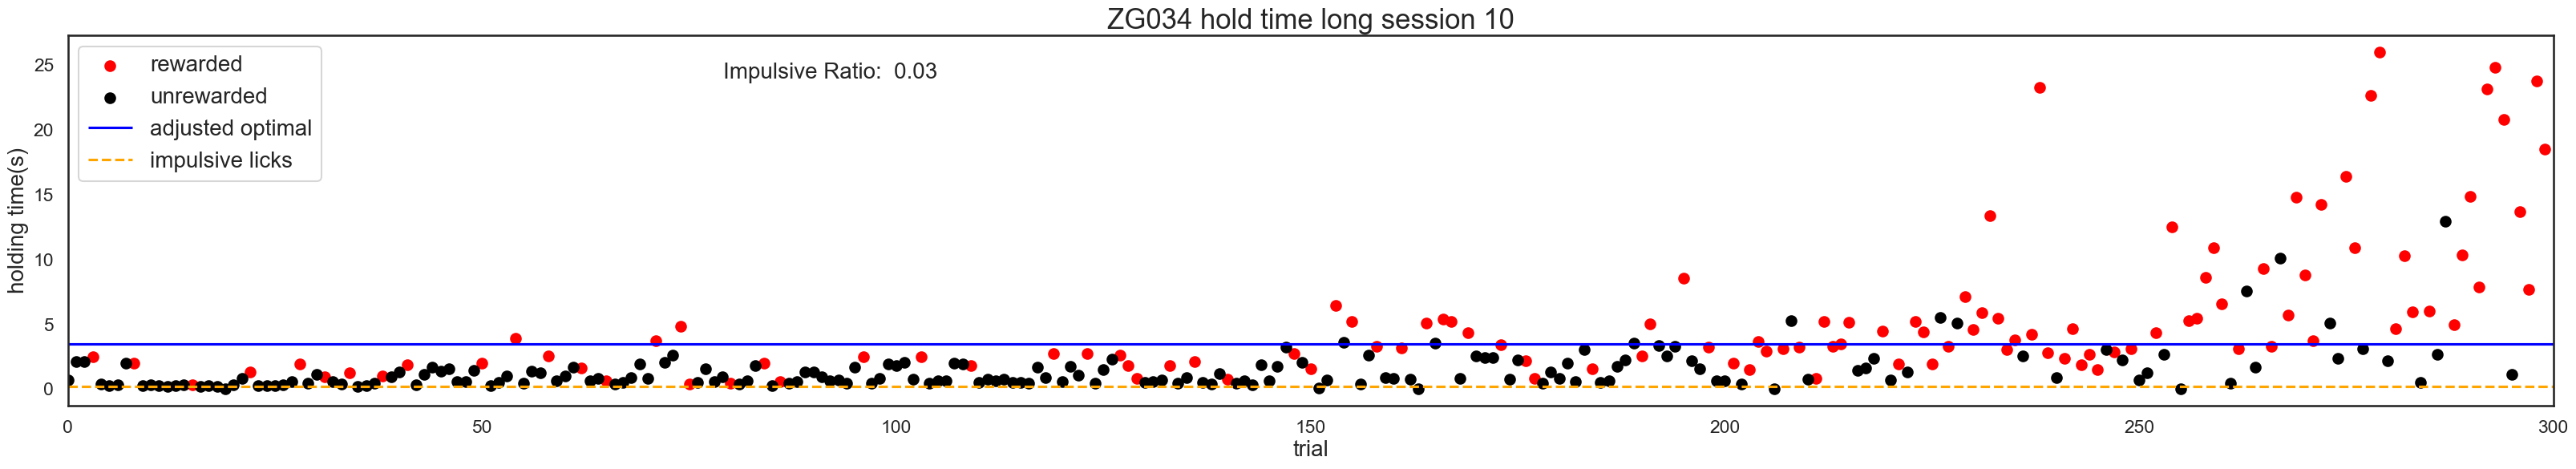

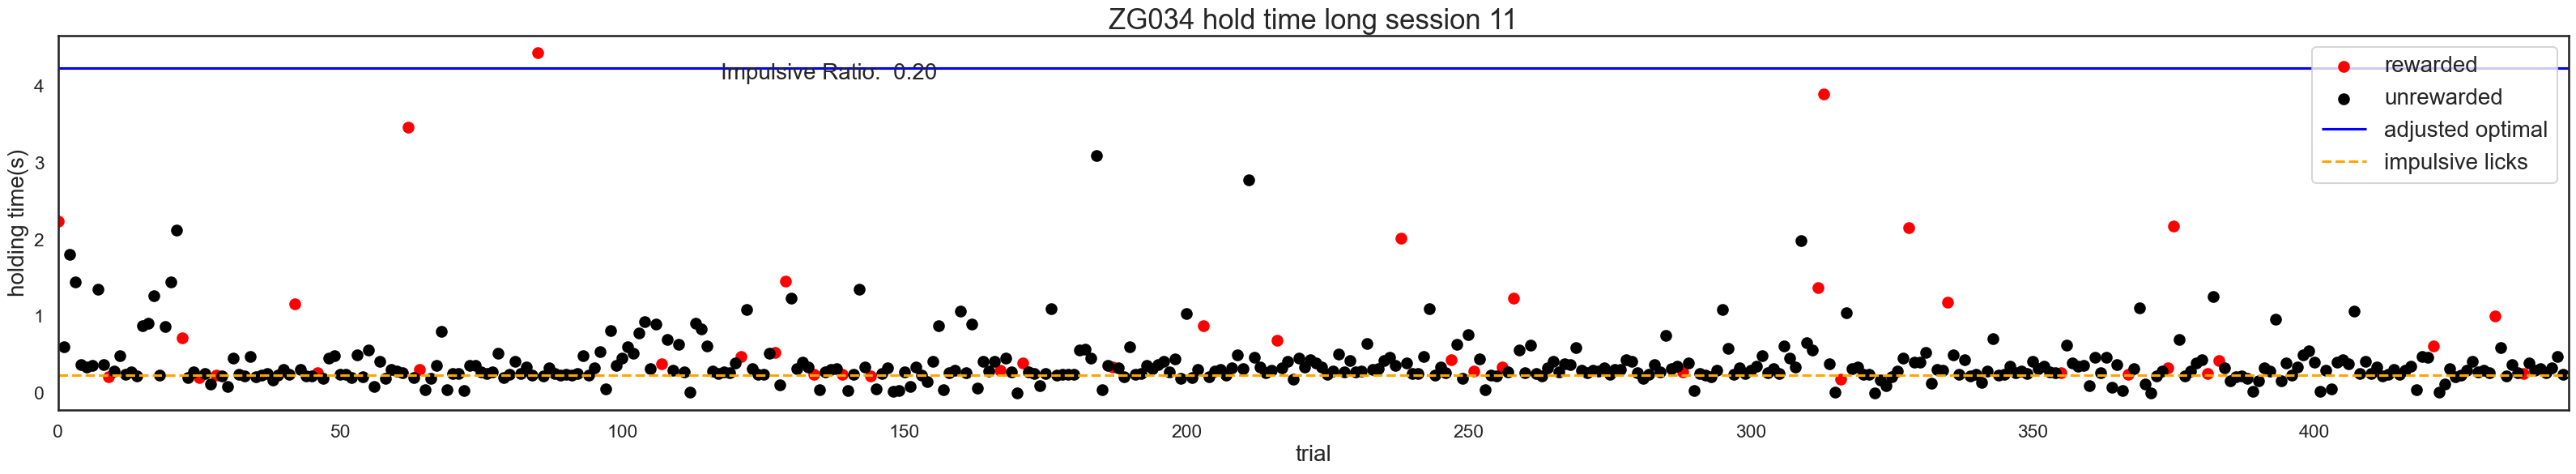

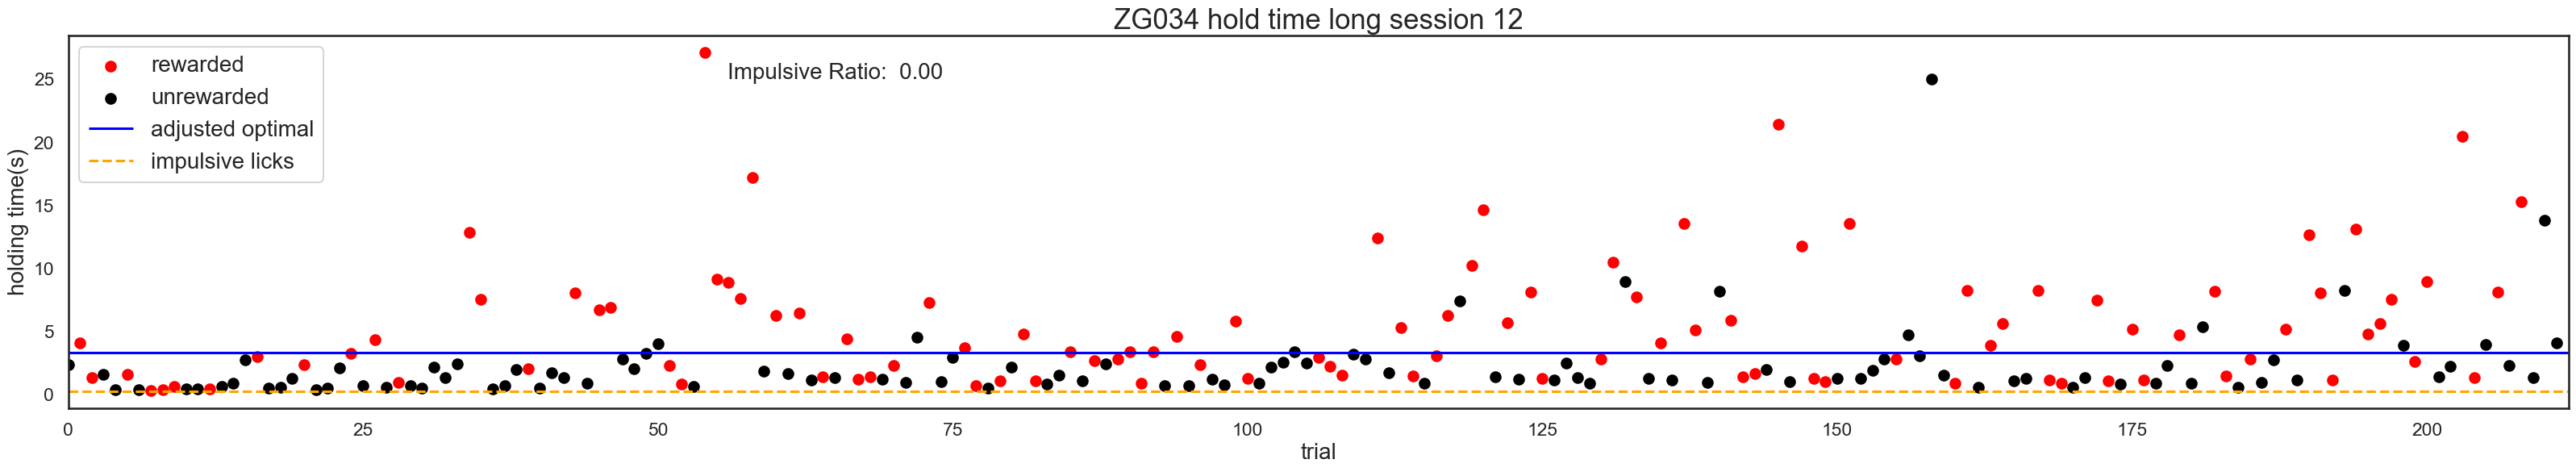

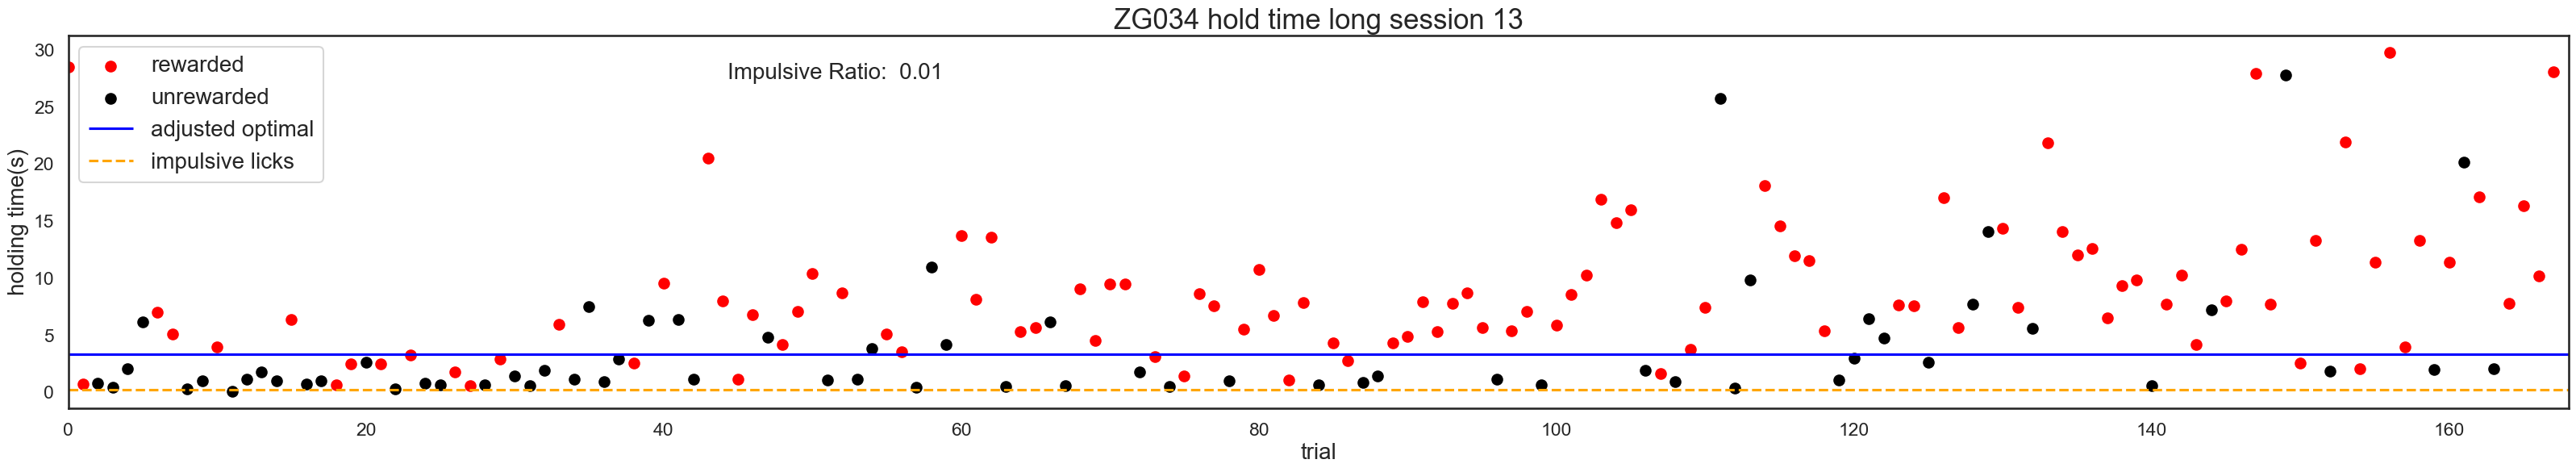

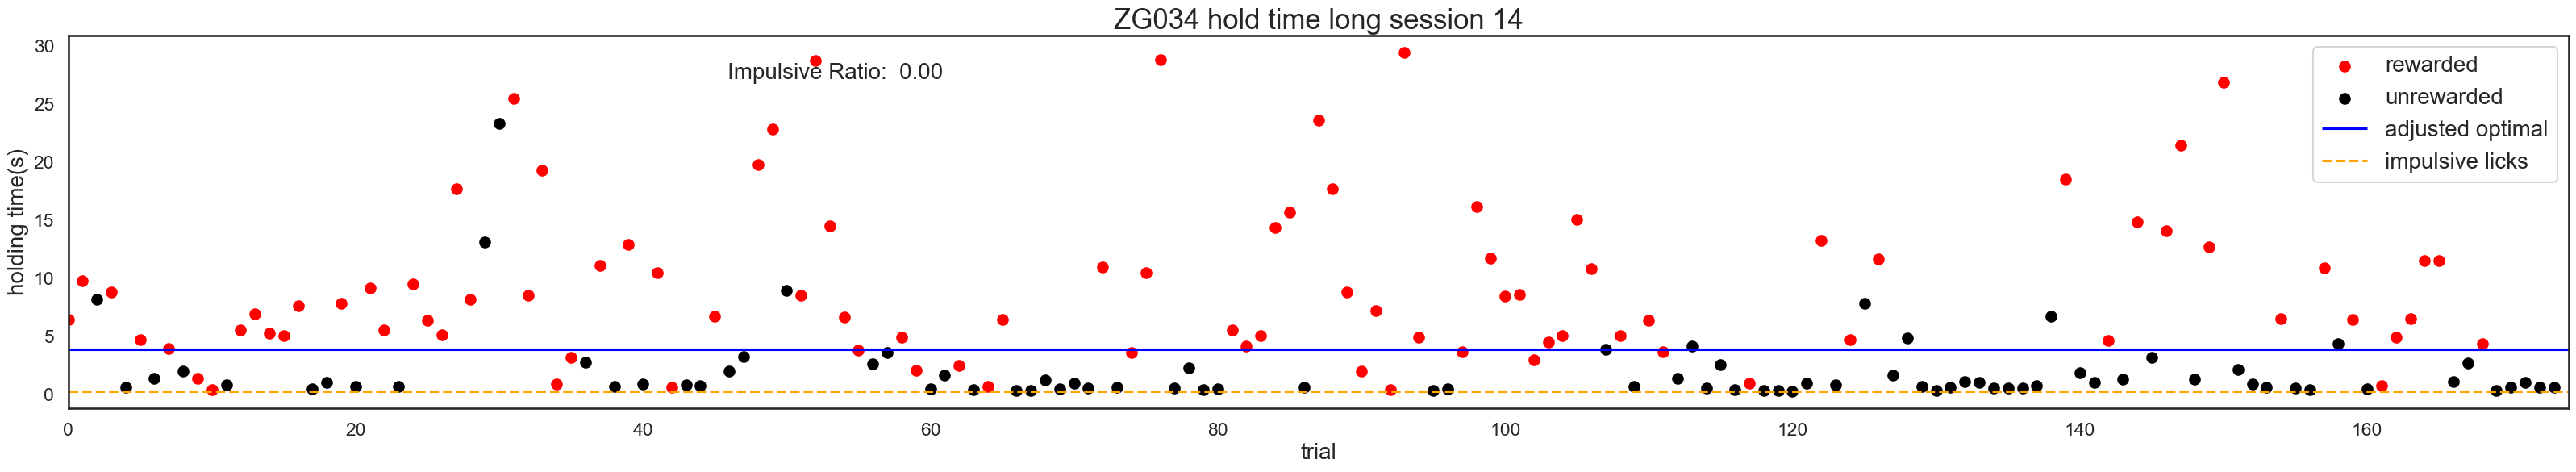

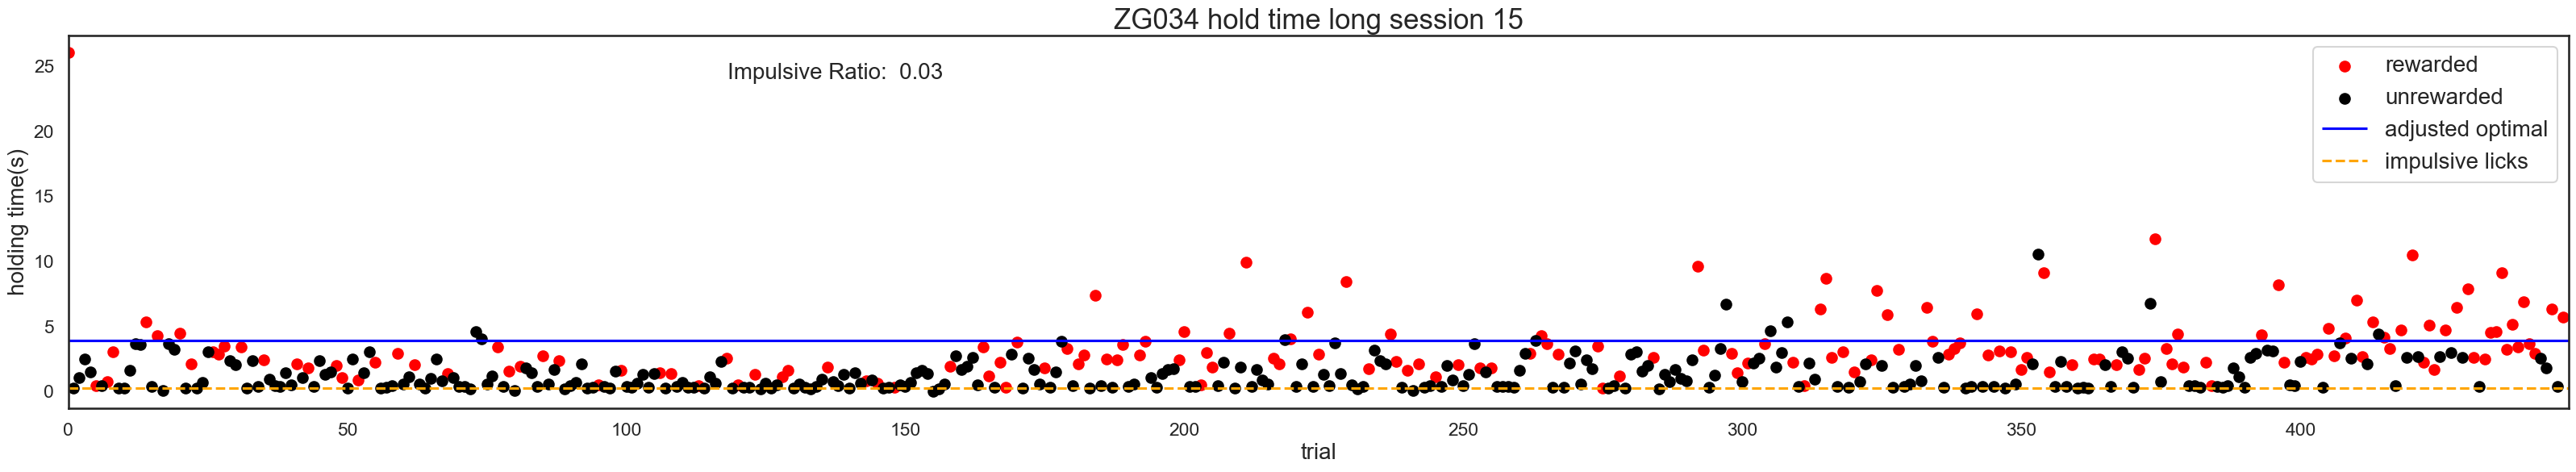

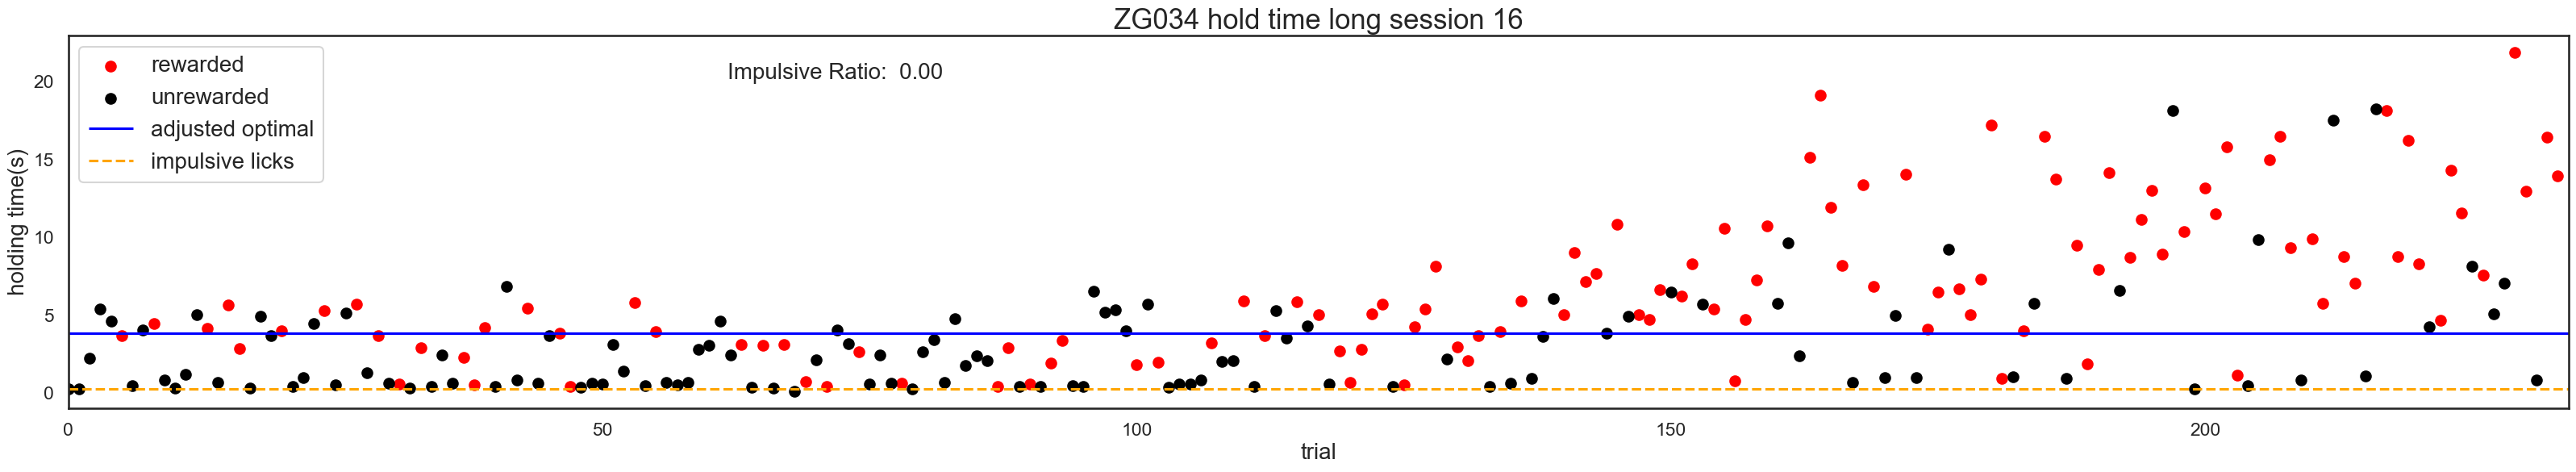

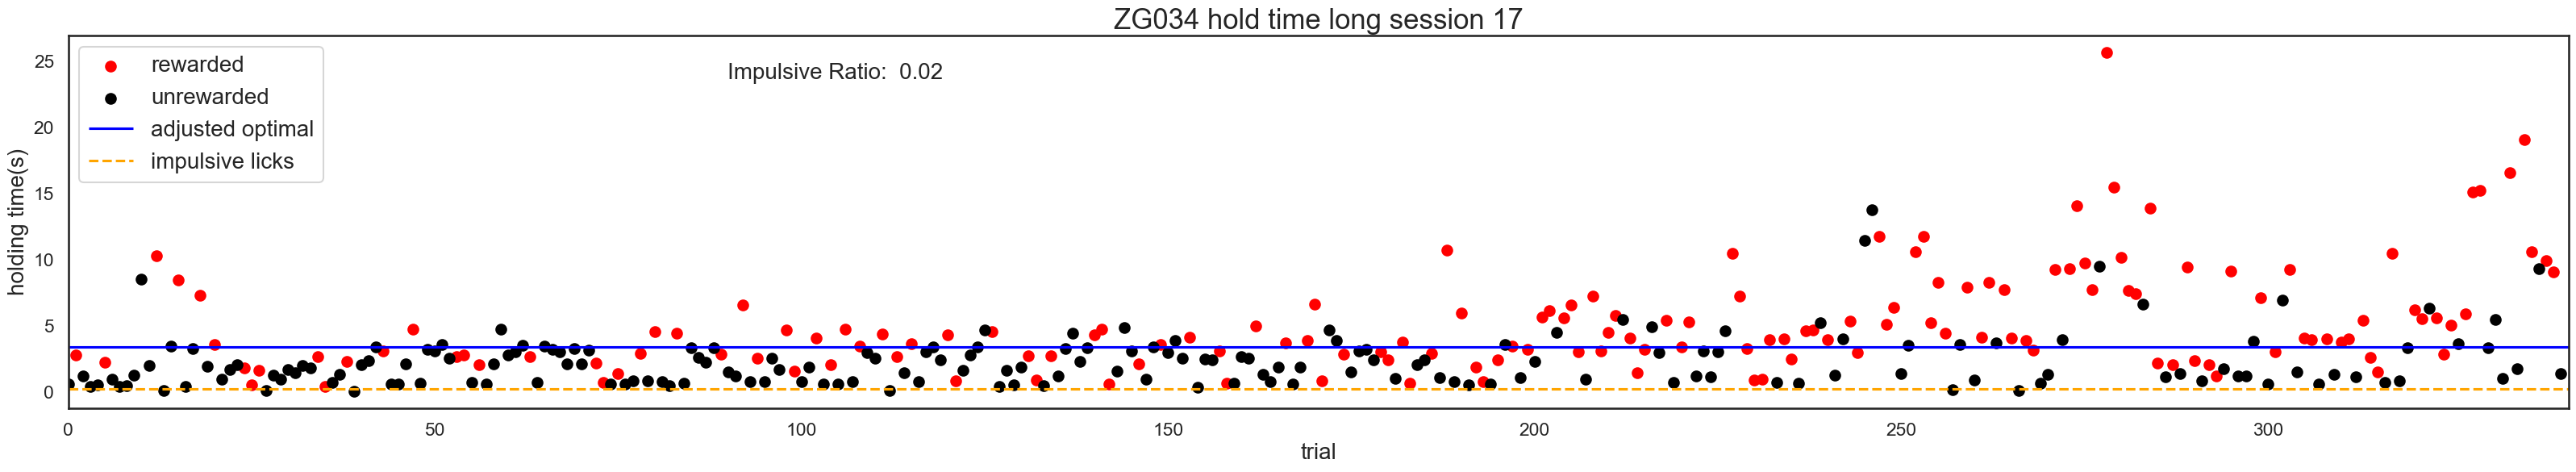

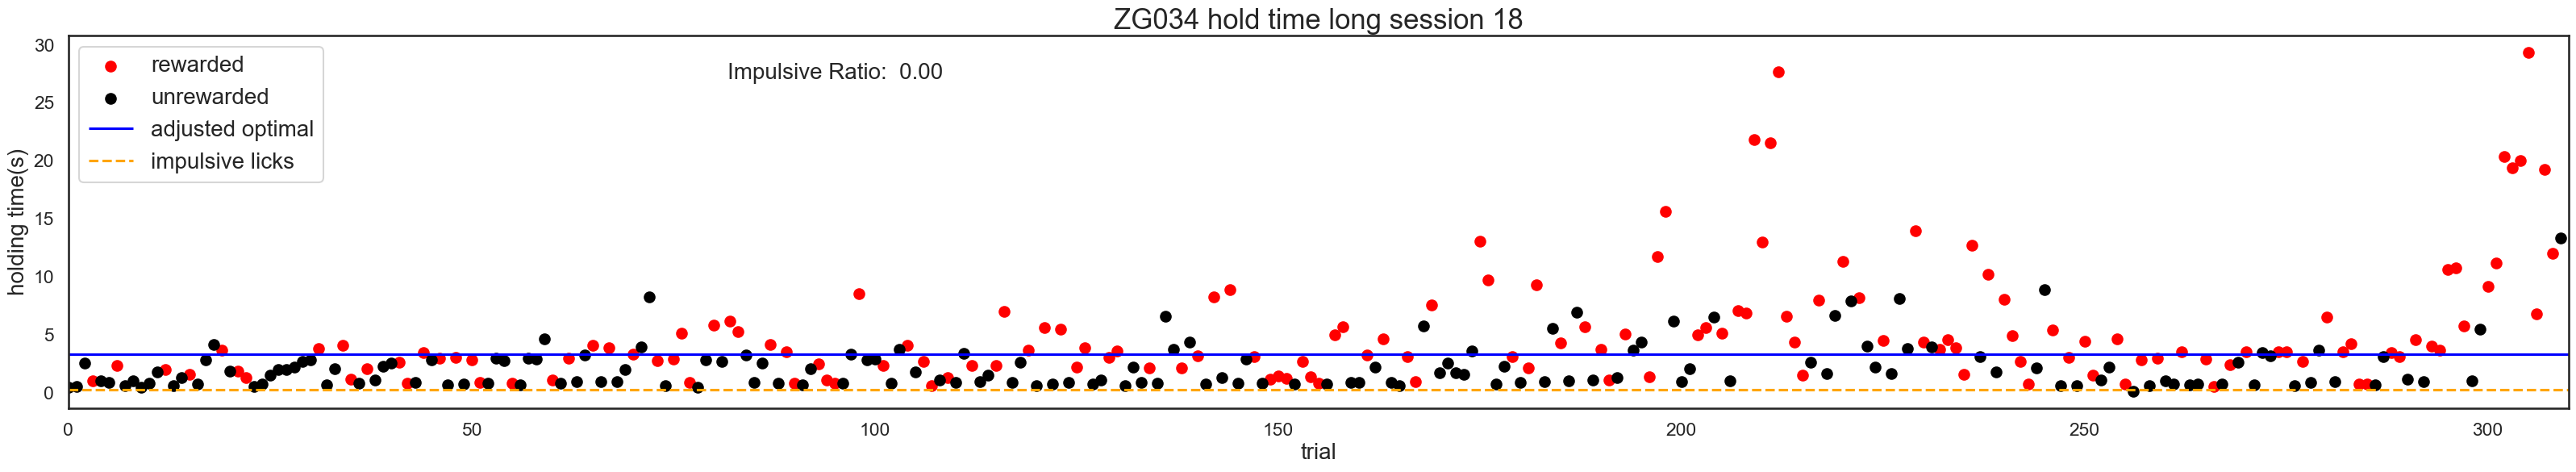

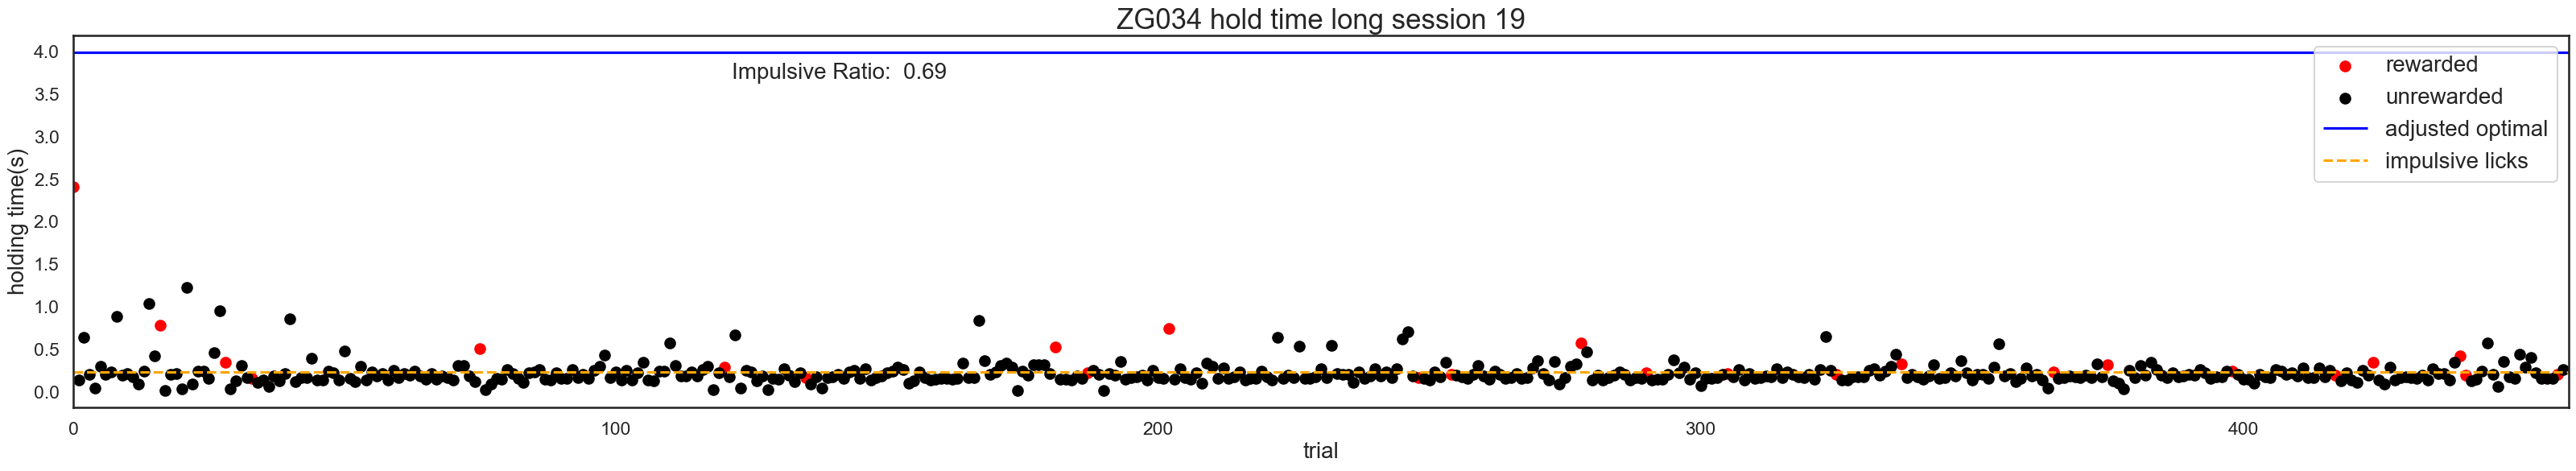

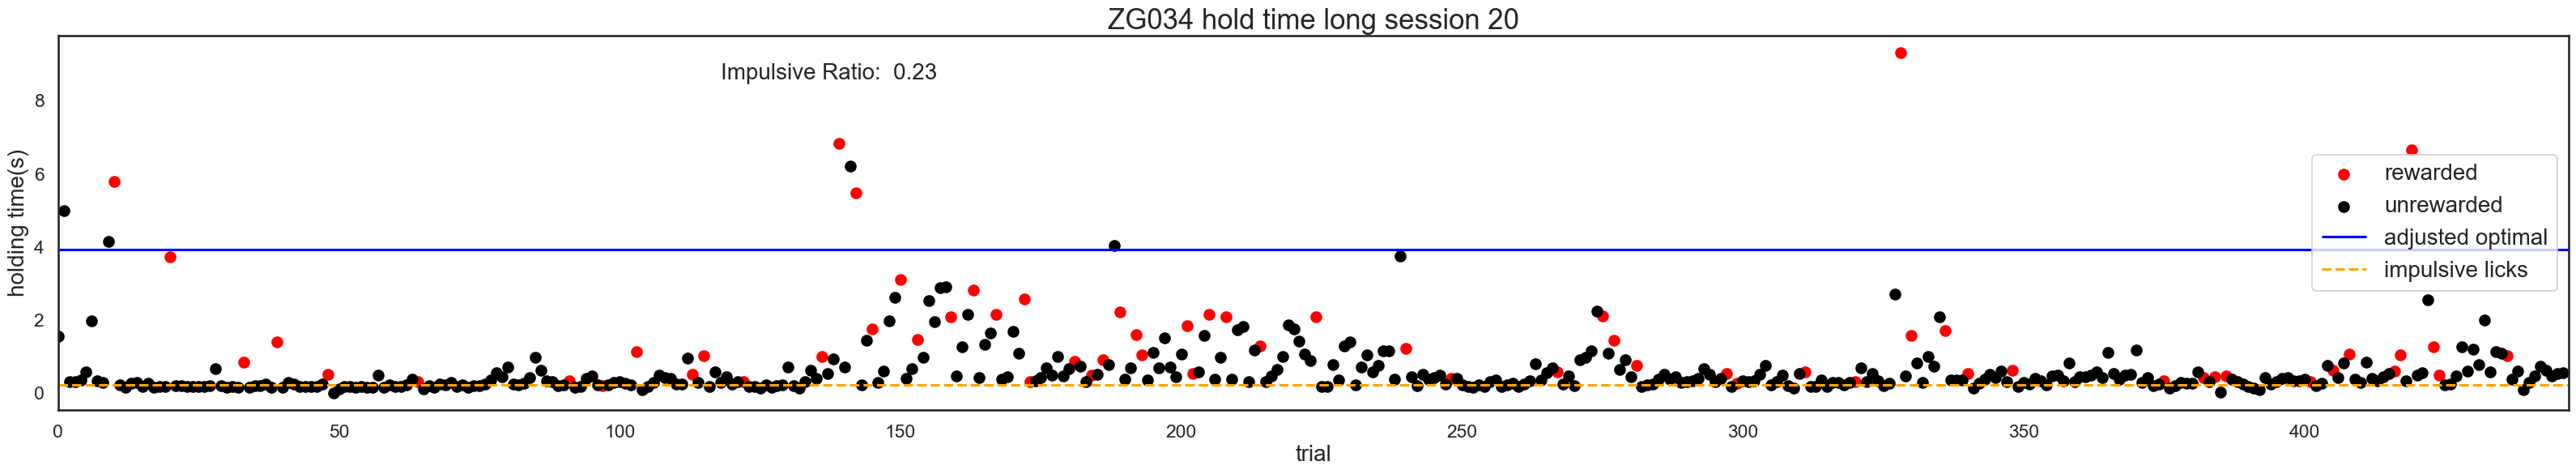

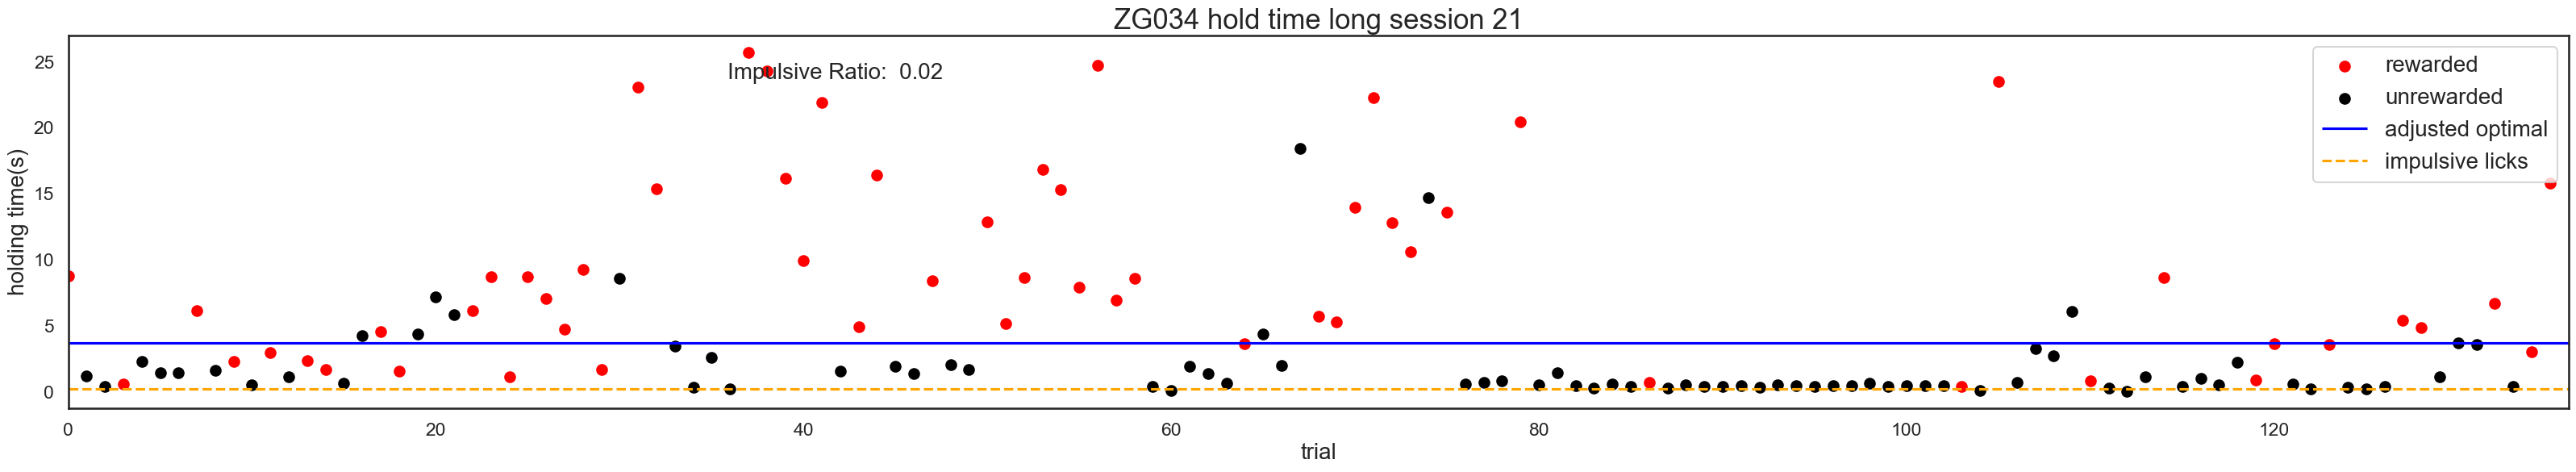

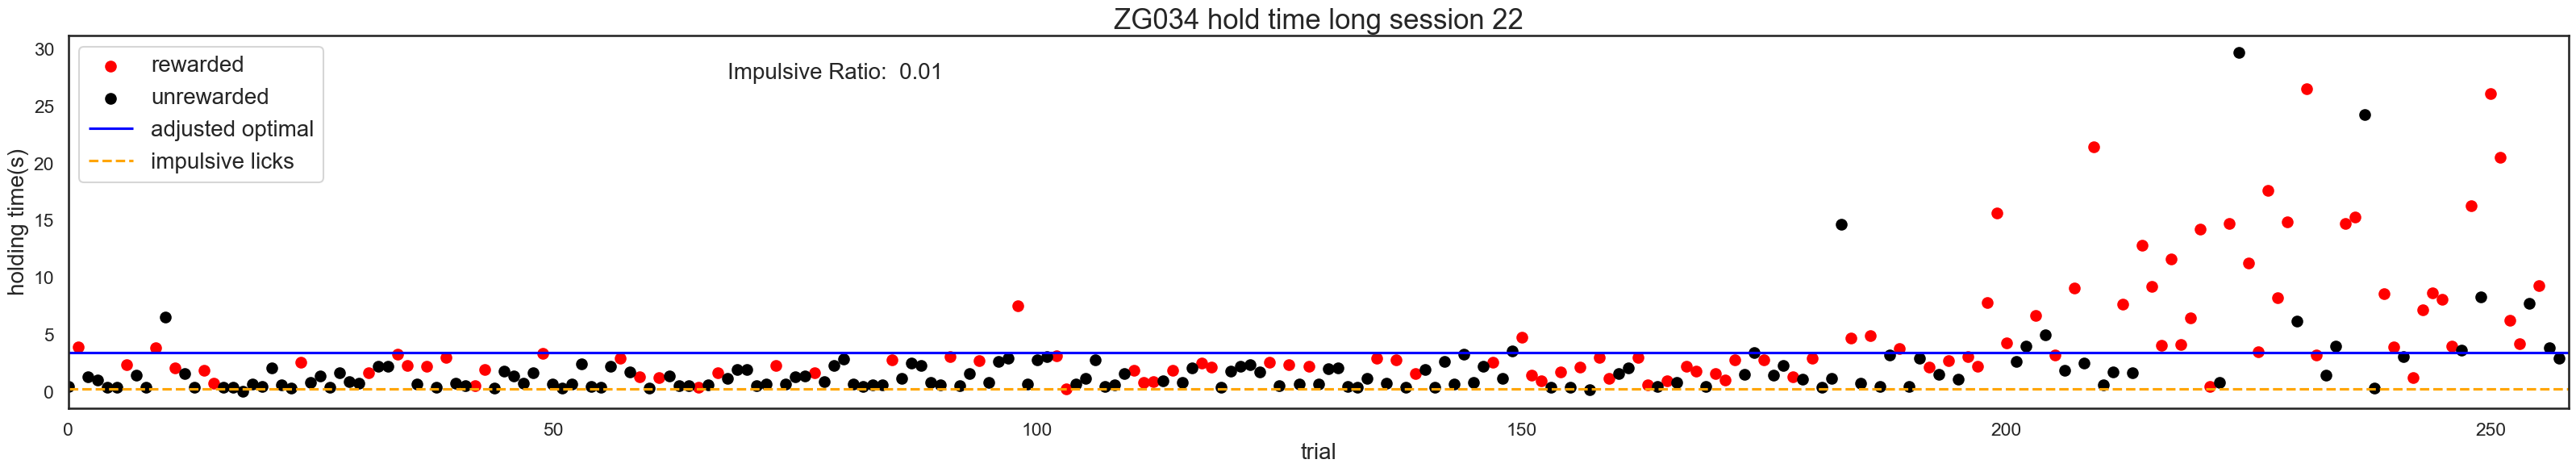

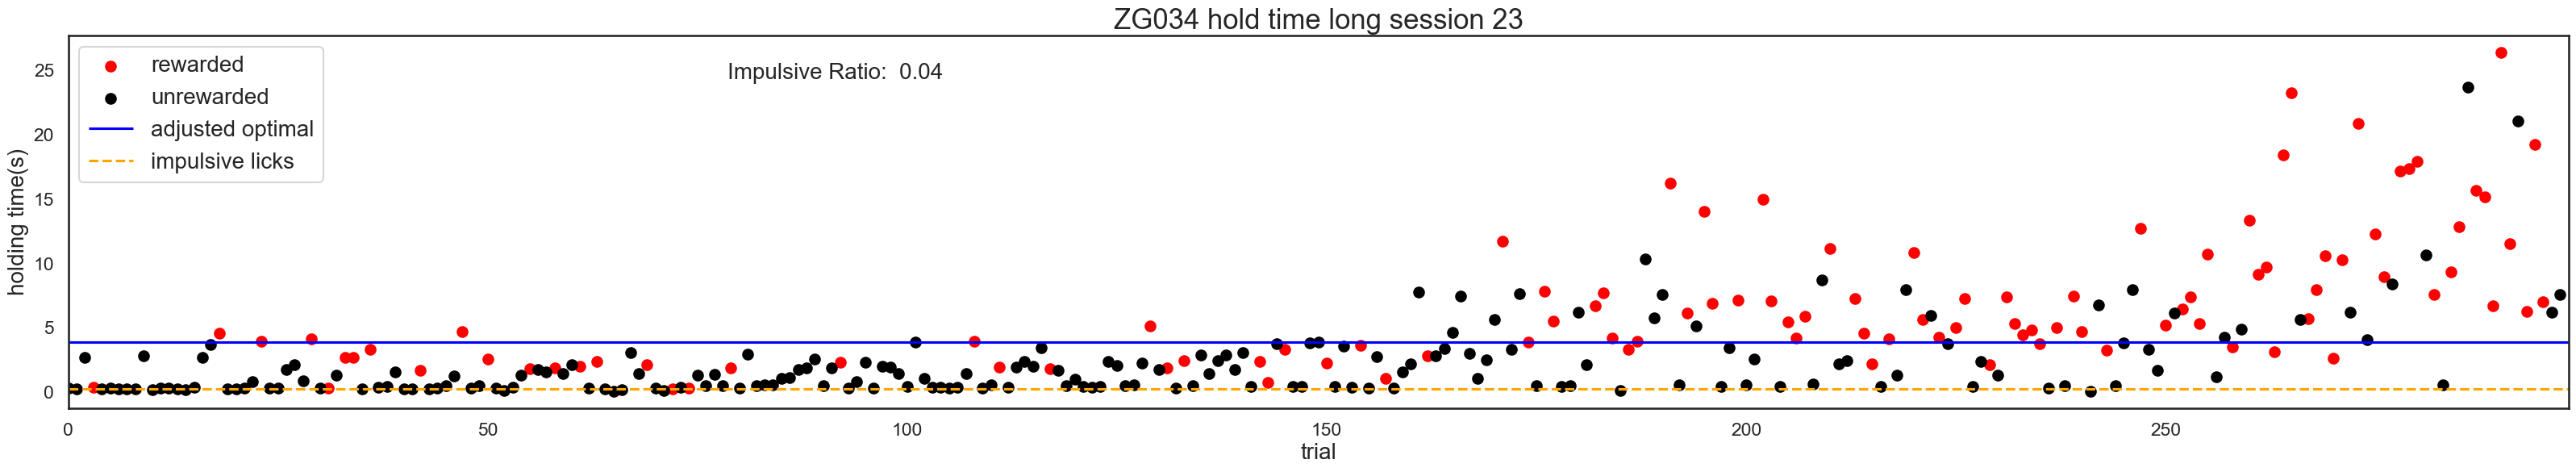

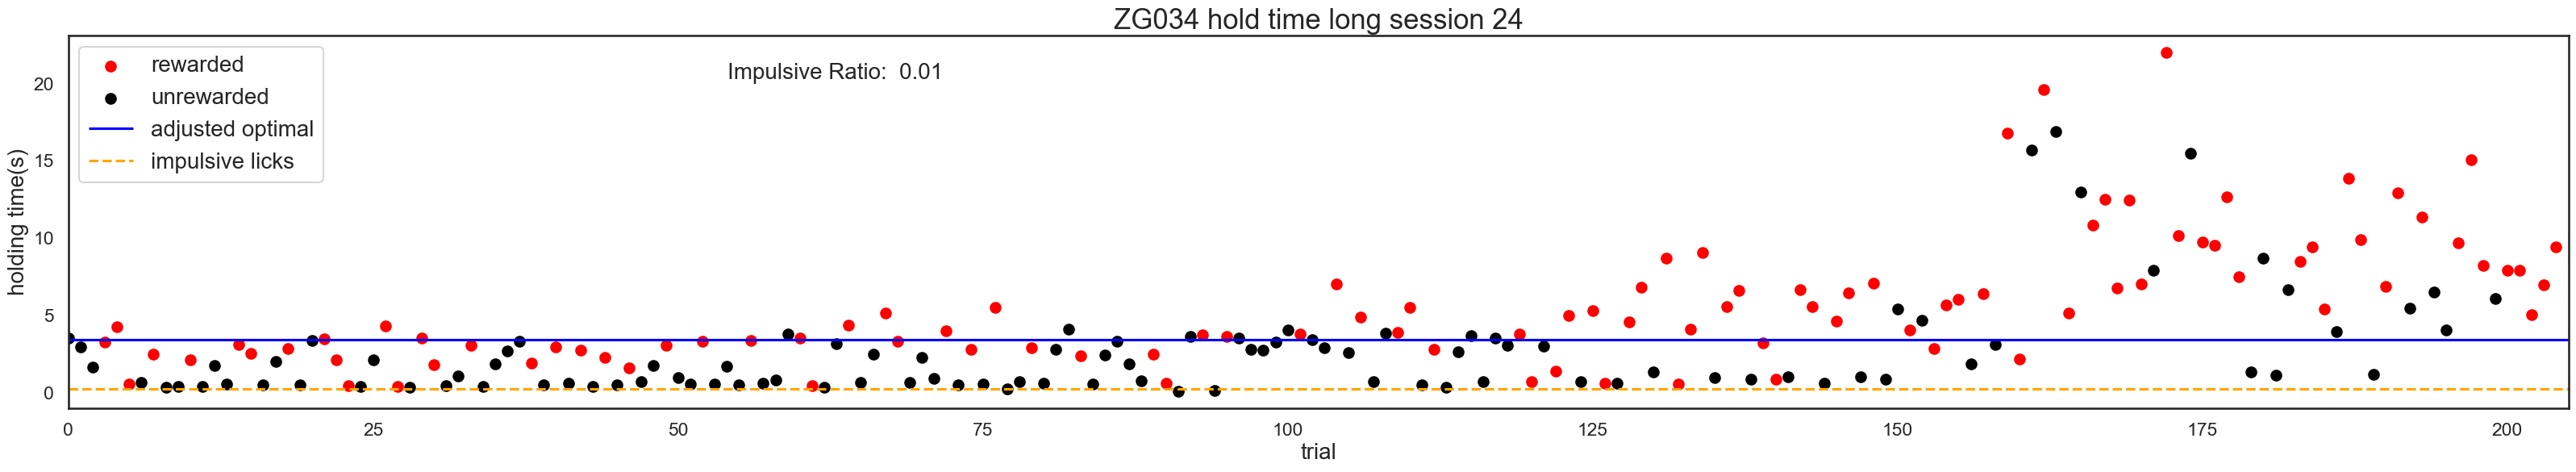

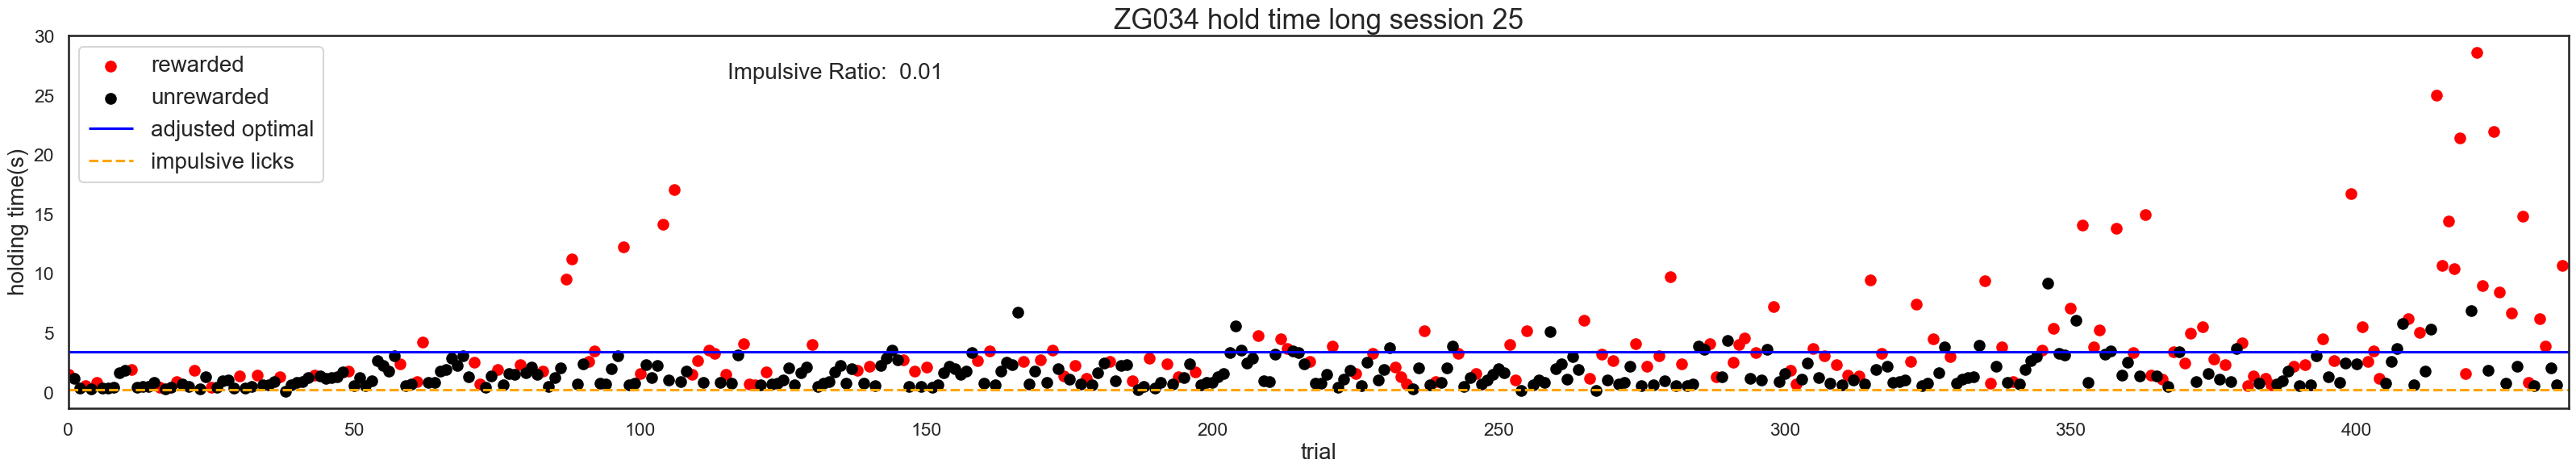

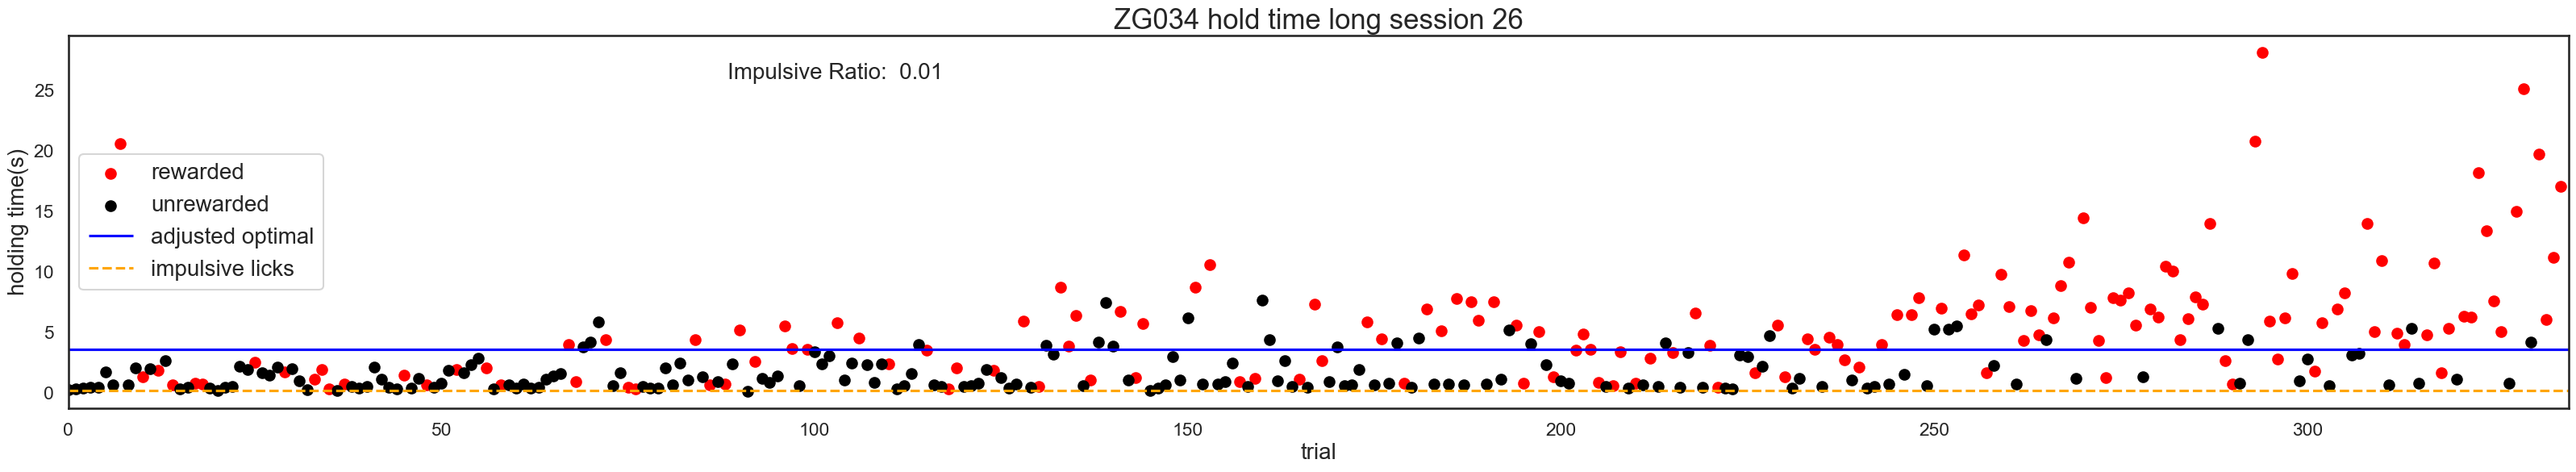

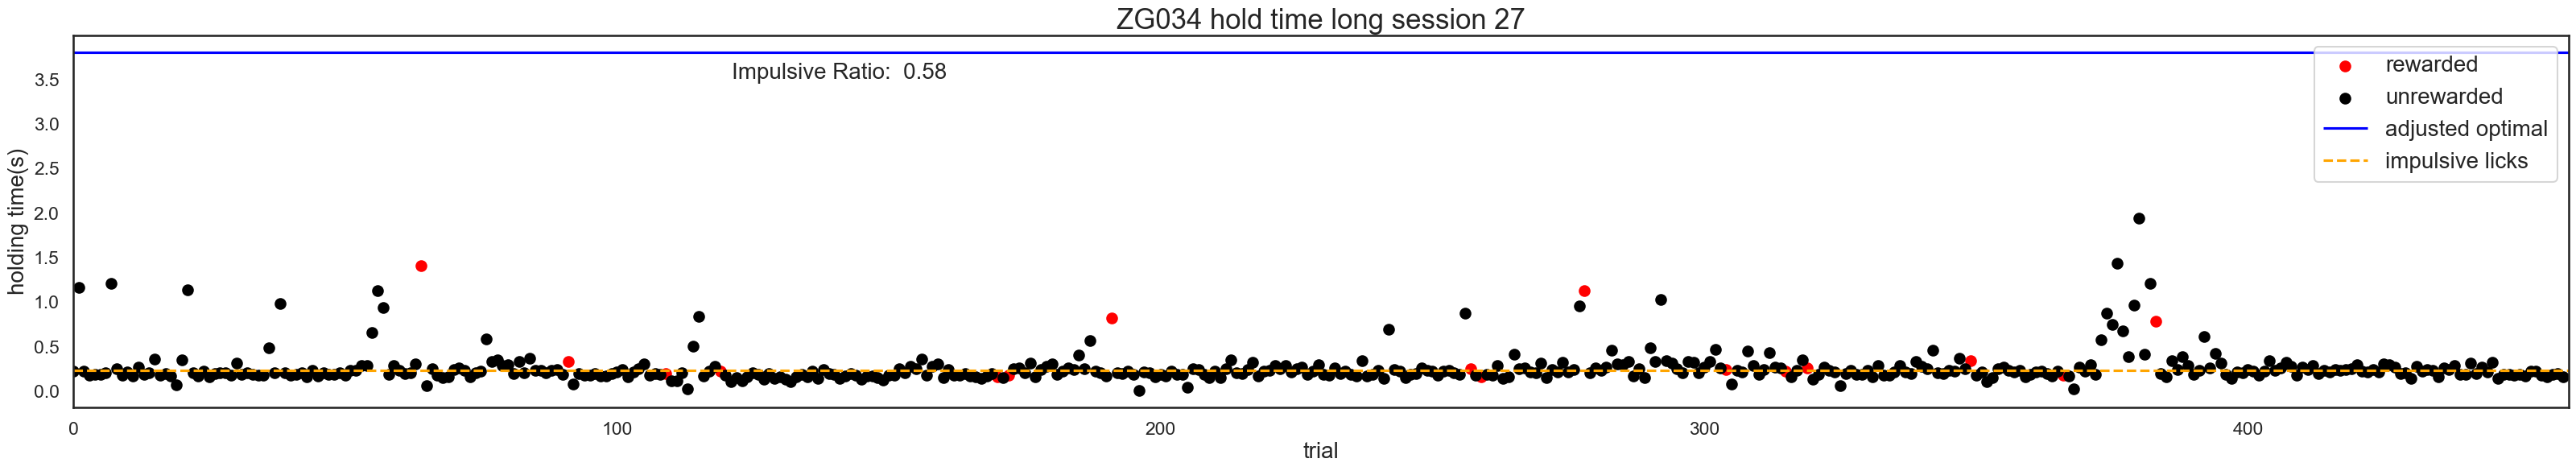

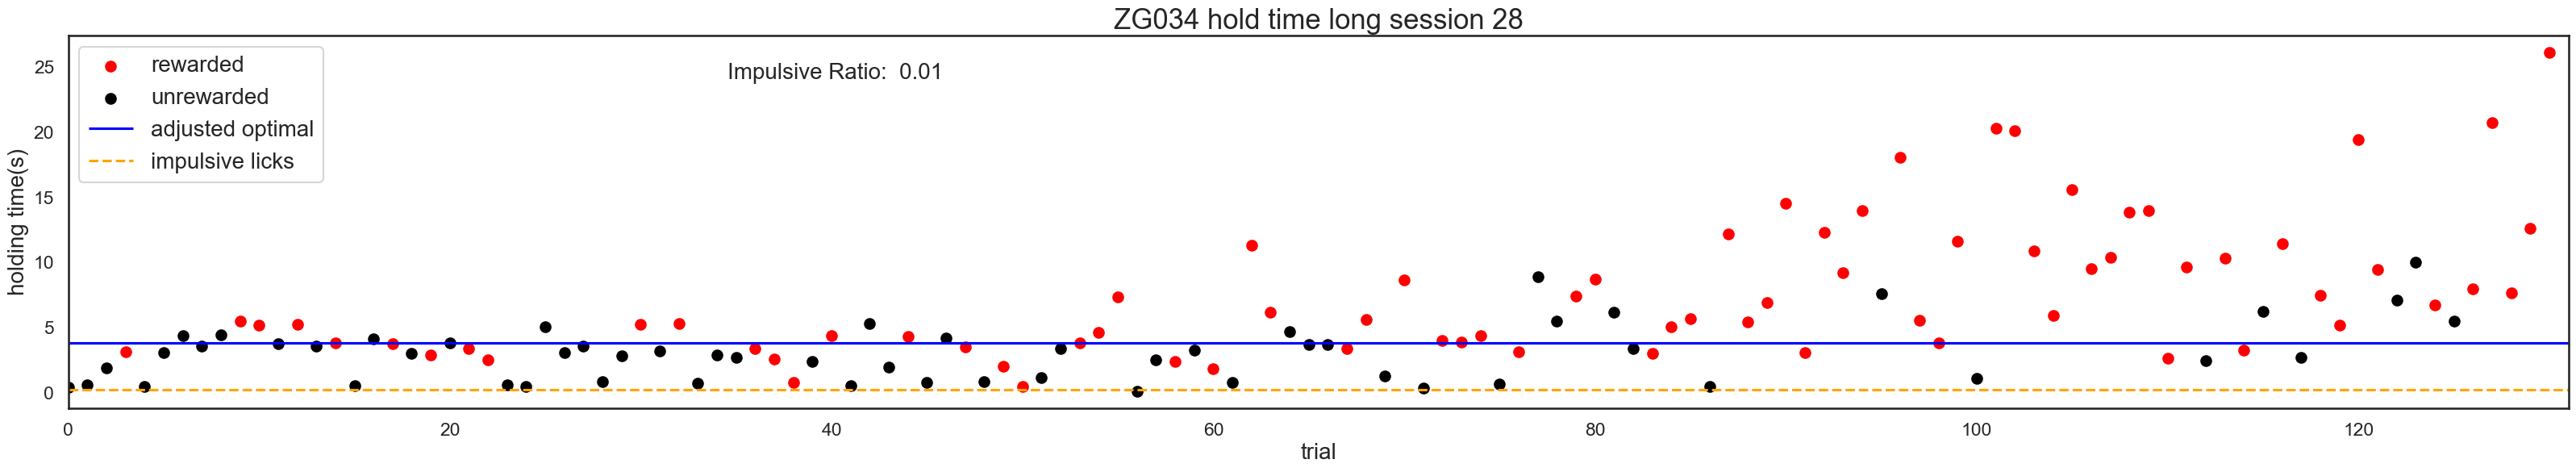

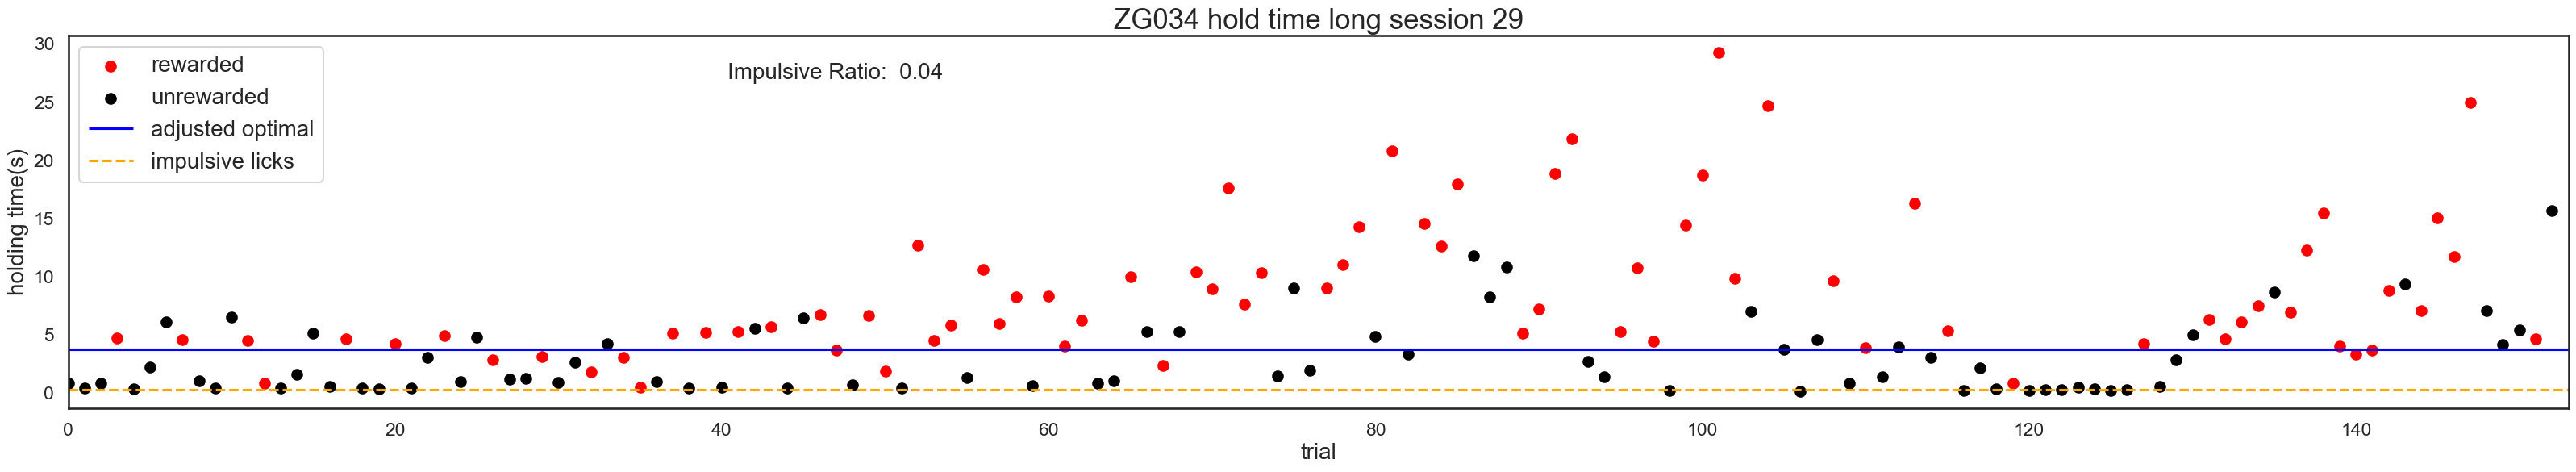

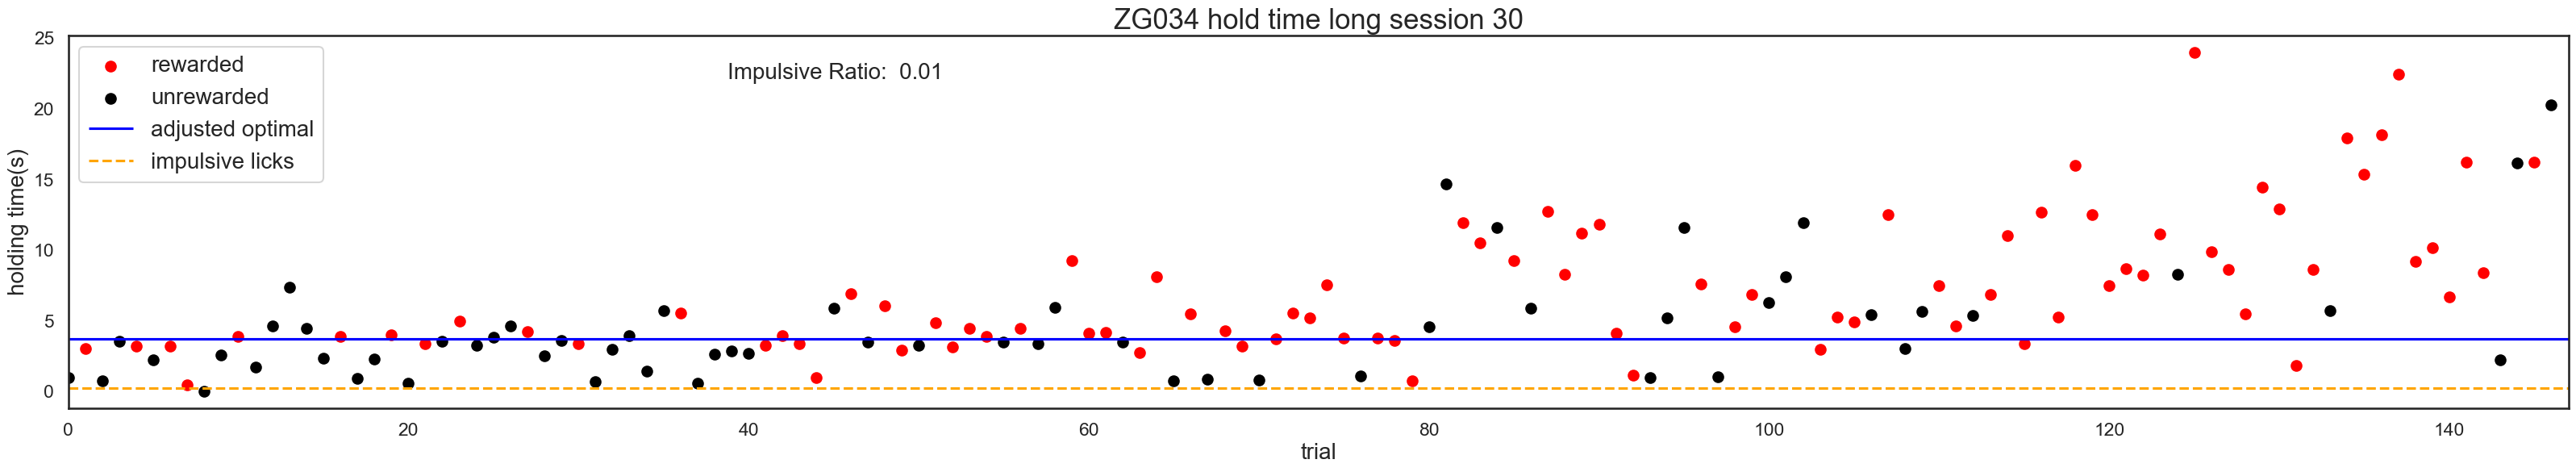

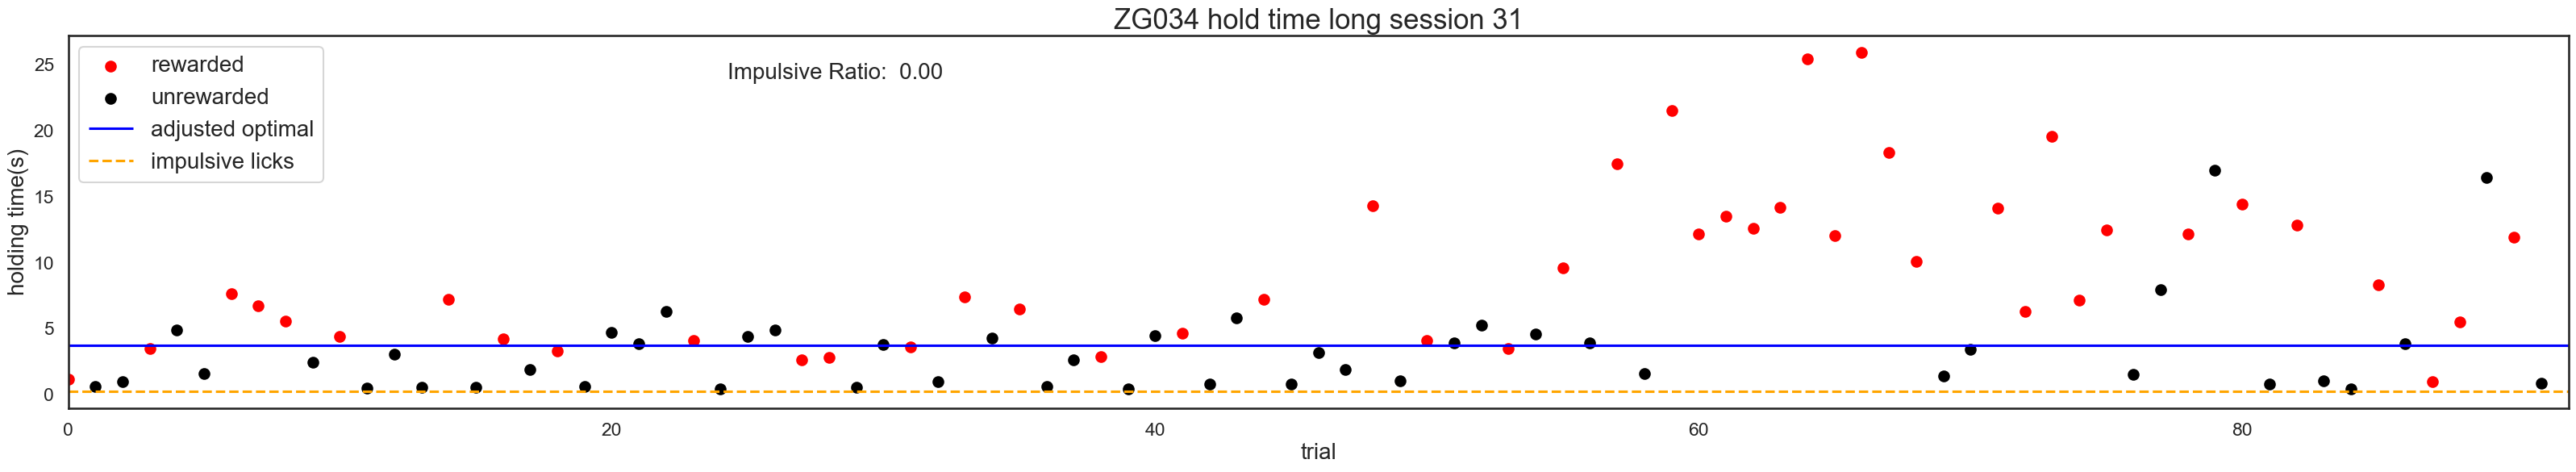

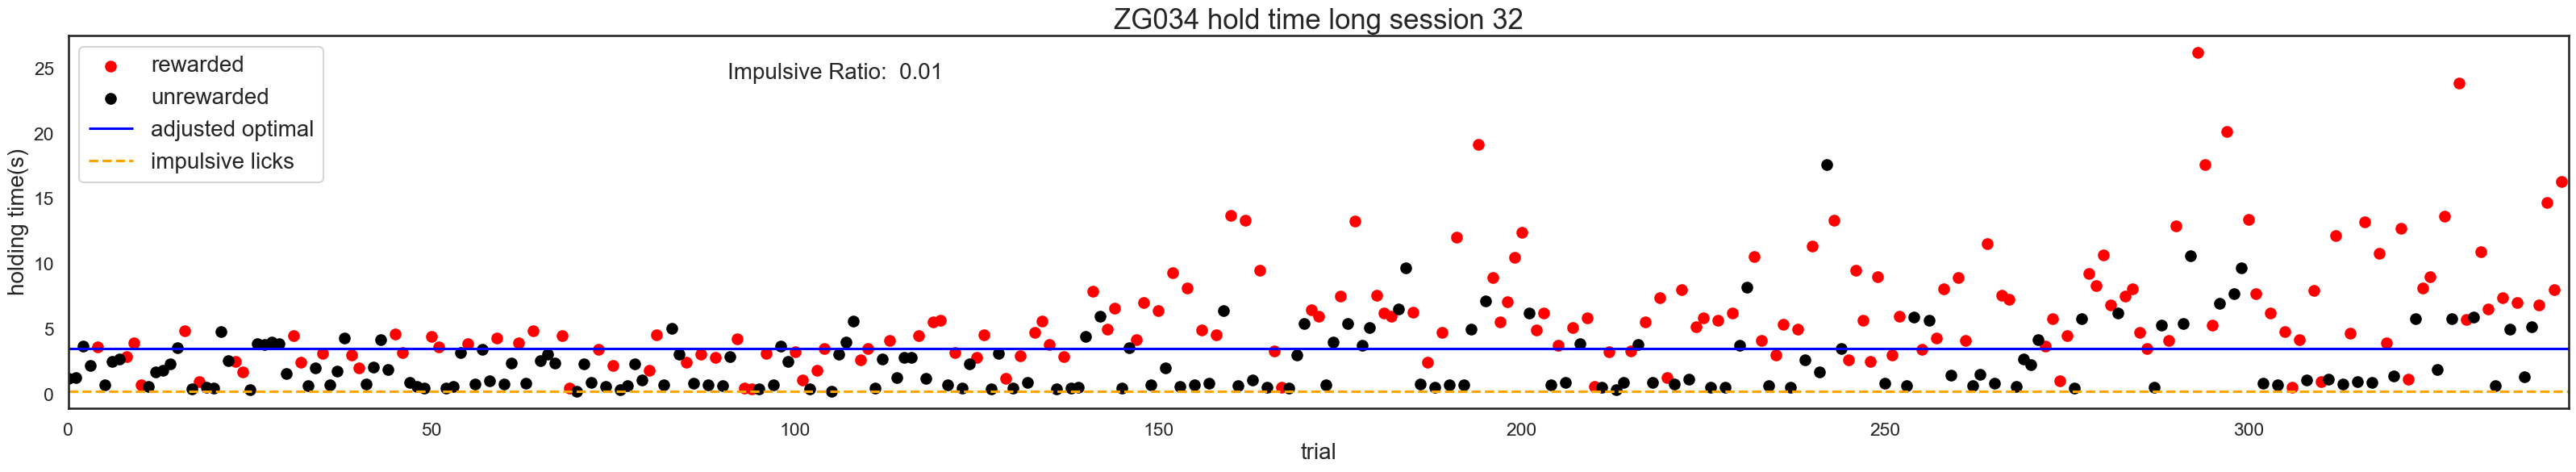

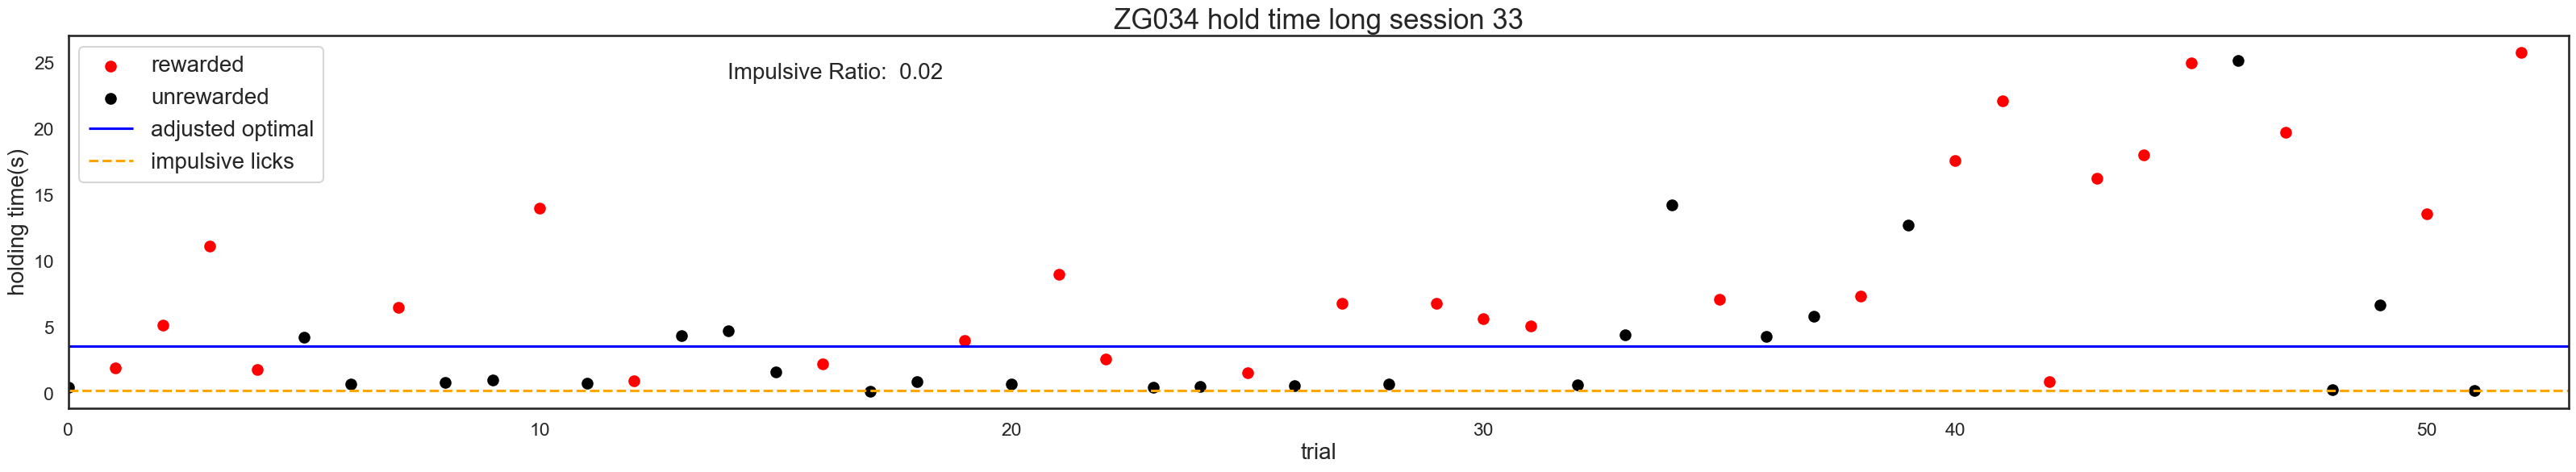

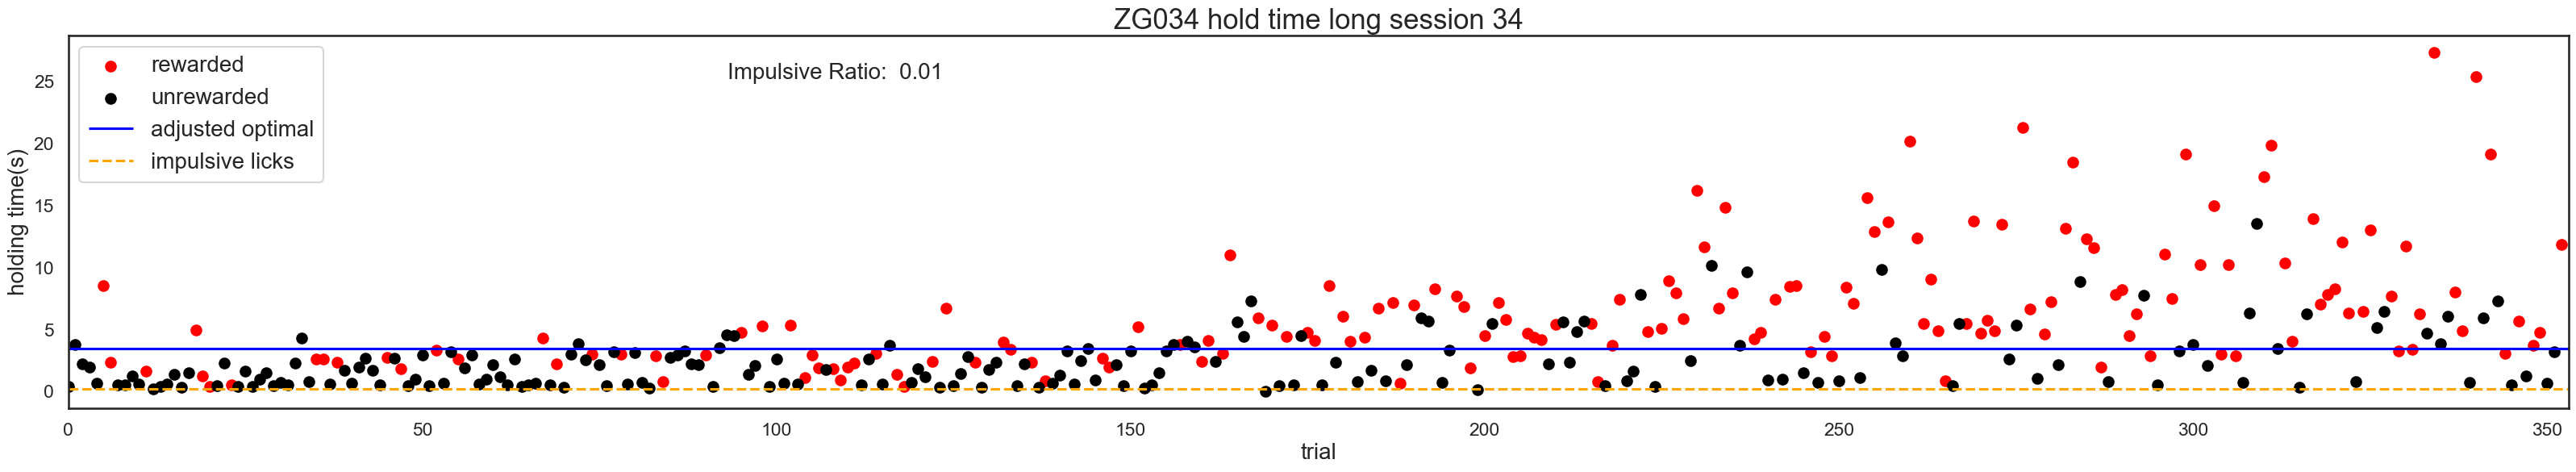

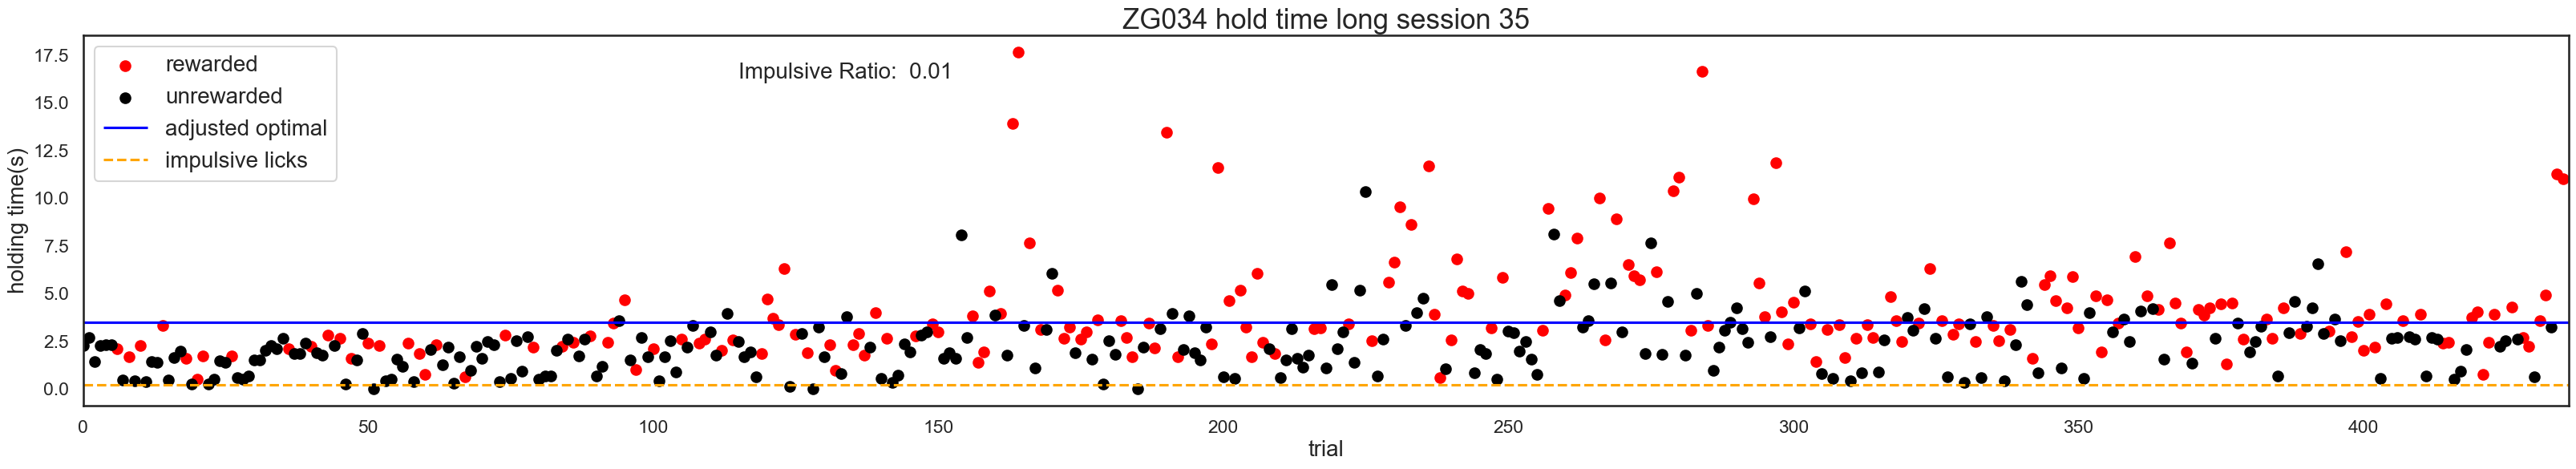

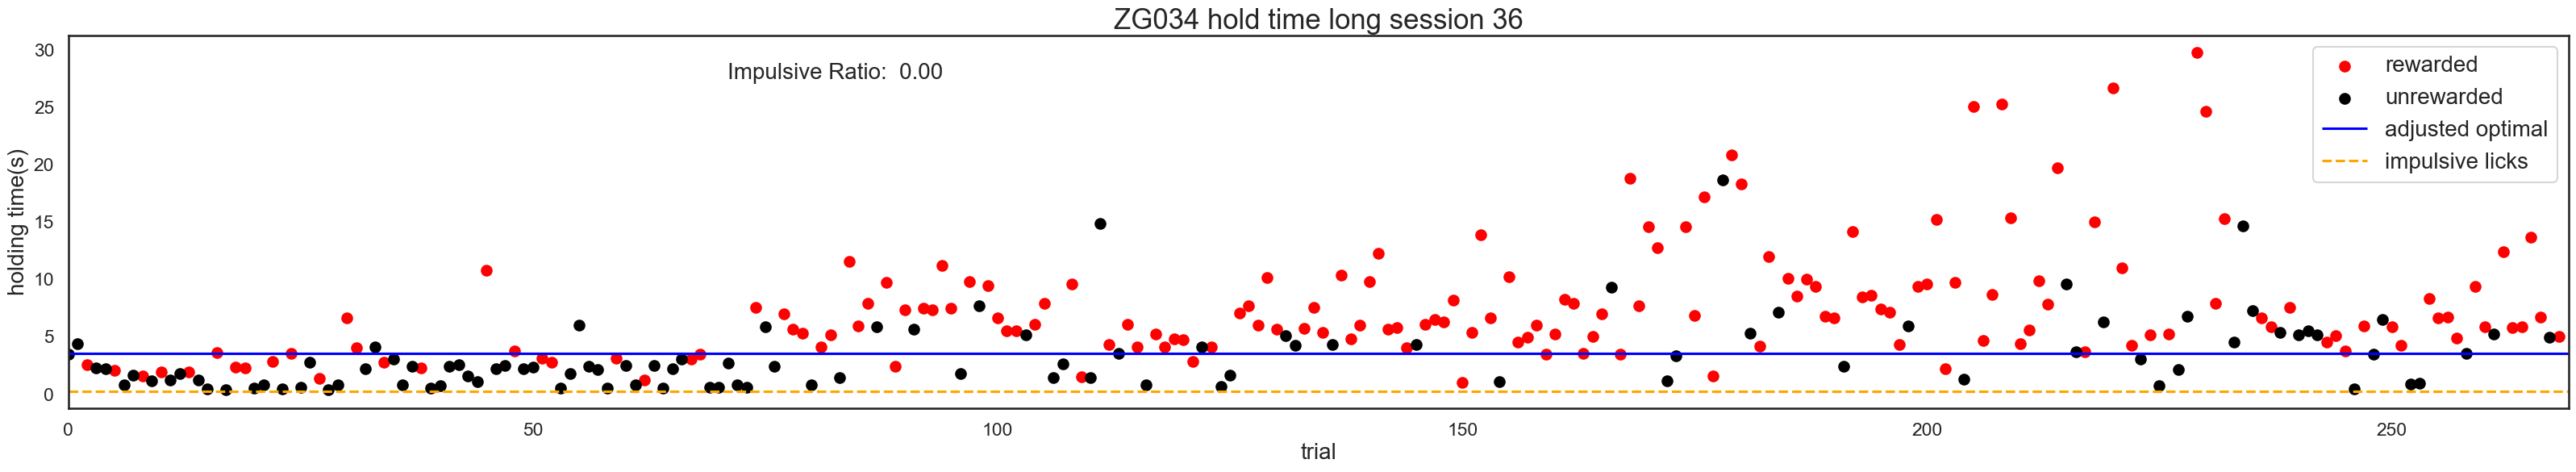

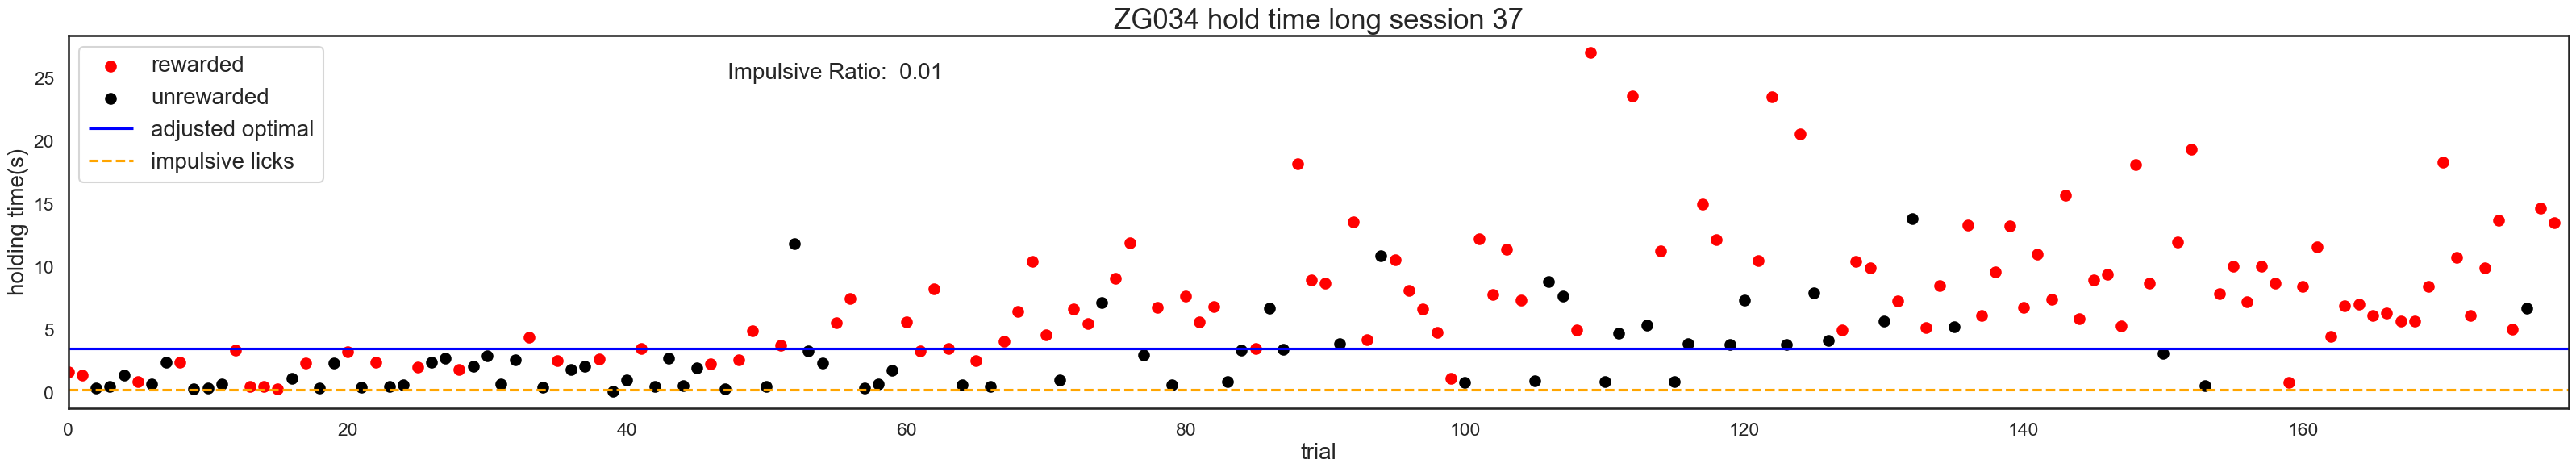

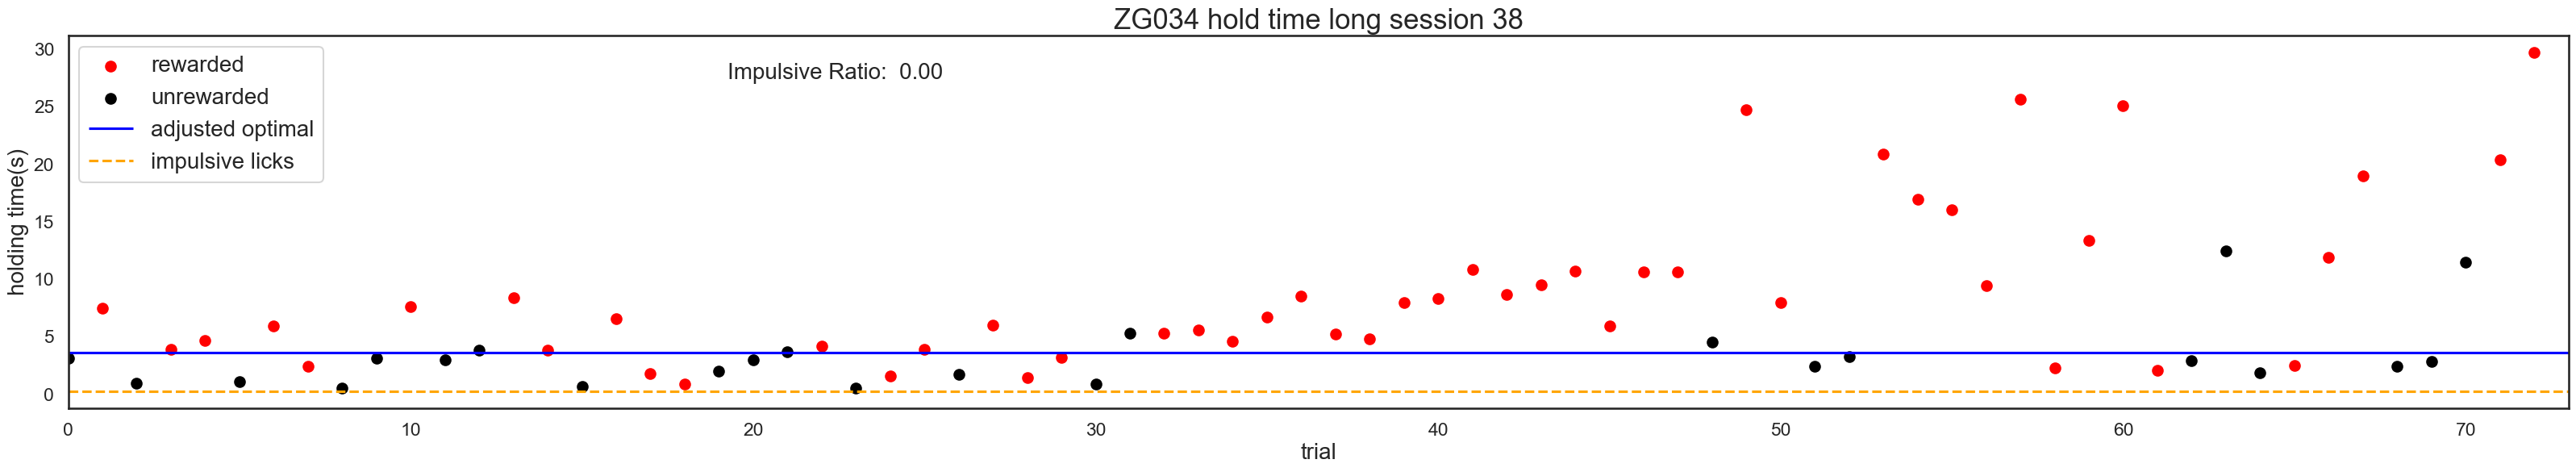

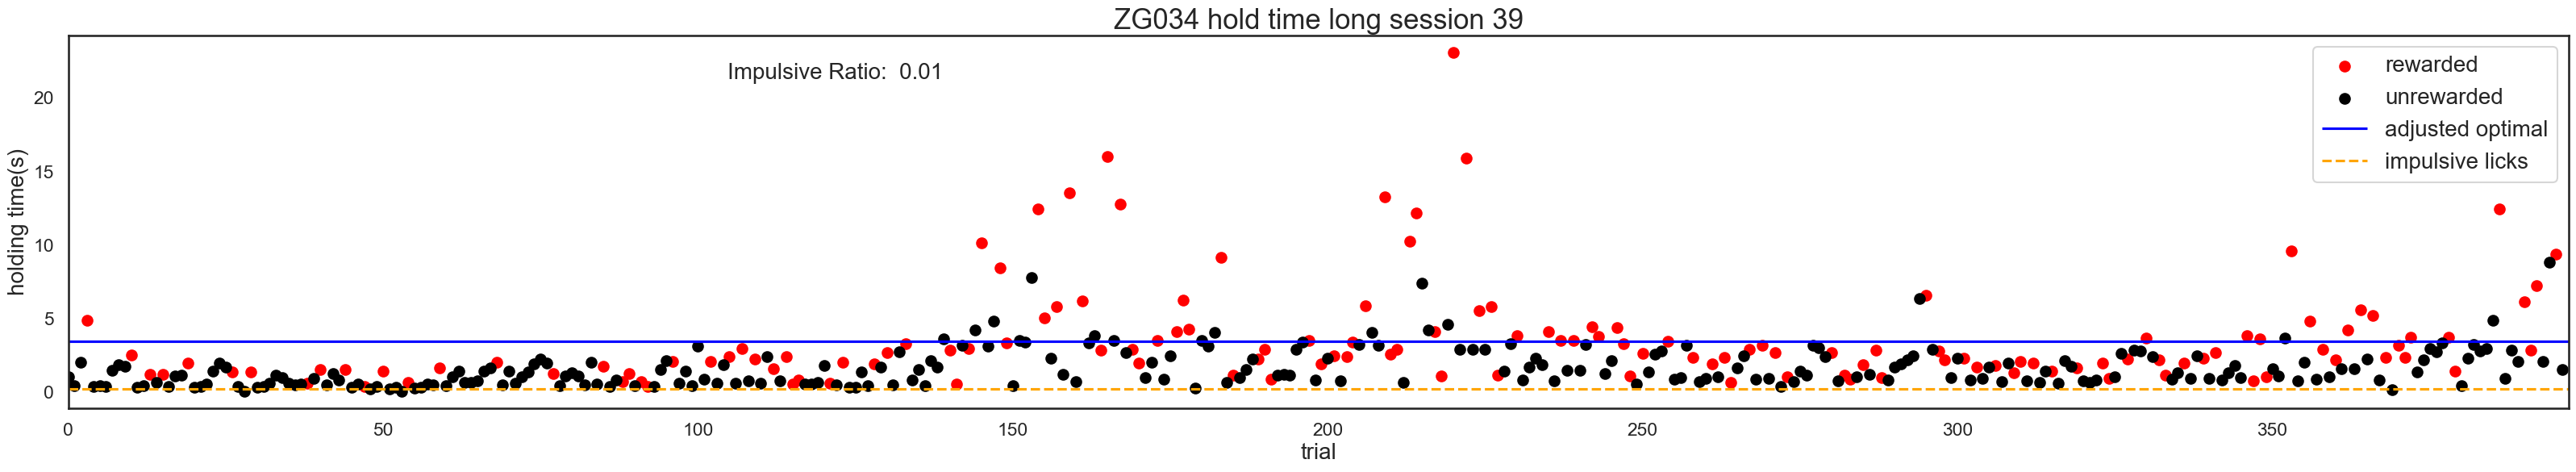

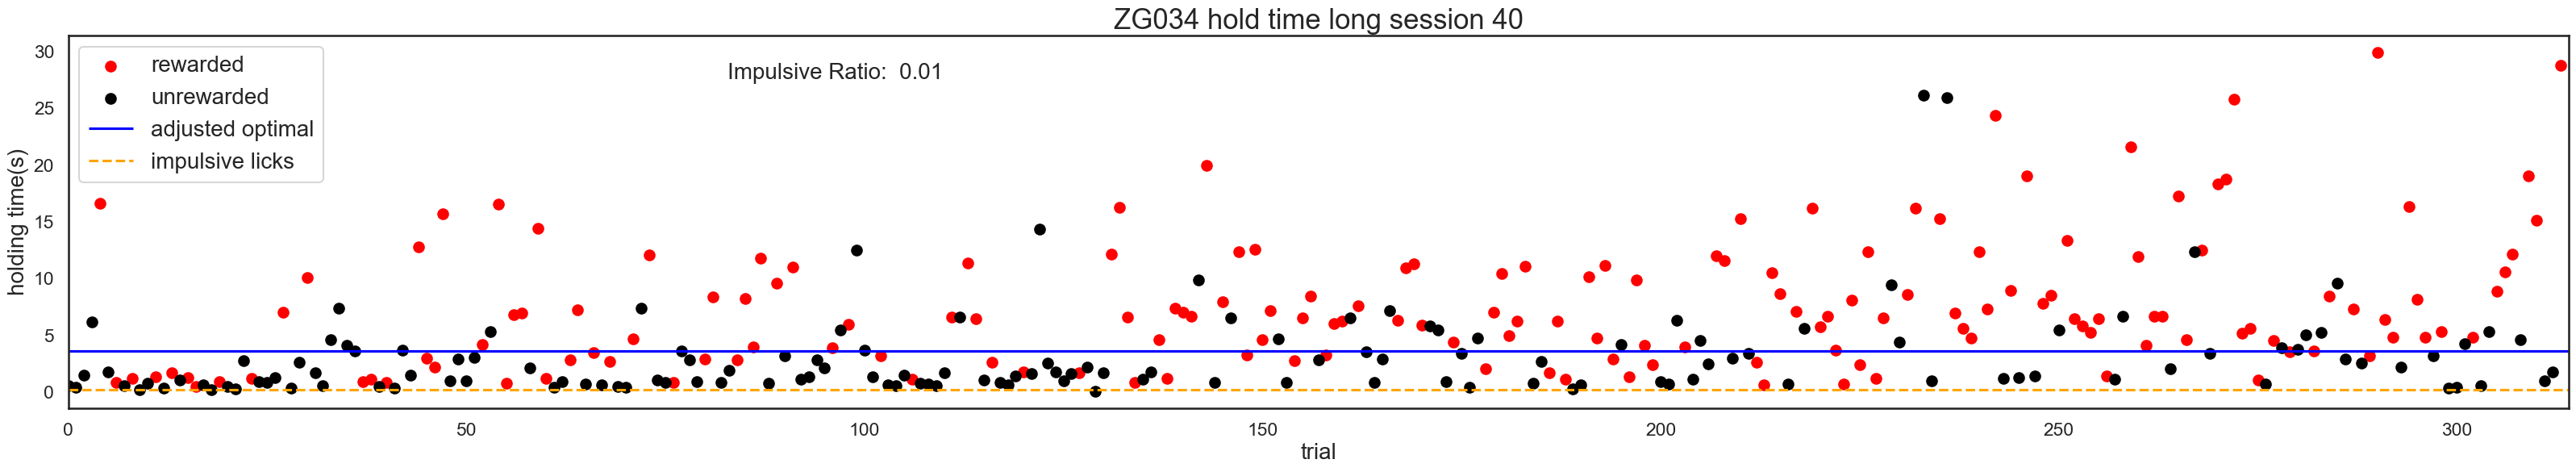

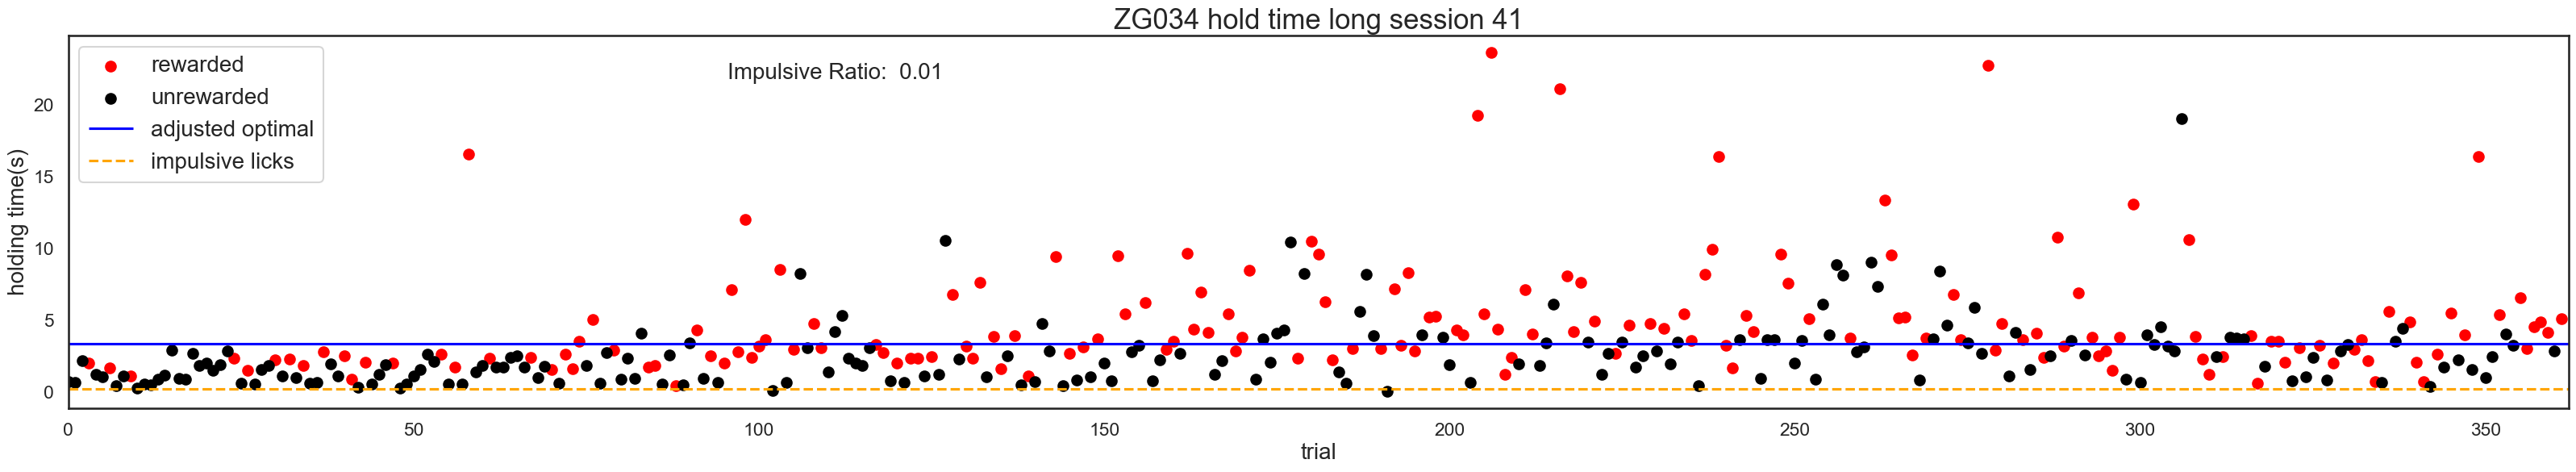

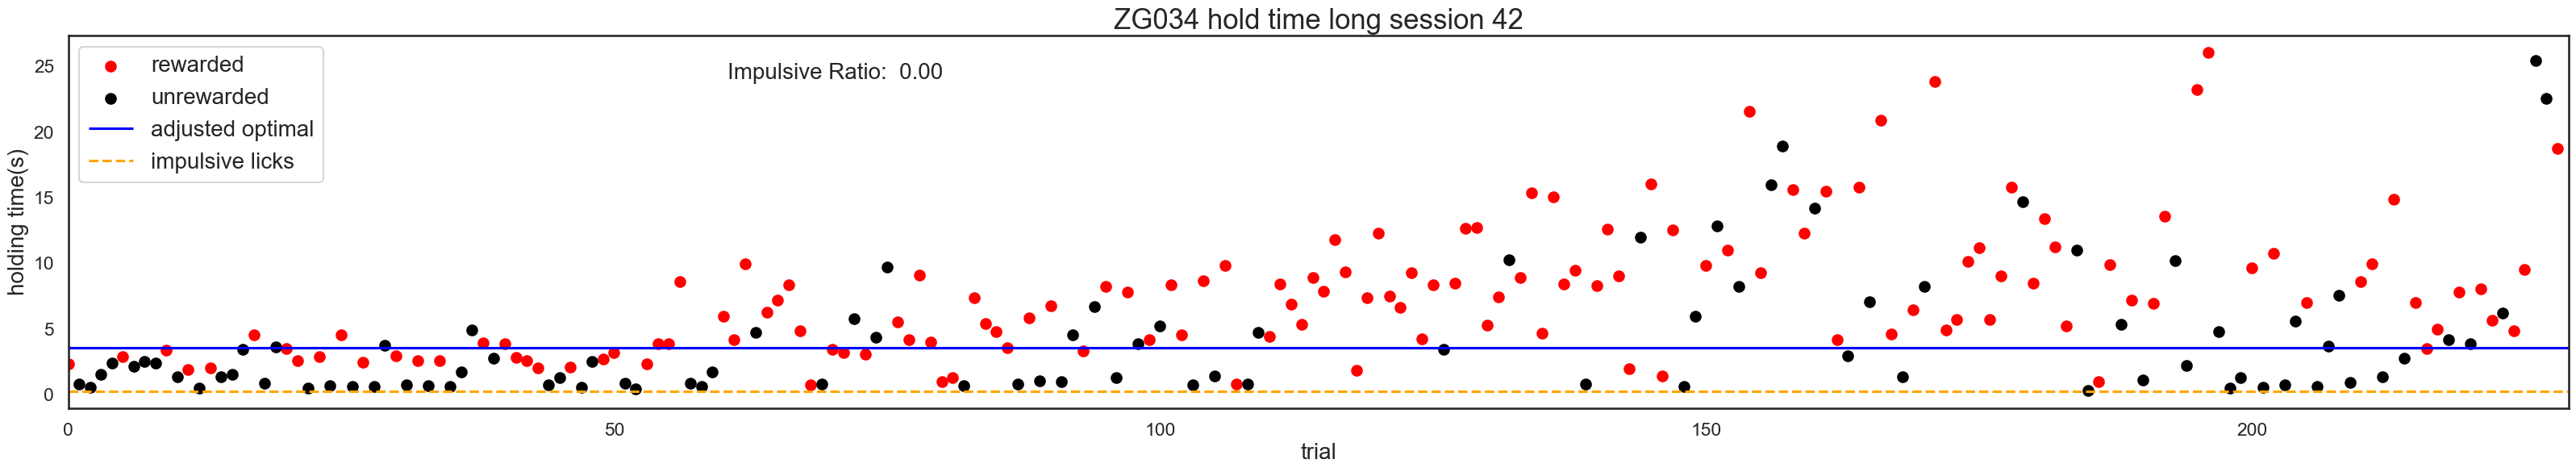

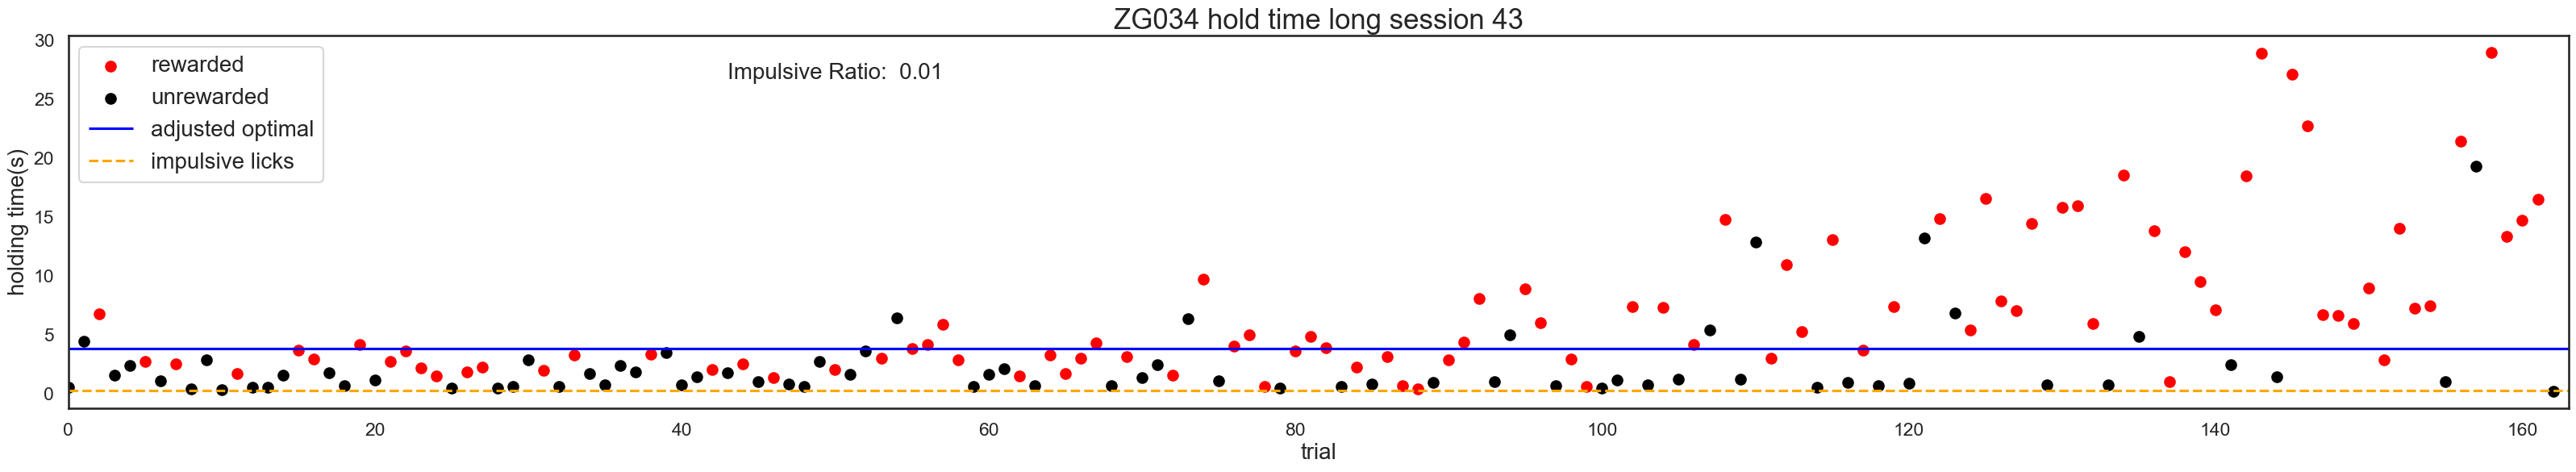

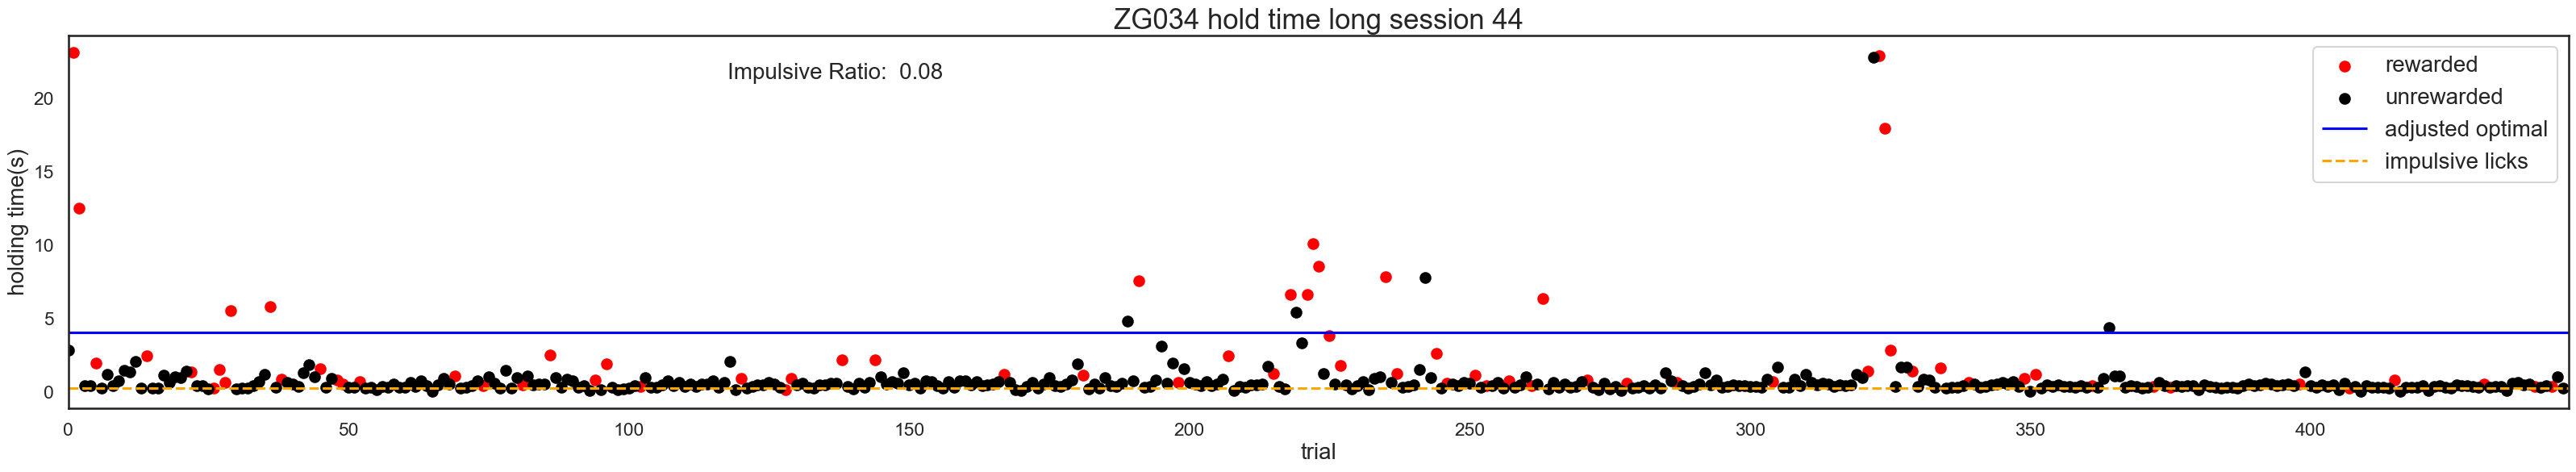

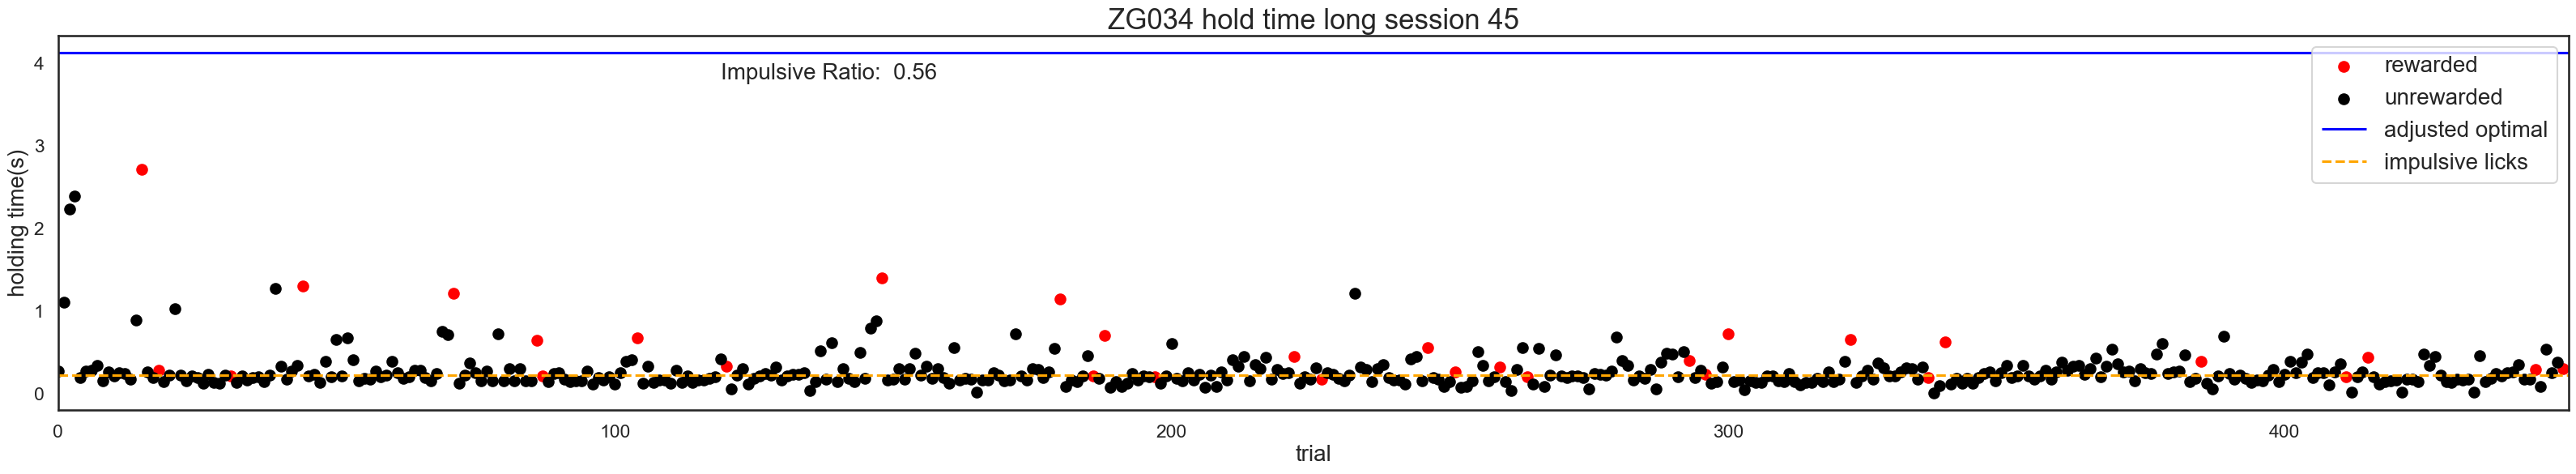

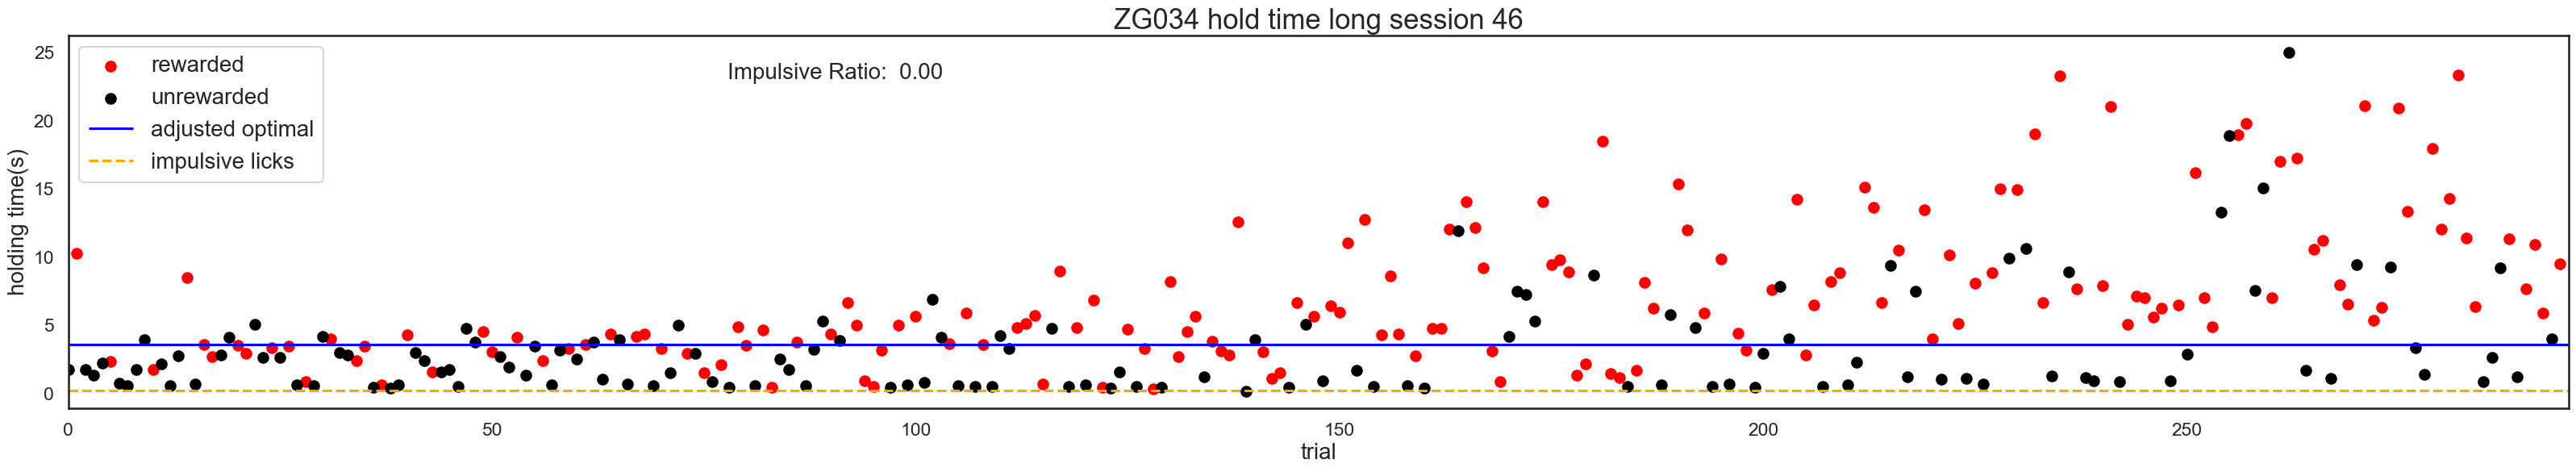

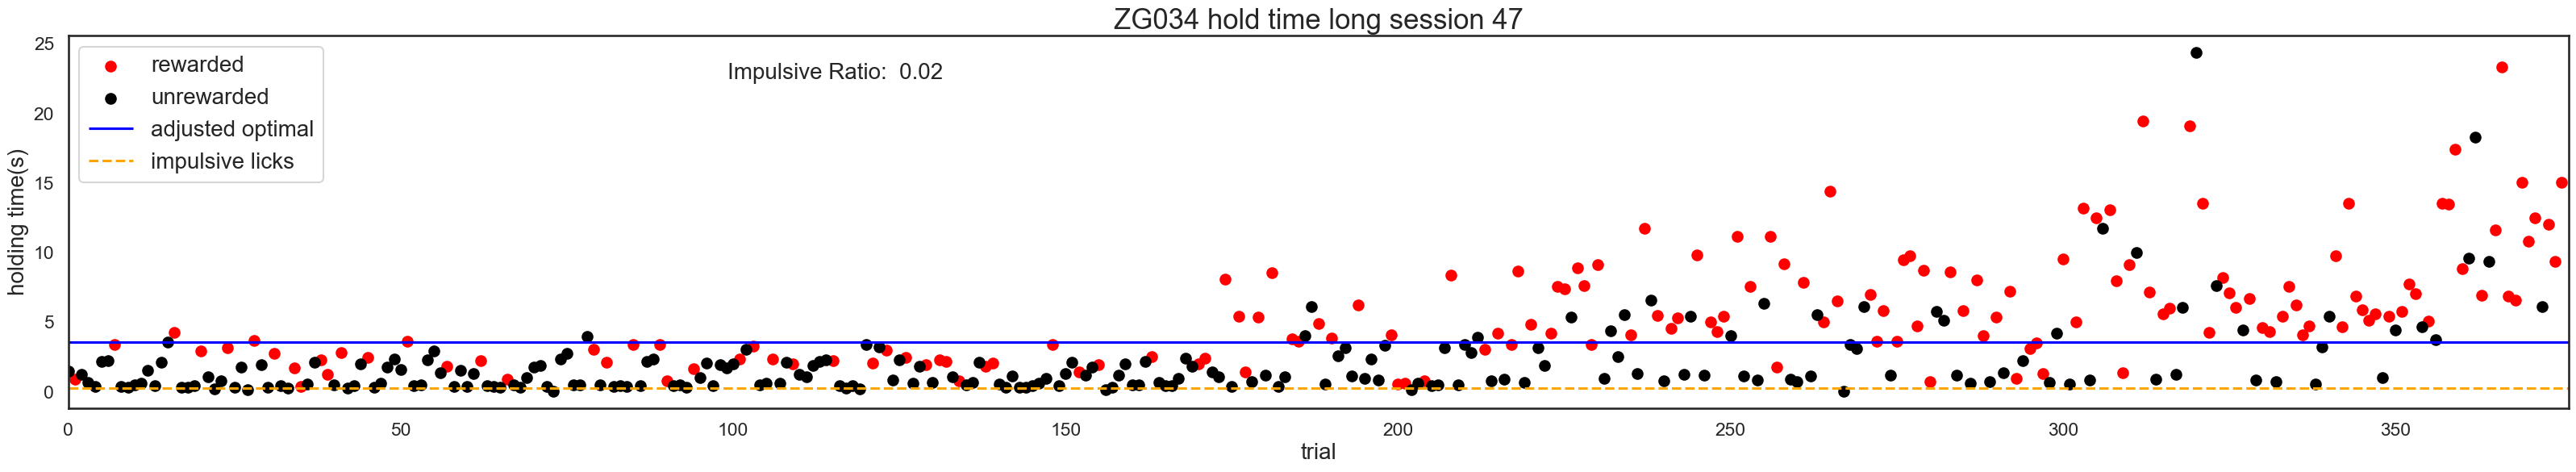

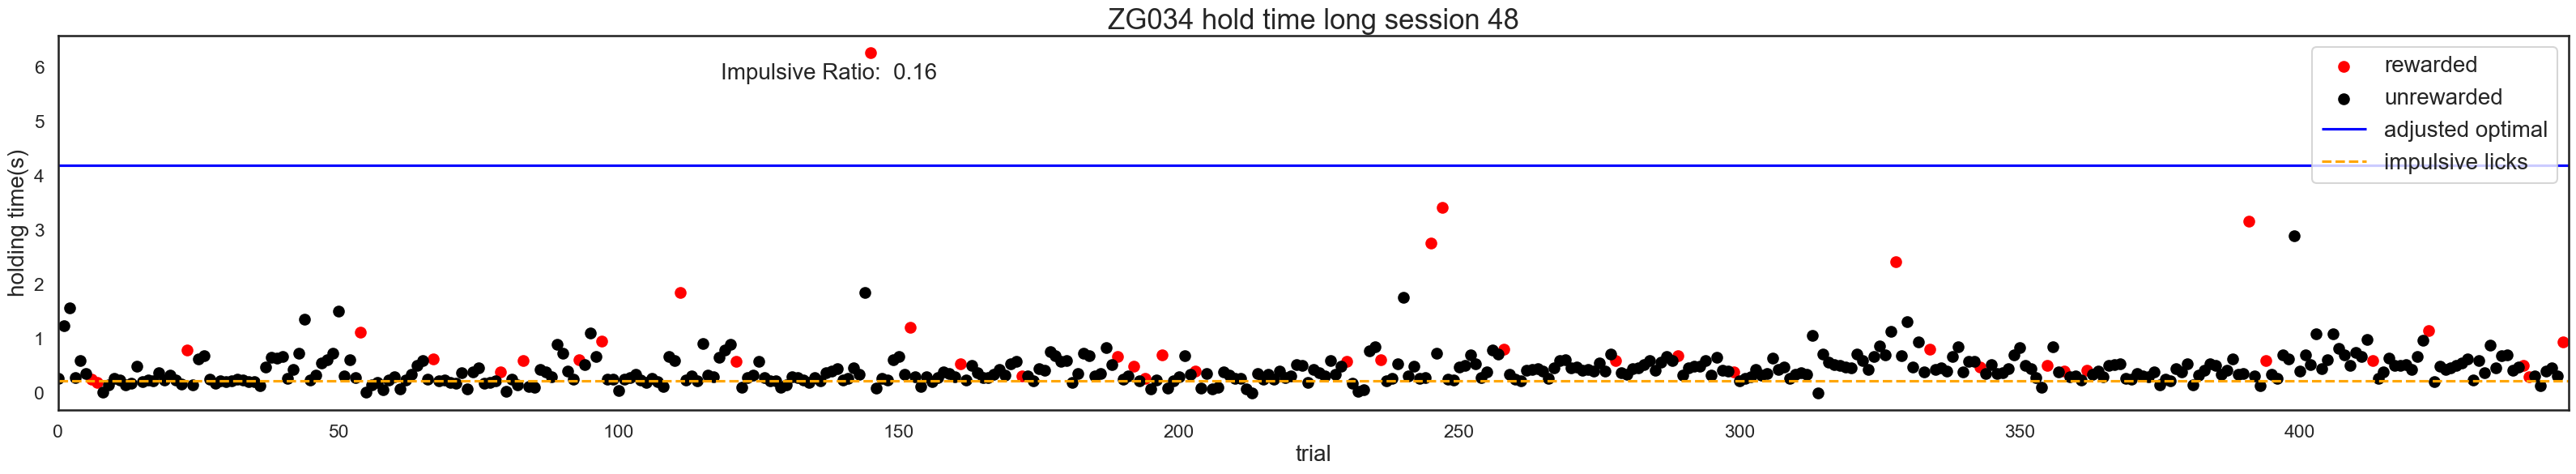

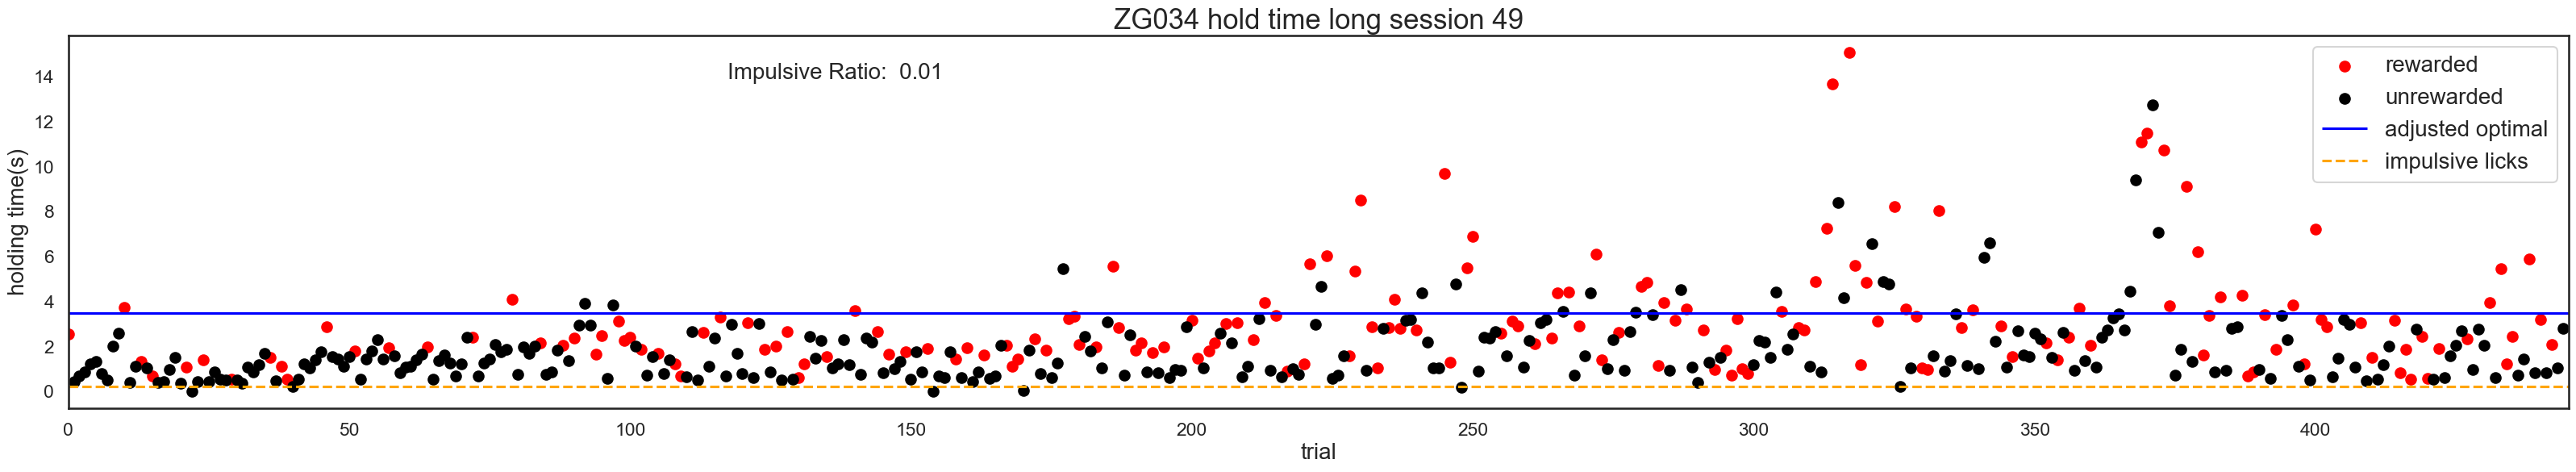

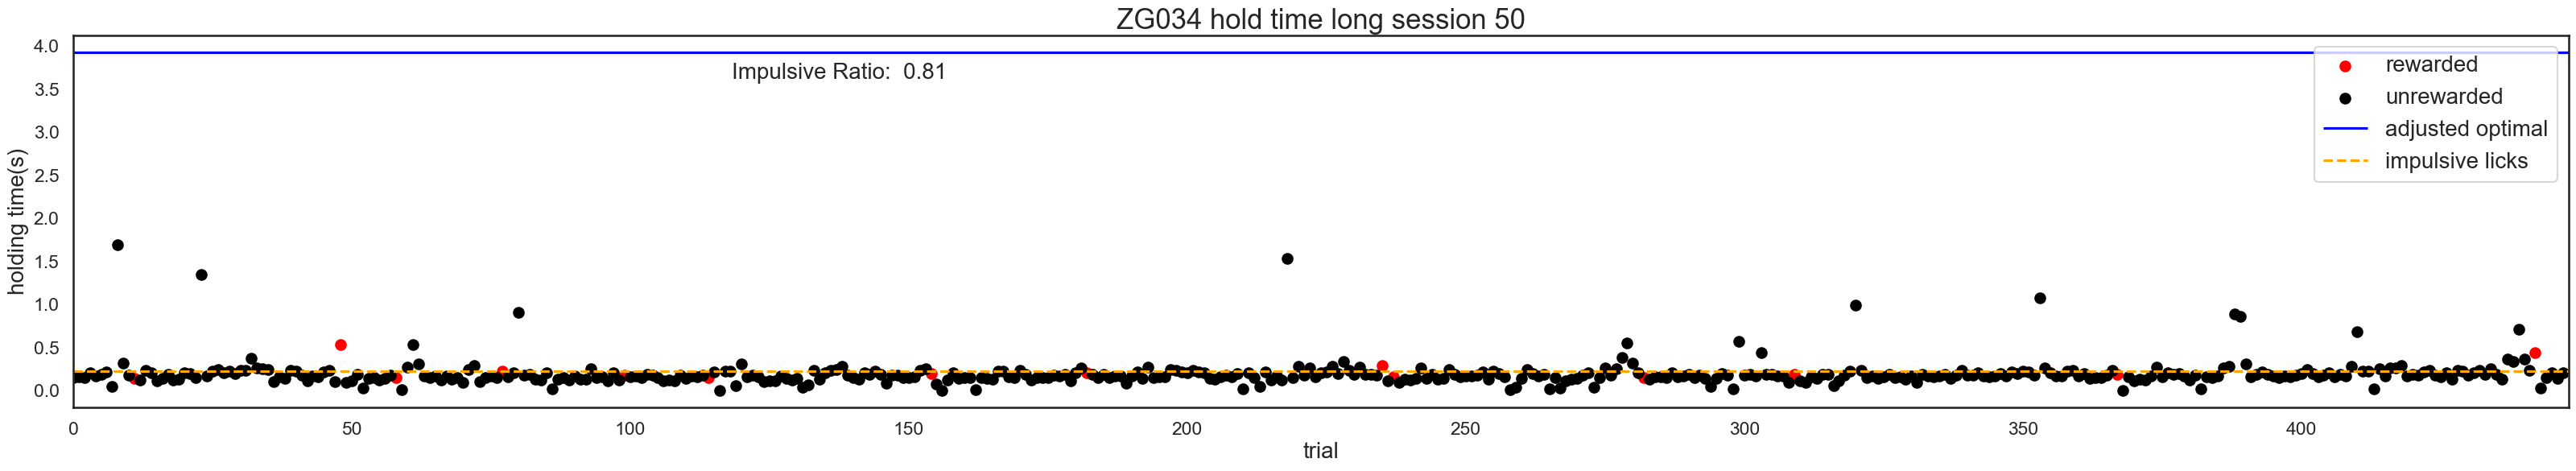

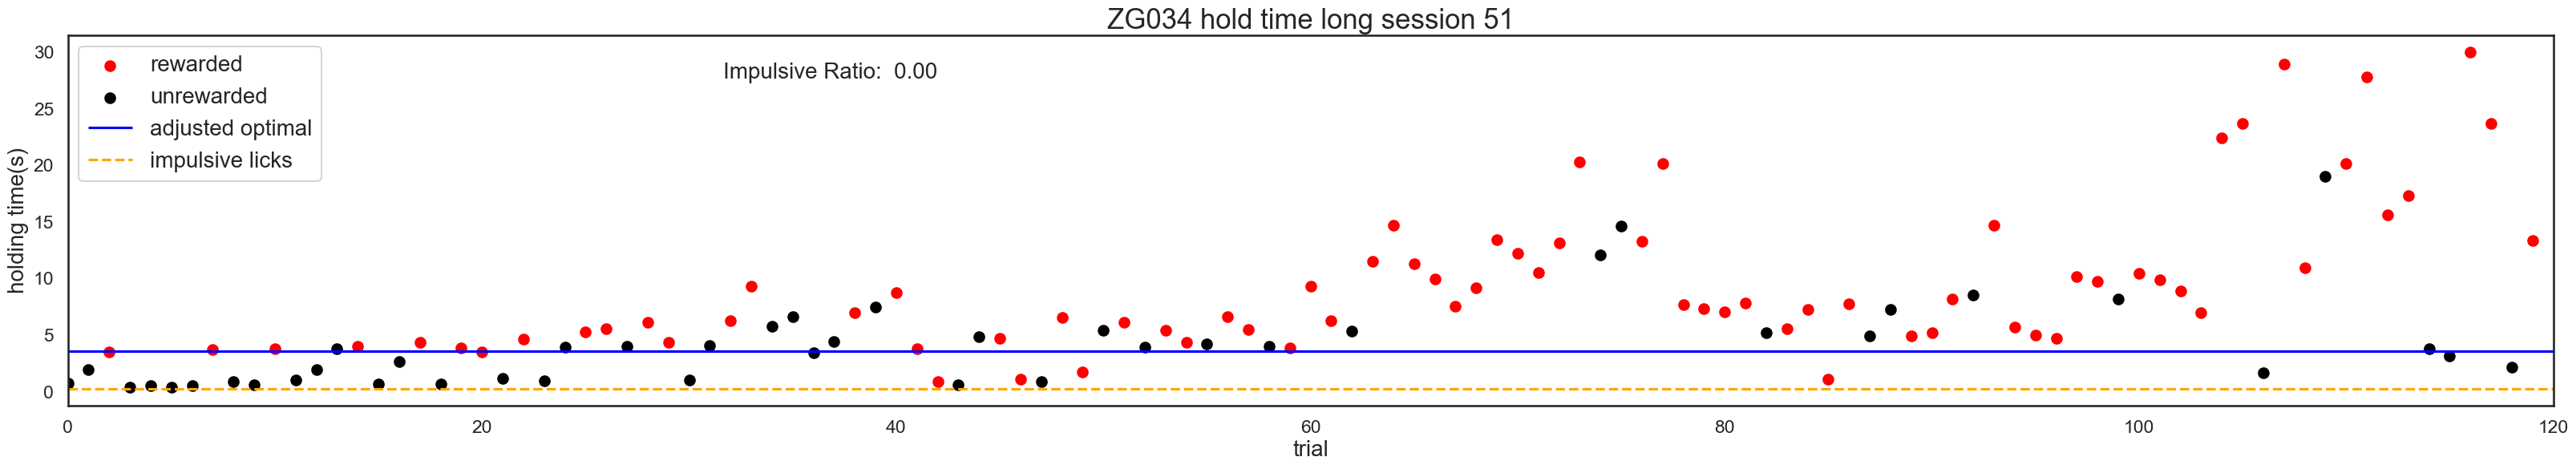

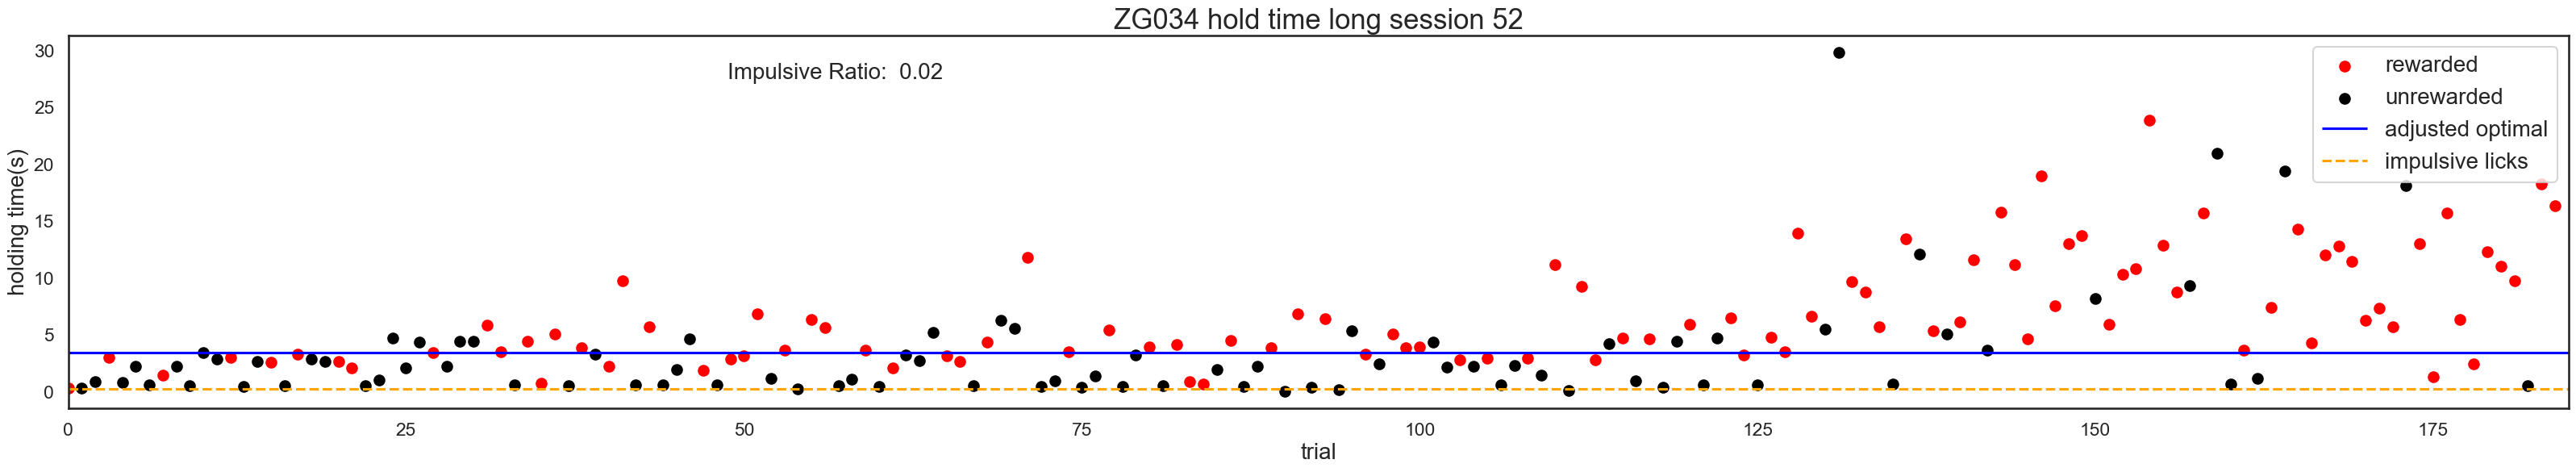

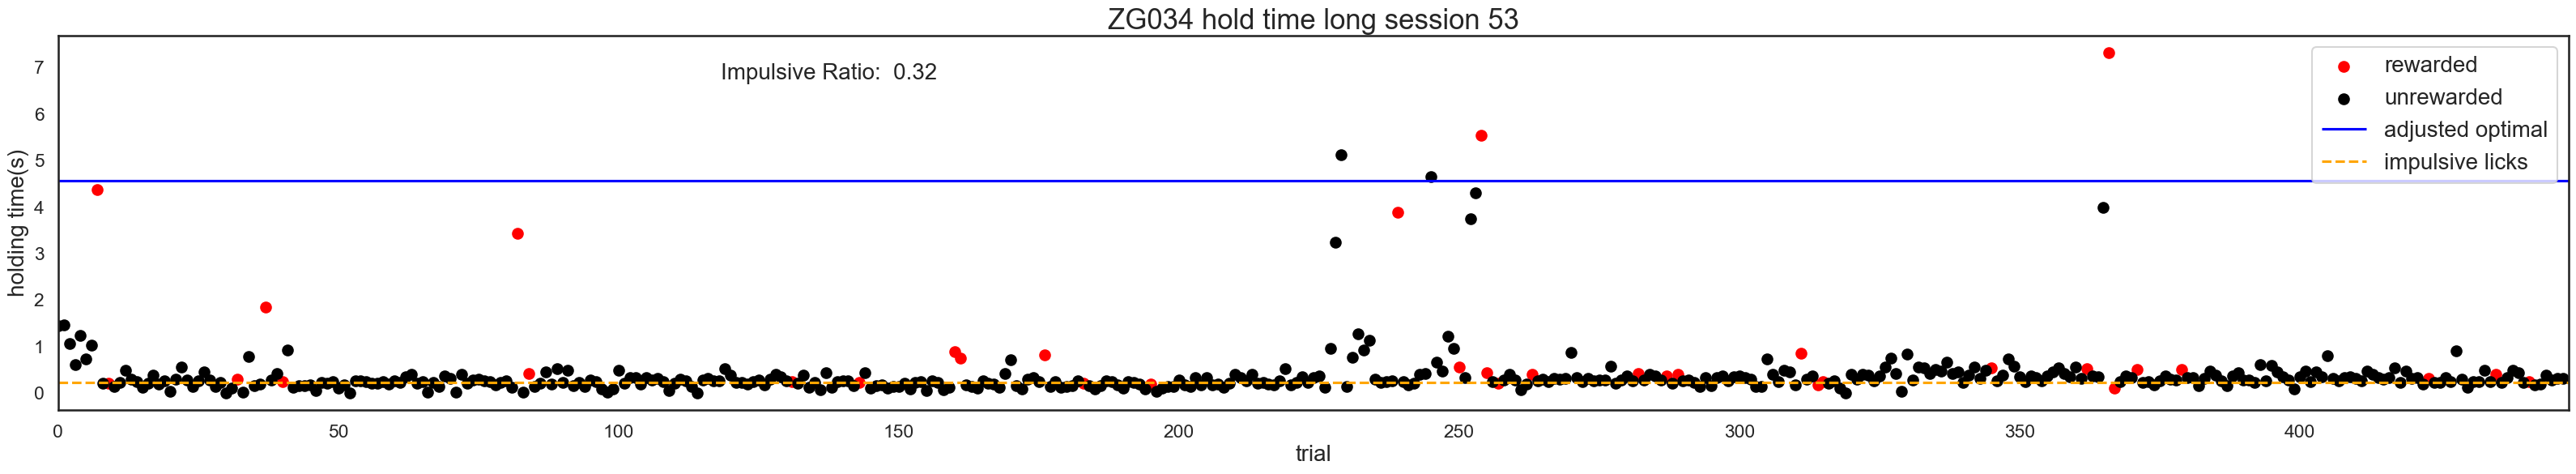

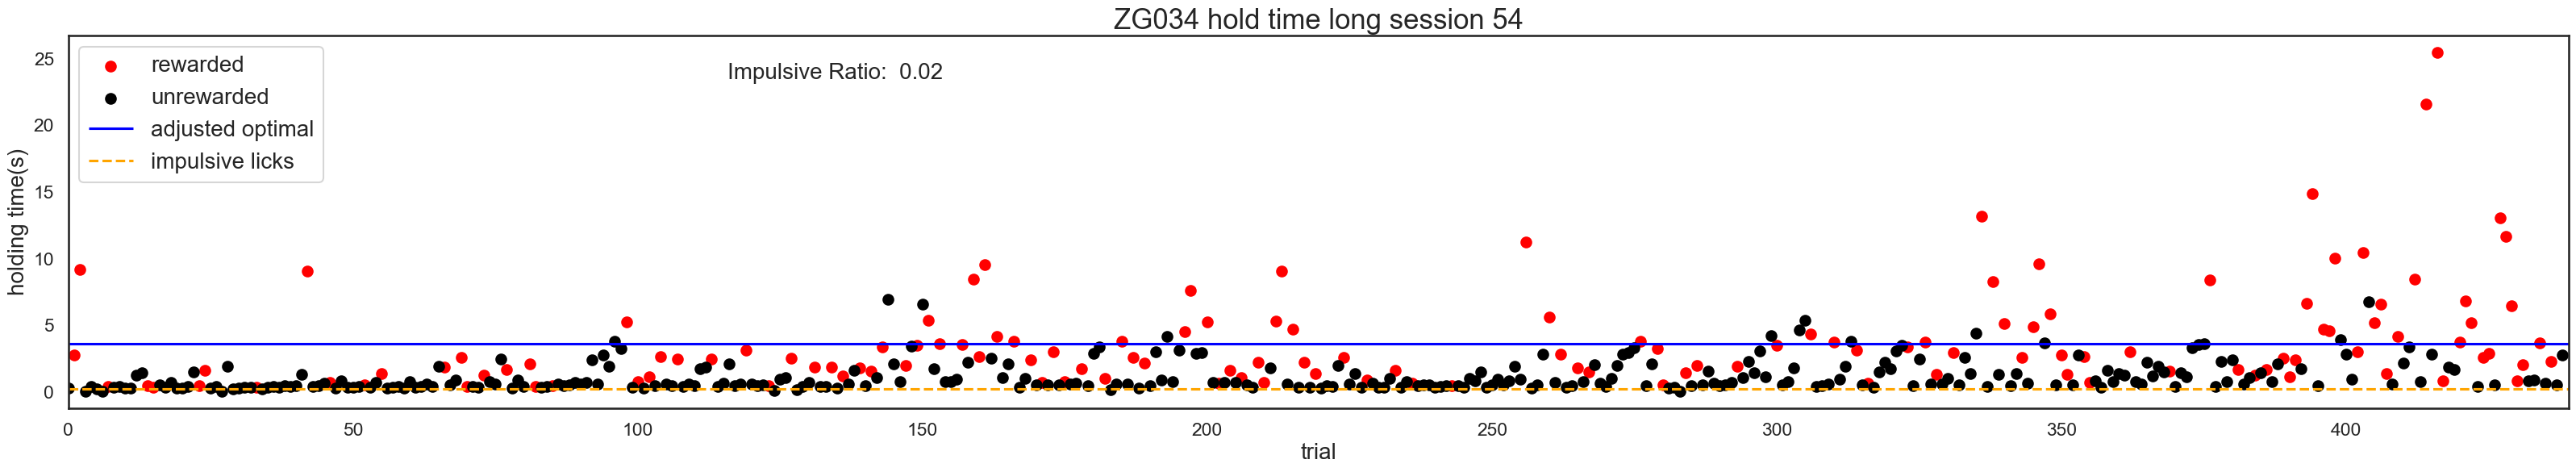

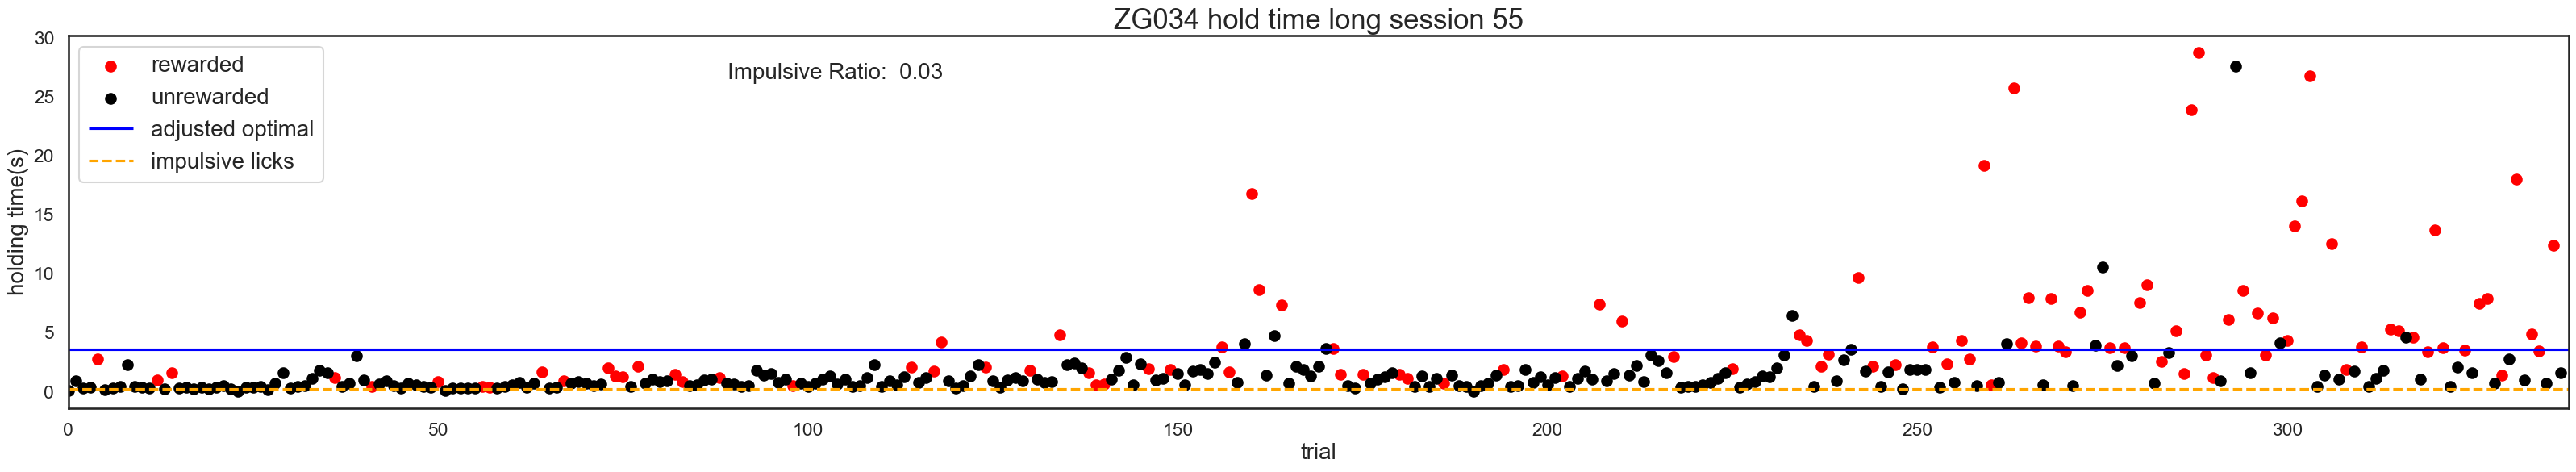

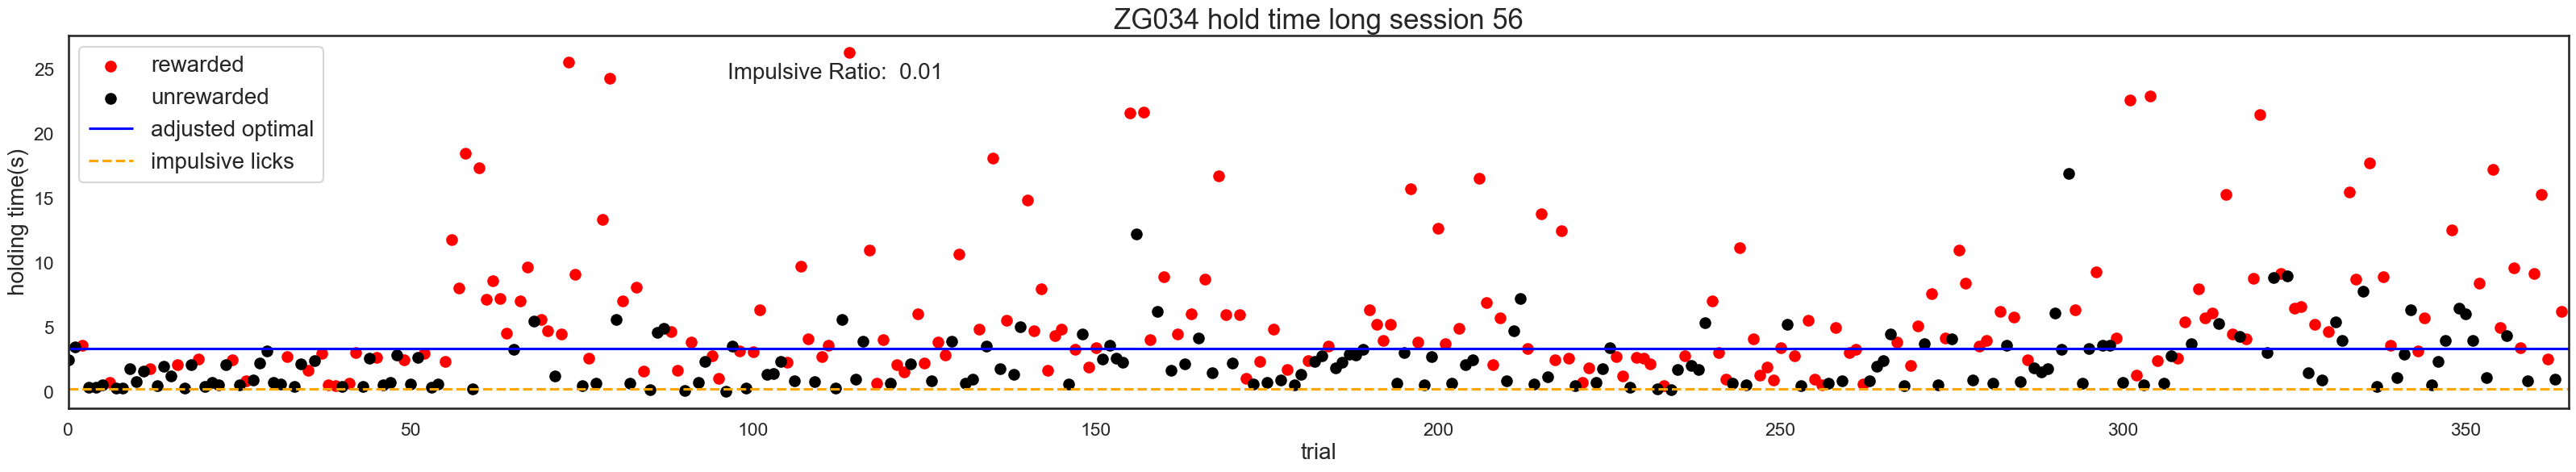

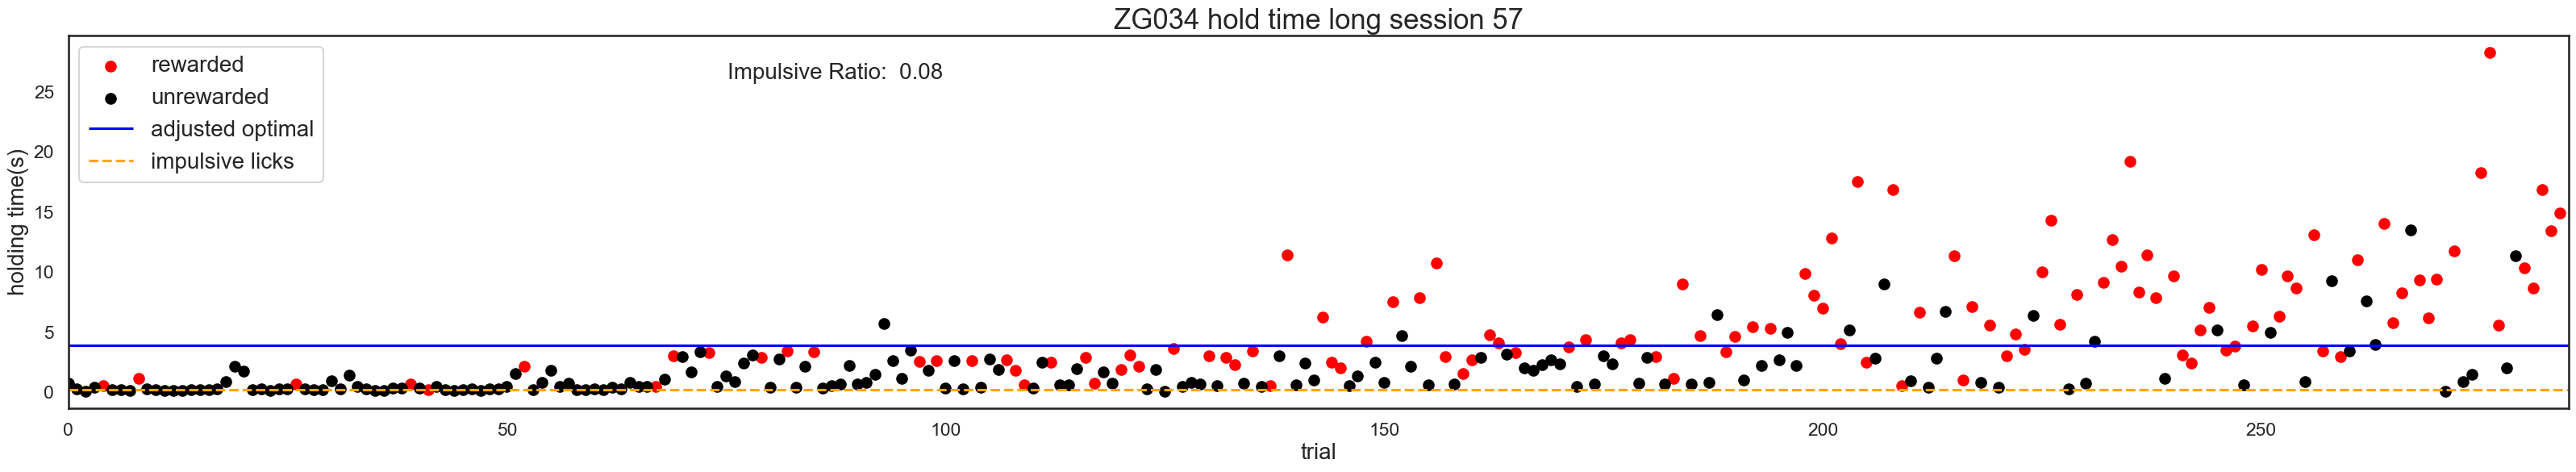

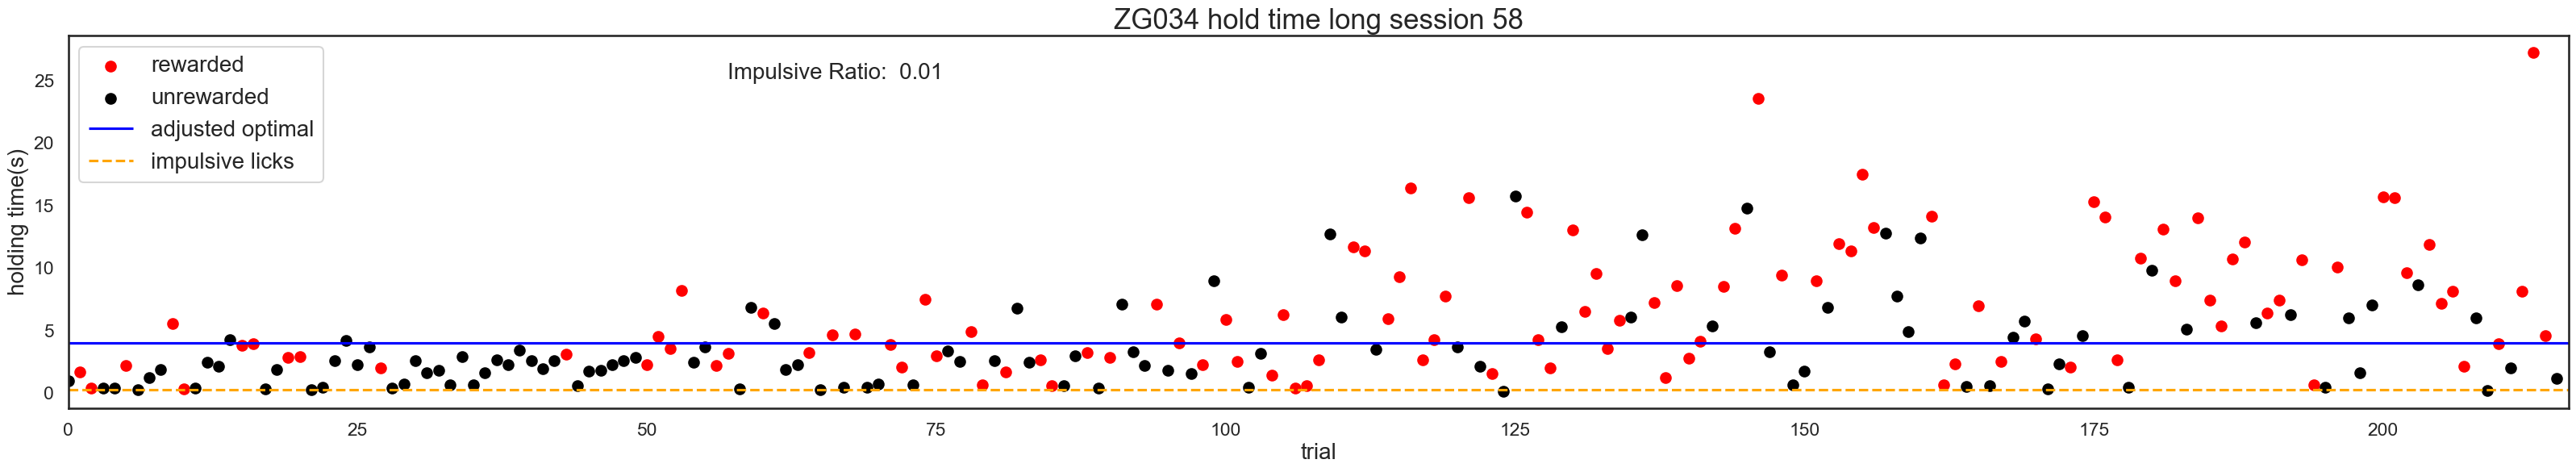

In [290]:
saving= False
# extract single mouse data
# for id in range(0,len(mouse_list)):
id = 2
mouse = mouse_list[id]
df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]
impulsivity = []
session_adjusted_optimal = []
mean_session_licks = []
std_session_licks = []
sess_disengaged_trials = []

for session in df_mouse['session']:
    row = df_mouse.loc[df_mouse['session'] == session]
    cohort = row['cohort'].values[0]
    sess_licks = row['licktime'].values[0]
    sess_reward = row['reward history'].values[0]

    mean_session_licks.append(np.mean(sess_licks))
    std_session_licks.append(np.std(sess_licks))

    lick_array  = np.array(sess_licks)
    # trials to remove from analysis
    if cohort == "long":
        impulsive_threshold = 0.23
    else:
        impulsive_threshold = 0.11
    sess_reflexive_licks =(lick_array[lick_array <= impulsive_threshold])
    impulsive_rate = len(sess_reflexive_licks)/len(lick_array)
    impulsivity.append(impulsive_rate)

    rewarded_indices = [index for index,value in enumerate(sess_reward) if value == 1]
    unrewarded_indices = [index for index,value in enumerate(sess_reward) if value == 0]
    rewarded_licktime = [sess_licks[index] for index in rewarded_indices]
    unrewarded_licktime = [sess_licks[index] for index in unrewarded_indices]
    
    session_optimal = row['optimal'].values[0]
    session_adjusted_optimal.append(session_optimal)
    fig, ax = plt.subplots(figsize=(40, 6))
    ax.scatter(rewarded_indices,rewarded_licktime,c='red')
    ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
    ax.set_title(f'{mouse} hold time {cohort} session {session}',fontsize = 25)
    ax.set_xlabel("trial",fontsize = 20)
    ax.set_xlim([0,len(sess_licks)])
    ax.hlines(session_optimal,xmin = 0,xmax = len(sess_licks),colors='b')
    ax.hlines(impulsive_threshold,xmin = 0,xmax = len(sess_licks),linestyles='dashed',colors = 'orange')
    ax.set_ylabel("holding time(s)",fontsize = 20)
    ax.legend(['rewarded','unrewarded','adjusted optimal','impulsive licks','diengagement'],loc='best',fontsize = 20)
    plt.text(0.35, 0.9, f'Impulsive Ratio: {impulsive_rate: .2f}', verticalalignment='center',\
              horizontalalignment='right', transform=plt.gca().transAxes, fontsize = 20)
    if saving:
        save_path = f'/Users/cecelia/Desktop/Shuler Lab/licktime_analysis/figures/{mouse}/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path + f'{mouse}_sess{session}.png')
    # plt.close()
print(f'Impulsive sessions to remove: {np.where(np.array(impulsivity)>0.3)[0]}')
# print('Disengaged trials each session')
# print(sess_disengaged_trials)

In [ ]:
fig2 = plt.figure()
plt.plot(impulsivity)
plt.xlabel('Session')
plt.ylabel('Impulsive rate')
plt.title(f'Percentage of impulsivity across sessions {mouse} {cohort}')

fig3 = plt.figure()
plt.step(range(0,len(mean_session_licks)),session_adjusted_optimal, color = 'blue', alpha = 0.5)
plt.plot(mean_session_licks,color='orange')
plt.fill_between(range(0,len(mean_session_licks)),np.array(mean_session_licks) - np.array(std_session_licks), np.array(mean_session_licks) + np.array(std_session_licks), color='orange', alpha=0.2, label='±1 std dev')
plt.legend(['adjusted optimal','session average','session std'])
plt.ylabel('Wait Time')
plt.xlabel('Session')
plt.title(f'Wait time optimal vs. session average {mouse} {cohort}')

**Individual mice all sessions visualization**

In [ ]:
mouse_list

In [ ]:
chosen_mouse = 'ZG030'
id = mouse_list.index(chosen_mouse)
mouse = mouse_list[id]
row = df_by_mouse[df_by_mouse['mouse'] == mouse]
fig, ax = plt.subplots(figsize=(40, 6))
cohort = row['cohort'].values[0]
all_licks = np.array(row['all_licks'].values[0])
print(f"all trials length {len(all_licks)}")
all_reward = np.array(row['all_reward'].values[0])
sess_cutoff = row['trial_num'].values[0]
rewarded_indices = [index for index,value in enumerate(all_reward) if value == 1]
unrewarded_indices = [index for index,value in enumerate(all_reward) if value == 0]
rewarded_licktime = all_licks[rewarded_indices]
unrewarded_licktime = all_licks[unrewarded_indices]

ax.scatter(rewarded_indices,rewarded_licktime,c='red')
ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
ax.vlines(sess_cutoff, ymin = 0, ymax = max(all_licks),color='blue')
ax.set_title(f'{mouse} - {cohort}')
ax.set_xlabel("Trial number")
ax.set_xlim([0,len(all_licks)])
ax.set_xticks(sess_cutoff)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("holding time(s)")
ax.legend(['rewarded','unrewarded'])

**Population mice visualization**

In [ ]:
# saving= False
# for id in range(0,len(mouse_list)): #hard code ten for now
#     mouse = mouse_list[id]
#     row = df_by_mouse[df_by_mouse['mouse'] == mouse]
#     fig, ax = plt.subplots(figsize=(40, 6))
#     cohort = row['cohort'].values[0]
#     all_licks = np.array(row['all_licks'].values[0])
#     all_reward = np.array(row['all_reward'].values[0])
#     sess_cutoff = row['trial_num'].values[0]
#     rewarded_indices = [index for index,value in enumerate(all_reward) if value == 1]
#     unrewarded_indices = [index for index,value in enumerate(all_reward) if value == 0]
#     rewarded_licktime = all_licks[rewarded_indices]
#     unrewarded_licktime = all_licks[unrewarded_indices]

#     ax.scatter(rewarded_indices,rewarded_licktime,c='red')
#     ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
#     ax.vlines(sess_cutoff, ymin = 0, ymax = max(all_licks),color='blue')
#     ax.set_title(f'{mouse} - {cohort}')
#     ax.set_xlabel("trial")
#     ax.set_xlim([0,len(all_licks)])
#     ax.set_ylabel("holding time(s)")
#     ax.legend(['rewarded','unrewarded'])
#     save_path = f'/Users/cecelia/Desktop/Shuler Lab/licktime_analysis/figures/{mouse}/'
#     if saving:
#         if not os.path.exists(save_path):
#             os.makedirs(save_path)
#         plt.savefig(save_path + f'{mouse}_all_licks.png')
#         plt.close()
#     else:
#         plt.close()

**Gaussian HMM for individual mice**

In [ ]:
# id = 2
# mouse = mouse_list[id]
df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]
print(mouse)
X = []
# counter = 0
for session in df_mouse['session']:
    rows = df_mouse.loc[df_mouse['session'] == session]
    cohort = rows['cohort'].values[0]
    sess_licks = np.array(rows['licktime'].values[0])
    # sess_reward = np.array(rows['reward history'].values[0])
    prev_licks = np.array(rows['previous lick'].values[0])
    prev_reward = np.array(rows['previous reward'].values[0])
    # counter = counter + len(sess_licks)
    # print(counter)
    this_session_matrix = np.concatenate((sess_licks.reshape(-1,1), prev_licks.reshape(-1,1),prev_reward.reshape(-1,1)), axis=1)
    if len(X) == 0:
         X = this_session_matrix
    else:
        X = np.vstack((X,this_session_matrix))

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
# print(counter)

In [ ]:
lls = []

num_iter = 50

time_bins = len(X)   # number of time bins
num_of_states = 5    # number of discrete states
obs_dim = 3       # dimensionality of observation

models = []
states = [2,3,4,5,6]
for n_components in states:     
    model = ssm.HMM(n_components, obs_dim,observations="gaussian",transitions="inputdriven")
    score = model.fit(X_train,method="em", num_iters=num_iter, init_method="kmeans")  
    models.append(model)
    lls.append(model.log_likelihood(X_test))
    plt.plot(score, label="EM")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()
plt.plot(lls)
plt.xlabel("States")
plt.xticks(np.arange(0,num_of_states),["2","3","4","5","6"])
plt.ylabel("Log likelihood on Test data")
plt.show()
# plt.close()

In [ ]:
for model in models:
    most_likely_states = model.most_likely_states(X)
    lim = 1.05 * abs(X).max()
    plt.figure(figsize=(8, 4))
    plt.subplot()
    for d in range(obs_dim):
        plt.plot(X[:,d] + lim * d, '-k')
        
    plt.imshow(most_likely_states[None,:], 
            aspect="auto", cmap=cmap_custom,
            vmin=0, vmax=len(color_two_states)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    plt.xlim(6908,7354)
    plt.ylabel("Features")
    tick_position = lim * np.arange(obs_dim)
    plt.yticks(tick_position,["licks", "pre_licks", "reward"])
    plt.xlabel("trials")

    plt.tight_layout()

In [ ]:
states = [2,3,4,5,6]

In [ ]:
chosen_state_num = 3
save_to_df = False
df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]
model = models[0]

# for chosen_state_num in states:
    # model = models[states.index(chosen_state_num)]  
model = models[states.index(chosen_state_num)]      
session_start_idx = 0

new_row = []
for session in df_mouse['session']:
    rows = df_mouse.loc[df_mouse['session'] == session]
    cohort = rows['cohort'].values[0]
    sess_cutoff = rows['session length'].values[0]
    session_end_idx = session_start_idx + sess_cutoff

    data_this_session = X[session_start_idx:session_end_idx,:]
    states_curr_session = model.most_likely_states(data_this_session)
    new_row.append(states_curr_session)
    state_num = max(states_curr_session)

    lim_up = 1.1 * (X).max()
    lim_down = 1.05*(X).min()
    session_start_idx = session_end_idx 

    sess_licks = rows['licktime'].values[0]
    # plt.subplots()
    # plt.scatter(np.arange(len(sess_licks)),sess_licks)
    # plt.title(f"Session {session} licks raw")
    # plt.ylim([0,30])

    # print(f'states num: {len(states_curr_session)} \n')
    # print(f'licks num: {len(sess_licks)} \n')
    assert(len(states_curr_session) == len(sess_licks))
    fig, ax1 = plt.subplots(figsize=(20, 6))

    ax1.plot(data_this_session[:,0], '-k')
    ax1.plot(data_this_session[:,2] + lim, '-k')

    ax1.imshow(states_curr_session[None,:],
            aspect="auto",
            cmap=cmap_custom,
            vmin=0,
            vmax=len(color_two_states)-1,
            extent=(0, len(states_curr_session), -1, lim+2))

    # ax1.set_xlim(0, df_mouse['session length'].max())
    ax1.set_xlabel("Trial number")
    tick_position = lim * np.arange(2)
    plt.yticks(tick_position,["licks", "reward"])
    xticks = np.arange(0, len(states_curr_session), 20)
    plt.xticks(xticks,rotation = 45)
    # plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])
    ax1.set_ylim([-1,lim+2])
    ax1.set_title(f"Session {session}")
    ax1.set_ylabel("Normalized lick time")
    # plt.close()
if save_to_df:
    df_mouse.loc[:,f'{state_num+1} States'] = new_row


**Visualize transition matrix**

In [ ]:
all_states = ['State1', 'State2', 'State3', 'State4', 'State5', 'State6',' ']
for i in range(len(models)):
            fig, ax = plt.subplots(figsize=(10,6))
            transition_matrix = models[i].transitions.transition_matrix
            cax = ax.matshow(transition_matrix, cmap='viridis')
            fig.colorbar(cax)
            curr_states = all_states[0:i+2]
            ax.set_xticks(np.arange(transition_matrix.shape[1]))
            ax.set_yticks(np.arange(transition_matrix.shape[0]))
            ax.set_xticklabels(curr_states)#, 'State 5'])
            ax.set_yticklabels(curr_states)#, 'State 5'])

            # Adding numbers to the matrix
            for a in range(transition_matrix.shape[0]):
                for b in range(transition_matrix.shape[1]):
                    text = ax.text(b, a, round(transition_matrix[a, b], 2),
                                ha="center", va="center", color="w")

            # Title and labels
            ax.set_xlabel('To State')
            ax.set_ylabel('From State')
            ax.set_title('Transition Probability Matrix')
      

**State occupancy overtime**

In [ ]:
type(cmap_custom)

In [ ]:
# states = [2,3,4,5,6]
states = [3]
state_occupancy = []

for state in states:
    state_occupancy = []
    for session in df_mouse['session']:
        rows = df_mouse.loc[df_mouse['session'] == session]
        trial_state = rows[f'{state} States'].values[0]
        sess_length = len(trial_state)
        temp = []
        for i in range(state):
            temp.append(list(trial_state).count(i)/sess_length)
        state_occupancy.append(temp)         
    fig, ax = plt.subplots(figsize=(10, 5))
    for this_state in range(len(state_occupancy[0])):
        this_state_occ = [sublist[this_state] for sublist in state_occupancy]
        ax.plot(this_state_occ,color =cmap_custom(this_state))
    ax.legend(['state1', 'state2', 'state3', 'state4','state5', 'state6'])
    ax.set_xlabel('Session number')
    ax.set_ylabel('Percentage of state occupancy')  
    ax.set_ylim([0,1])


**Mean, STD and CV of each state**

In [ ]:
session_mean

In [ ]:
for state in states:
    session_mean = []
    session_std = []
    session_cv = []
    for session in df_mouse['session']:
        rows = df_mouse.loc[df_mouse['session'] == session]
        trial_state = rows[f'{state} States'].values[0]
        sess_licks = rows['licktime'].values[0]
        sess_licks = sess_licks[1:]
        mean_ = []
        std_ = []
        cv_ = []
        for i in range(state):
            indices = [j for j, x in enumerate(trial_state) if x == i]
            state_licks = sess_licks[indices]
            mean_.append(np.mean(state_licks))
            std_.append(np.std(state_licks))
            coeff_var = [(x / y )* 100for x, y in zip(std_, mean_)]
            cv_.append(coeff_var)
        session_mean.append(mean_)  
        session_std.append(std_)  
        session_cv.append(cv_)  
    


In [ ]:
range(0,curr_mice.all_holding_l_index[0])
len(curr_mice.all_holding_l_list[0].values)

**plot session average and session adjusted optimal together**

In [ ]:
session_avg =curr_mice.holding_l_mean[:curr_mice.default_session_num]
# plot session average and session adjusted optimal together
fig, ax = plt.subplots(figsize=(5, 5))
session_avg =curr_mice.holding_l_mean[:curr_mice.default_session_num]
ax.plot(curr_mice.session_adjusted_optimal[0:len(session_avg)],label = 'adjusted optimal')
ax.plot(session_avg, label = 'session average')
ax.legend()
ax.set_ylabel('Wait Time')
ax.set_xlabel('Session')
ax.set_title(f'Wait Time optimal vs. average per session {curr_mice_id} {curr_mice.default}')